<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

### Updates
1. Implemented structure to use more complex decision algorithms 
2. More dynamic tunability for medical images
3. New plots and visualization

### To Do
1. Get baseline results
2. Define a standarized norm for the radiologists and medical images
3. Dashboard
4. System Level Check
5. Incoporate Success measure for if image is processed in time
6. gamma distribution for average read rate by Radiologist Non-specialist: alpha=15, beta=1 | Specialist: a=20, b=2
7. Radiologist success rates, missread rate, 
8. Tiers of radiologists - 4 tiers? 



In [40]:
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import warnings
warnings.filterwarnings("ignore")
sys.setrecursionlimit(10000)


class G:
    ITERATIONS = 100
    DURATIONS = 6120

    
G.target_times = {
    1: 5,
    2: 10,
    3: 60
}

G.process_times = {
    1: 2,
    2: 2,
    3: 2
} 


def update_target_times(target_times):
    G.target_times = {
        1: target_times[0],
        2: target_times[1],
        3: target_times[2]
    }

    
G.specialties = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}


def update_globals(urg_times, proc_times):
    G.target_times = {
                        1: urg_times[0],
                        2: urg_times[1],
                        3: urg_times[2]
                    }  
    G.process_times = {
                        1: proc_times[0],
                        2: proc_times[1],
                        3: proc_times[2]
                    } 
    

def create_arrival_times(sim_time, arr_rates):  #[time_between_urg 1 images, etc..]
    arrival_times_dict = {}
    arrival_times_tuples_list = []
    #Create arrival times for each urgency of images
    urg = 1
    for arr_time in arr_rates:
        arrival_times = []
        time = 0
        while time < sim_time:
            time += np.random.exponential(arr_time)
            arrival_times.append(time)
            arrival_times_tuples_list.append([urg, time])
        arrival_times_dict[urg] = arrival_times
        urg += 1
    arrival_times_tuples_list = sorted(arrival_times_tuples_list, key=lambda x: x[1])
    return arrival_times_dict, arrival_times_tuples_list


def create_medical_images(arrival_times_tuples_list):
    med_images = []
    for img_id, tup in enumerate(arrival_times_tuples_list):
        med_images.append(MedicalImage(img_id, tup[1], tup[0], random.sample(list(G.specialties.keys()), 1)[0]))
    print(f"{len(med_images)} medical images")
    return med_images


def create_constant_rads(num_rads):
    specialties_list = []
    for i in range(num_rads):
        specialties_list.append(random.sample(list(G.specialties.keys()), random.randrange(2,len(G.specialties))))
    G.const_specialities = specialties_list

    
def create_radiologists(num_rads, constant_rads):
    radiologists = []
    for i in range(num_rads):
        if constant_rads:
            specialties_temp = G.const_specialities[i] 
        else:
            specialties_temp = random.sample(list(G.specialties.keys()), random.randrange(2,len(G.specialties)))
        radiologists.append(Radiologist(i, specialties_temp))
    return radiologists


def create_initial_events(sim_duration, med_images, cutoff=False):
    events=[]
    for img in med_images:
        events.append([img.time_created, 'New Job', img])
    if cutoff:
        events.append([sim_duration*2, "Sim End"])
    events = sorted(events, key=lambda x: x[0])
    return events


def start_simulation(events, med_images, radiologists, constant_rads, cutoff=False):
    s = SystemState(events, med_images, G.radiologists, cutoff)
    s.run_simulation()


class MedicalImage(object):    
    def __init__(self, img_id, time_created, urgency, image_type):#, modality, speciality, urgency, image_label):
        self.img_id = img_id
        self.time_created = time_created
        self.urgency = urgency
        self.image_type = image_type
        self.target_time = G.target_times[urgency]
        self.time_remaining = G.target_times[urgency]
        self.est_process_time = G.process_times[urgency]
        self.in_queues = []   #keep track on which queues image is in [rad_id, position]
        self.time_seen = 0
        self.time_done = 0
        self.rad_seen = "None"
        self.success = 0
        self.on_time = 0
        self.been_redistributed = False
        
    def update_time_remaining(self, t):
        self.time_remaining = self.target_time - (t - self.time_created)
        #If time is running low, send image to more rads
        if self.time_remaining <= 2 * self.target_time:
            if self.been_redistributed == False:
                self.been_redistribtued = True
                return True
            else:
                return False
        else:
            return False
        
    #def check_status(self, t):
    #    return 0
        
        
class Radiologist:
    def __init__(self, rad_id, specialties, working=True):
        self.queue = []
        self.queue_data = []#[med_image, image_id, image_urgency, time_left, est_time]
        self.rad_id = rad_id
        self.specialties = specialties
        self.is_working = working
        self.is_idle = 1
        self.images_served = []
        self.idle_times = []
        self.time_busy_start = 0
        self.time_idle_start = 0
        self.busy_times = []
        self.time = 0
        self.time_of_step = 0
        self.queue_length = []
        self.service_starts = []
        self.service_ends = []
        self.service_time = [] 
        self.misread_pr = 0.05
        
    def get_stats(self):
        return self.idle_times, self.busy_times, self.queue_length, self.service_starts, self.service_ends, self.service_time 
        
    def show_queue(self):
        return self.queue
    
    def estimate_queue_time(self):
        t = 0
        for img in self.queue:
            t += img.est_process_time
        return t
    
    def add_job(self, med_image, time):
        #update idle time tracker
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
            self.time_busy_start = time
        self.is_idle = 0
        #add img to queue and sort
        #self.queue.append(med_image)
        #if len(self.queue) > 1:
        #    self.sort_queue()
        if len(self.queue) <= 1:
            self.queue.append(med_image)
            self.queue_data.append([med_image, med_image.img_id, med_image.urgency, med_image.time_remaining, med_image.est_process_time, med_image.est_process_time]) #[image_id, image_urgency, time_left, est_time]
        else:
            if med_image.urgency == 1:
                ins_ind = 1
                for ind, img in enumerate(self.queue[1:]):
                    if img.urgency > 1:
                        ins_ind = ind + 1
                        break          
                self.queue.insert(ins_ind, med_image)
            elif med_image.urgency == 2:
                ins_ind = 1
                for ind, img in enumerate(self.queue[1:]):
                    if img.urgency > 2:
                        ins_ind = ind + 1
                        break          
                self.queue.insert(ins_ind, med_image)
            else:
                self.queue.append(med_image)

    def sort_queue(self):
        curr_img = self.queue[0]
        queue_tuple = [[img, img.urgency] for img in self.queue[1:]]
        queue_tuple = sorted(queue_tuple, key=lambda x: x[1])
        #print(queue_tuple)
        queue_tuple_list = [tup[0] for tup in queue_tuple]
        self.queue = queue_tuple_list
        self.queue.insert(0, curr_img)
       
    def finish_job(self, time):
        if len(self.queue) == 0:
            self.time_finished_last_job = time
            self.time_idle_start = time
            self.busy_times.append(time - self.time_busy_start)
            self.is_idle = 1
    
    def update_idle_lists(self, time):
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
        elif self.is_idle == 0:
            self.busy_times.append(time - self.time_busy_start)
        
    def update_queue(self, time):
        images_low_on_time = []
        for img in self.queue:
            low_t_bool = img.update_time_remaining(time)
            #if low_t_bool:
            #    images_low_on_time.append(img)
        return images_low_on_time
            
        #sort_queue()        
    #def sort_queue(self):
                   
        
        
class SystemState:
    def __init__(self, sim_duration, events, images, rads, cutoff=False, verbose=False):
        self.time = 0
        self.sim_duration = sim_duration
        self.continue_running = True
        self.events = events
        self.images = images
        self.rads = rads
        self.rads_working = rads
        self.rads_not_working = []
        self.events_history = []
        self.queue_lengths = []
        self.time_steps = []
        self.img_table = pd.DataFrame(columns=['img_id', 'radiologist', 'urgency', 'create_time','seen_time', 'finished', 'img_wait_time', 'time_w_rad', 'total_time', 'on_time', 'success'])
        self.rad_table = pd.DataFrame()
        self.unfin_img_table = pd.DataFrame(columns=['img_id', 'radiologist', 'urgency', 'create_time','seen_time', 'finished', 'img_wait_time', 'time_w_rad', 'total_time', 'on_time', 'success'])
        self.verbose = verbose
        
    def create_event(self, time, event_type, obj):
        self.events.append([time, event_type, obj])
        self.events = sorted(self.events, key=lambda x: x[0])

    def update_img_table(self, med_img):
        column_names = ['img_id', 'radiologist', 'urgency', 'create_time','seen_time', 'finished','img_wait_time', 'time_w_rad', 'total_time', 'on_time', 'success'] 
        total_time = self.time - med_img.time_created
        if total_time < med_img.target_time:
            on_time = 1
        else:
            on_time = 0
        med_img.on_time = on_time
        success_val = med_img.success
        values = [med_img.img_id, med_img.rad_seen, med_img.urgency, med_img.time_created, med_img.time_seen, self.time, med_img.time_seen - med_img.time_created, self.time - med_img.time_seen, self.time - med_img.time_created, on_time, success_val] #[[med_img.time_created], [med_img.time_seen], [self.time], [self.time - med_img.time_seen], [self.time - med_img.time_created]]
        temp_df = pd.DataFrame(values).T
        temp_df.columns = column_names
        self.img_table = self.img_table.append(temp_df, ignore_index = True)
        
    def unfinished_jobs(self):
        unfin_med_images = []
        for rad in self.rads:
            unfin_med_images += rad.queue
            unfin_med_images = list(set(unfin_med_images))
        print(f"There are {len(unfin_med_images)} that were not completed in time")
        column_names = ['img_id','urgency', 'create_time','seen_time', 'finished','img_wait_time', 'time_w_rad', 'total_time']
        for med_img in unfin_med_images:
            values = [med_img.img_id, med_img.urgency, med_img.time_created, med_img.time_seen, self.time, med_img.time_seen - med_img.time_created, self.time - med_img.time_seen, self.time - med_img.time_created] #[[med_img.time_created], [med_img.time_seen], [self.time], [self.time - med_img.time_seen], [self.time - med_img.time_created]]
            temp_df = pd.DataFrame(values).T
            temp_df.columns = column_names
            self.unfin_img_table = self.unfin_img_table.append(temp_df, ignore_index = True)
        
    def process_event(self):
        event = self.events[0]
        self.events_history.append(event)
        self.time = event[0]       
        event_type = event[1]
        del self.events[0]
        temp_list = []
        for r in self.rads:
            temp_list.append(len(r.queue))
        self.queue_lengths.append(temp_list)
        self.time_steps.append(self.time)        
            
        if event_type == "New Job":
            self.distribute_job(event[2])
        elif event_type == "Job Done":
            rad = event[2]
            self.complete_job(rad)
        elif event_type == "Sim End":
            self.continue_running = False 
        if self.verbose==True:
            print("Event processed")
        if (len(self.events) == 0) or (self.events[0][1]=="Sim End"):
            self.continue_running = False 
        if self.continue_running:
            self.process_event()
        else:
            for rad in self.rads:
                rad.update_idle_lists(self.time)
            self.unfinished_jobs()
            print(f"Simulation complete at {self.time} minutes")
                
    def distribute_job(self, med_image):
        urgency = med_image.urgency
        image_type = med_image.image_type
        # Function to route medical images based on some algorithm
        chosen_rads = self.choose_rads(image_type)       
        for rad in chosen_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues() 
        
    def distribute_job_to_more(self, med_image):
        urgency = med_image.urgency
        image_type = med_image.image_type
        # Function to route medical images based on some algorithm
        chosen_rads = self.choose_more_rads(med_image)       
        for rad in chosen_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues() 
        
    def choose_rads(self, image_type):
        capable_rads = []
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if image_type in rad.specialties:
                capable_rads.append(rad)
        chosen_rads = self.n_quickest_queues(capable_rads, 3)
        return capable_rads
    
    def choose_more_rads(self, img):
        capable_rads = []
        current_rads = img.in_queues
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if rad not in current_rads:
                if img.image_type in rad.specialties:
                    capable_rads.append(rad)
        chosen_rads = self.n_quickest_queues(capable_rads, 3)
        return capable_rads
    
    def n_shortest_queues(self, rads_list, n):
        rads_tuples = []
        for rad in rads_list:
            rads_tuples.append([rad, len(rad.queue)])
        rads_tuples.sort(key = lambda x: x[1])
        return [rad[0] for rad in rads_tuples[:n]]
    
    def n_quickest_queues(self, rads_list, n):
        rads_tuples = []
        for rad in rads_list:
            rads_tuples.append([rad, rad.estimate_queue_time()])
        rads_tuples.sort(key = lambda x: x[1])
        return [rad[0] for rad in rads_tuples[:n]]
             
    def update_queues(self):
        low_t_images = []
        for rad in self.rads_working:
            low_t_images += rad.update_queue(self.time)
        if low_t_images != []:
            for img in low_t_images:
                self.distribute_job_to_more(img)
                
                
    def start_job(self, rad):
        med_image = rad.queue[0]
        image_type = med_image.image_type
        urgency = med_image.urgency
        rad.service_starts = self.time
        med_image.time_seen = self.time
        med_image.rad_seen = rad.rad_id
        self.events_history.append([self.time, "Job Started", med_image])
        process_time = np.random.exponential(G.process_times[urgency])
        self.create_event(self.time+process_time, "Job Done", rad)
        if self.verbose==True:
            print(f"Image {med_image.img_id} is seen by radiologist {rad.rad_id} at {self.time}")
        for r in med_image.in_queues:
            if r != rad:
                if med_image in r.queue:
                    r.queue.remove(med_image)           
        
    def complete_job(self, rad):
        med_image = rad.queue[0]
        # Determine if read was accurate
        success_val = np.random.binomial(1, 1-rad.misread_pr)
        med_image.success = success_val
        self.update_img_table(med_image)
        rad.images_served.append(med_image.img_id)
        rad.service_ends.append(self.time)
        med_image.time_done = self.time
        if self.verbose==True:
            print(f"Image {med_image.img_id} is done by radiologist {rad.rad_id} at {self.time}")
        del rad.queue[0]
        rad.finish_job(self.time)
        if len(rad.queue) > 0:
            self.start_job(rad)

    def run_simulation(self):
        self.process_event()

In [41]:
def gen_system_state(sim_time, rads_count, arr_rates, urg_times, process_times, constant_rads, cutoff, verbose):
    #Define urgency times
    update_globals(urg_times, process_times)
    #Create the intervals
    arrivals_dict, arrival_times_tuples_list = create_arrival_times(sim_time, arr_rates)
    #Create the images with their arrival time_seen
    med_images = create_medical_images(arrival_times_tuples_list)
    #Create the radiologists
    radiologists = create_radiologists(rads_count, constant_rads)
    #Create the image arrival events
    events = create_initial_events(sim_time, med_images, cutoff)
    s = SystemState(sim_time, events, med_images, radiologists, cutoff, verbose)
    return s


def sim(sim_time, rads_count, arr_rates, urg_times, process_times, constant_rads=False, cutoff=False, verbose=False):  
    s = gen_system_state(sim_time, rads_count, arr_rates, urg_times, process_times, constant_rads, cutoff, verbose)
    s.run_simulation()    
    return s


def plot_queue_lengths(s):
    fig, ax = plt.subplots()
    for i in range(len(s.queue_lengths[0])):
        plt.plot(s.time_steps, [item[i] for item in s.queue_lengths])

        
def wait_time_plot(img_table):
    fig, ax = plt.subplots()
    x = img_table['create_time'].values
    y = img_table['img_wait_time'].values
    colormap = {
        1: "red",
        2: "orange",
        3: "green"
               }
    colors_list = img_table['urgency'].map(colormap)
    plt.scatter(x, y, color=colors_list, alpha=.6)
    plt.xlabel("Time Job Begins")
    plt.ylabel("Time Until Job Seen")   
    plt.title("Time Before Job is Seen")
    red_patch = mpatches.Patch(color='red', alpha=.8, label='Urgency 1')
    orange_patch = mpatches.Patch(color='orange', alpha=.8, label='Urgency 2')
    green_patch = mpatches.Patch(color='green', alpha=.8, label='Urgency 3')
    plt.legend(handles=[red_patch, orange_patch, green_patch])
    plt.show()
    

def total_time_plot(img_table):
    x=img_table['create_time'].values
    y=img_table['total_time'].values
    plt.scatter(x, y)
    
        
def plt_mean_queue_length(s_list):
    fig, ax = plt.subplots()
    for s in s_list:
        plt.plot(s.time_steps, pd.DataFrame(s.queue_lengths).sum(axis=1), label=f"{len(s.rads)}")
    plt.xlabel("time")
    plt.ylabel("Mean Queue Length")
    plt.legend()
    plt.show()
    

def rad_idle_plot(rad):
    idle_times = rad.idle_times
    busy_times = rad.busy_times
    left_var = 0
    for i in range(len(idle_times)):
        plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
        left_var = left_var + idle_times[i]
        if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]

    plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.show()
    
    
def idle_plots(rads):
    plot_list = {}
    total_idle = 0
    total_busy = 0
    avg_busy_times = {}
    for rad in rads:
        idle_times = rad.idle_times
        busy_times = rad.busy_times
        left_var = 0
        for i in range(len(idle_times)):
            plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
            left_var = left_var + idle_times[i]
            if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]
        per_busy = np.sum(busy_times)/(np.sum(busy_times) + np.sum(idle_times))
        avg_busy_times[rad.rad_id] = per_busy
        total_idle += np.sum(idle_times)
        total_busy += np.sum(busy_times)
        #print(f"Radiologist {rad.rad_id} was busy {round(per_busy, 3)} of the time.")
        plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.xlabel("time")
    plt.ylabel("Radiologist ID")
    plt.show()
    
    total_per_busy = total_busy/(total_busy + total_idle)
    # Busy percent plots
    fig, ax = plt.subplots()
    plt.bar(avg_busy_times.keys(), avg_busy_times.values())
    plt.xlabel("Radiologist ID")
    plt.ylabel("Percent of Time Busy")
    plt.show()
    print(f"Radiologists were busy {round(total_per_busy,3)} of the time.")
    return total_per_busy

    
    
def total_time_hist(curr_sim):
    #all urgencies
    """""
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table.total_time)
    plt.xlabel("time")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.show()
    """""
    
    #urgencies seperated
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==3].total_time, label=f"urgency 3: {len(curr_sim.img_table[curr_sim.img_table.urgency==3])} images", color="red", alpha=0.6)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==2].total_time, label=f"urgency 2: {len(curr_sim.img_table[curr_sim.img_table.urgency==2])} images", color="yellow", alpha=0.5)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==1].total_time, label=f"urgency 1: {len(curr_sim.img_table[curr_sim.img_table.urgency==1])} images", color="green", alpha=0.5)
    plt.xlabel("time")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.legend()
    plt.show()
    
    t1 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==1].total_time)
    t2 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==2].total_time)
    t3 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==3].total_time)
    print(f"The average total time for urgency 1, 2, and 3 medical images are:")
    print(f"Urgency 1: {t1}")
    print(f"Urgency 2: {t2}")
    print(f"Urgency 3: {t3}")
    

def wait_time_hist(curr_sim):
    #all urgencies
    """""
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table.img_wait_time)
    plt.xlabel("time (mins)")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.show()
    """""
    
    #urgencies seperated
    fig, ax = plt.subplots()
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==3].img_wait_time, label=f"urgency 3: {len(curr_sim.img_table[curr_sim.img_table.urgency==3])} images", color="red", alpha=0.6)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==2].img_wait_time, label=f"urgency 2: {len(curr_sim.img_table[curr_sim.img_table.urgency==2])} images", color="yellow", alpha=0.5)
    plt.hist(curr_sim.img_table[curr_sim.img_table.urgency==1].img_wait_time, label=f"urgency 1: {len(curr_sim.img_table[curr_sim.img_table.urgency==1])} images", color="green", alpha=0.5)
    plt.xlabel("time (mins)")
    plt.ylabel("Number of Images")
    plt.title("Time to be processed from creation (All Medical Images)")
    plt.legend()
    plt.show()
    
    t1 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==1].img_wait_time)
    t2 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==2].img_wait_time)
    t3 = np.mean(curr_sim.img_table[curr_sim.img_table.urgency==3].img_wait_time)
    print(f"The average wait time for urgency 1, 2, and 3 medical images are:")
    print(f"Urgency 1: {t1}")
    print(f"Urgency 2: {t2}")
    print(f"Urgency 3: {t3}")
    
def completion_plot(sims_dict):
    arr_rates = []
    sims_compl_rates = []
    for arr_val, sim in sims_dict.items():
        compl_num = len(sim.img_table)
        un_fin_num = len(sim.unfin_img_table)
        perc_compl = compl_num/(compl_num + un_fin_num)
        sims_compl_rates.append(perc_compl)
        arr_rates.append(arr_val)
        sim_duration = sim.sim_duration
        #print(f"Arr every {arr_val} had {perc_compl} completion.")
    # Busy percent plots
    fig, ax = plt.subplots()
    plt.scatter(arr_rates, sims_compl_rates)
    plt.xlabel("Average time between image creation (min)")
    plt.ylabel(f"Percent of Images completed in {2*sim_duration} minutes")
    plt.show()
    
    

 
**********************************************************
 
Images arrive every 1.0 minutes.
4361 medical images
There are 0 that were not completed in time
Simulation complete at 1485.395418219224 minutes


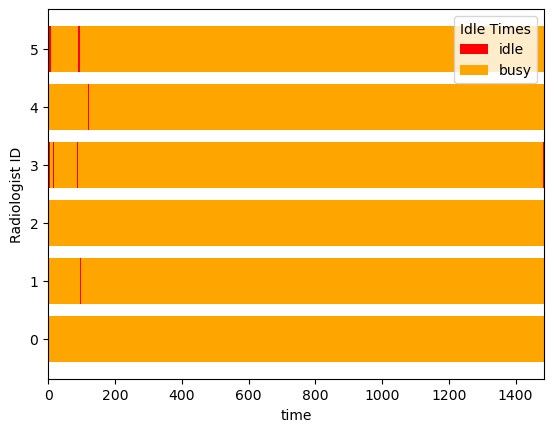

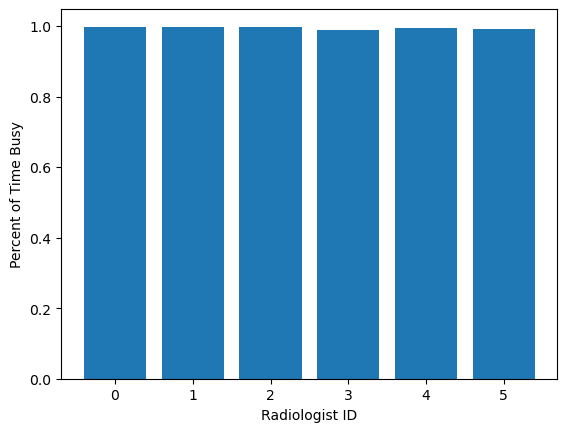

Radiologists were busy 0.994 of the time.


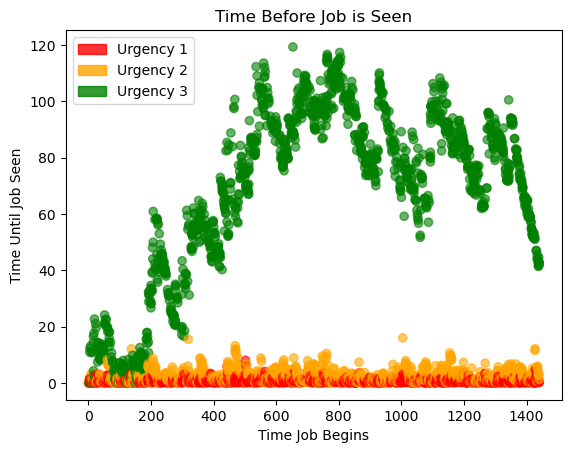

 
**********************************************************
 
Images arrive every 1.5 minutes.
2822 medical images
There are 0 that were not completed in time
Simulation complete at 1447.5943914515283 minutes


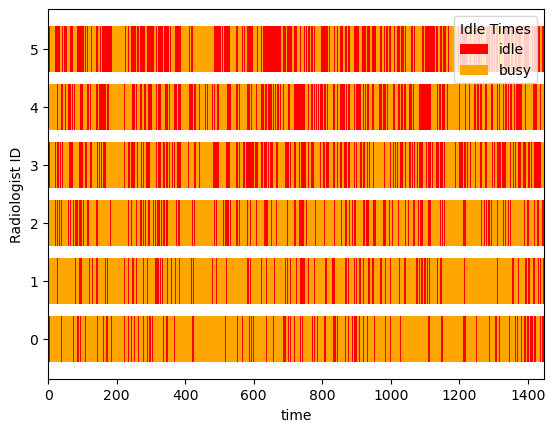

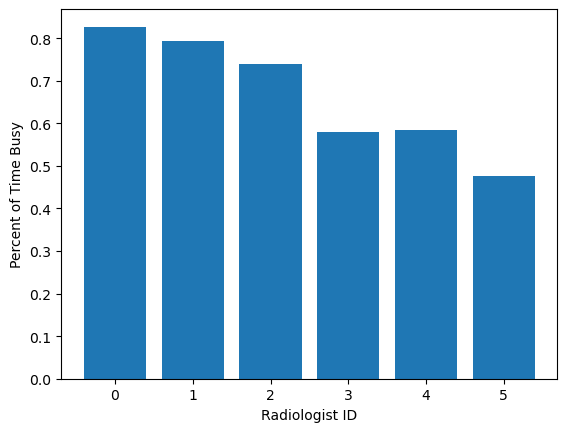

Radiologists were busy 0.666 of the time.


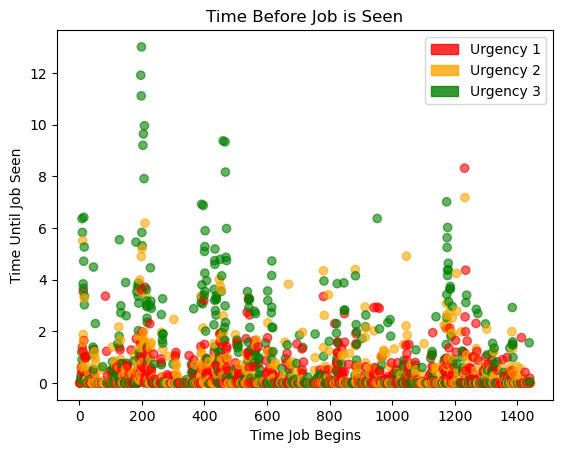

 
**********************************************************
 
Images arrive every 2.0 minutes.
2160 medical images
There are 0 that were not completed in time
Simulation complete at 1446.9903811475374 minutes


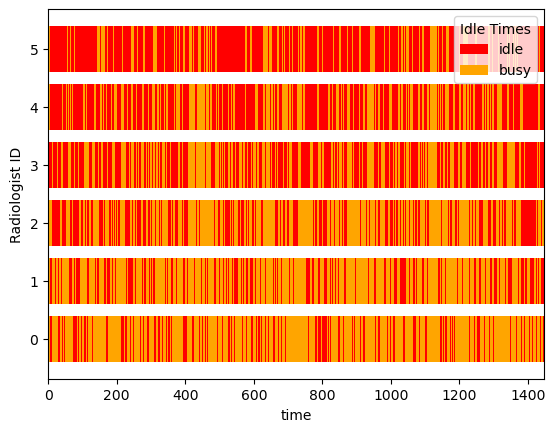

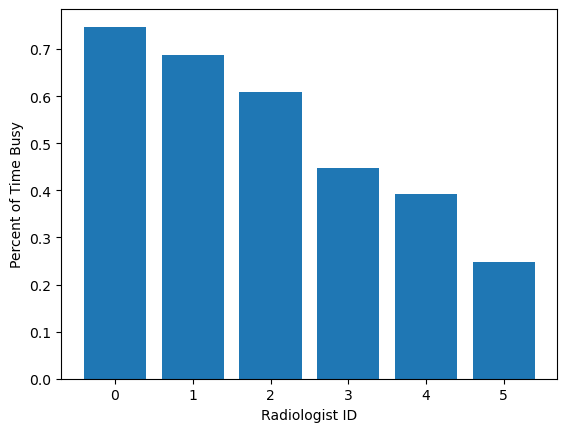

Radiologists were busy 0.522 of the time.


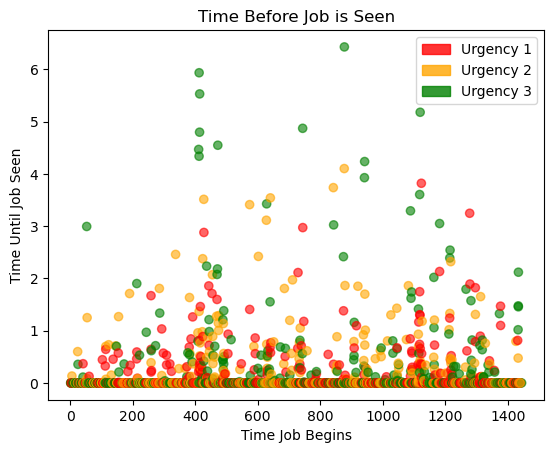

 
**********************************************************
 
Images arrive every 2.5 minutes.
1696 medical images
There are 0 that were not completed in time
Simulation complete at 1446.1176540922806 minutes


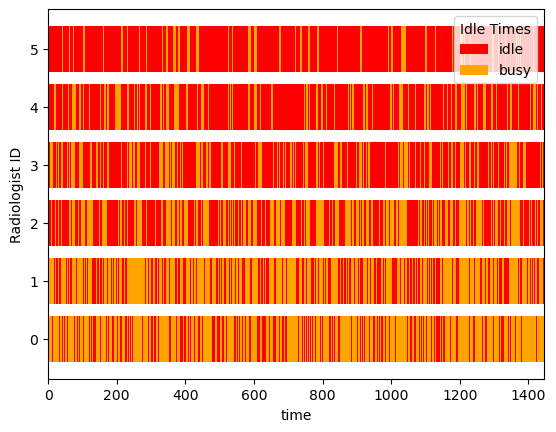

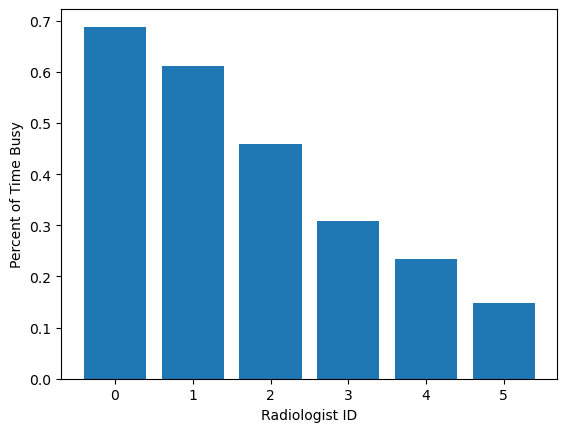

Radiologists were busy 0.408 of the time.


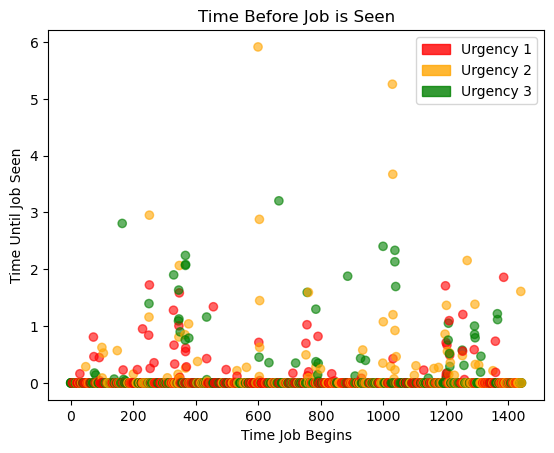

 
**********************************************************
 
Images arrive every 3.0 minutes.
1473 medical images
There are 0 that were not completed in time
Simulation complete at 1454.345832318166 minutes


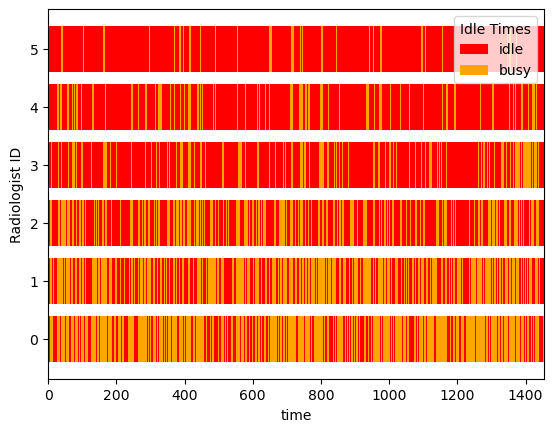

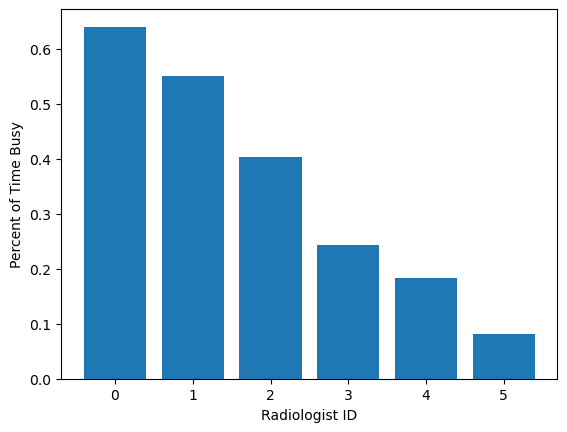

Radiologists were busy 0.351 of the time.


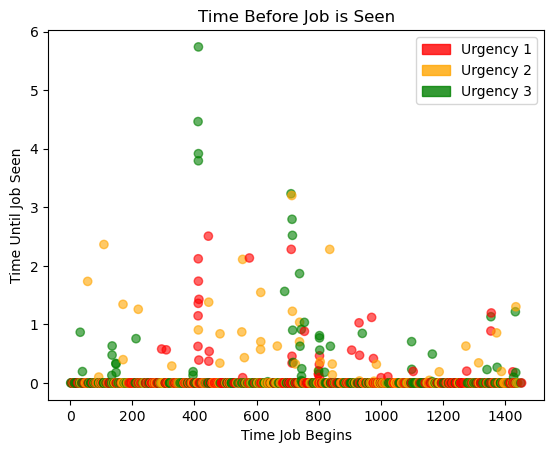

 
**********************************************************
 
Images arrive every 3.5 minutes.
1184 medical images
There are 0 that were not completed in time
Simulation complete at 1443.9785392165059 minutes


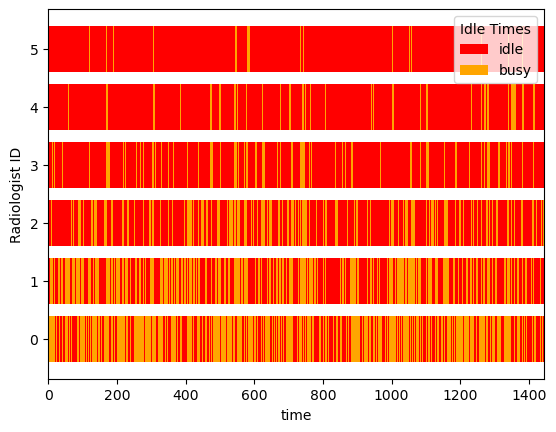

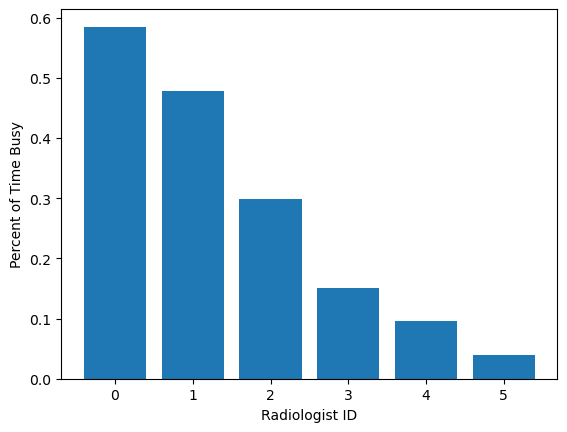

Radiologists were busy 0.275 of the time.


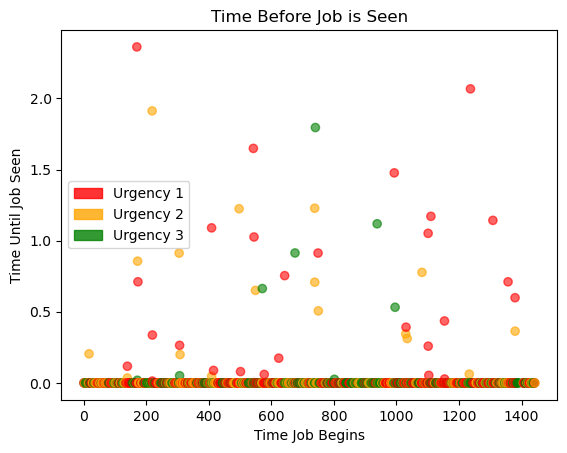

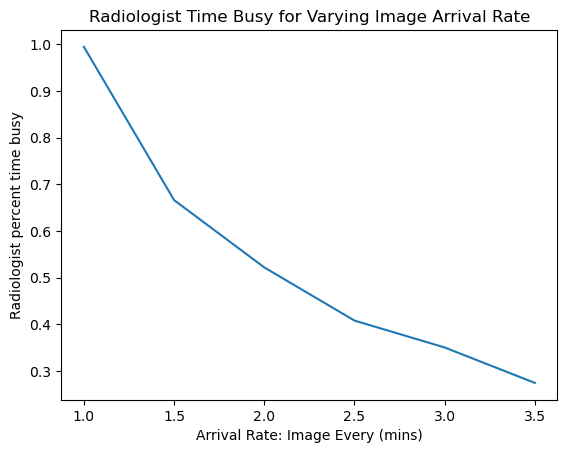

In [42]:
busy_times = {}
sims_dict = {}
create_constant_rads(6)
for arr_rate_var in np.arange(1, 4, 0.5):
    print(" ")
    print("**********************************************************")
    print(" ")
    print(f"Images arrive every {arr_rate_var} minutes.")
    #Define variables
    sim_time = 60*24
    rads_count = 6
    arr_rates = [arr_rate_var, arr_rate_var, arr_rate_var]
    urg_times = [10, 30, 120]
    process_times = [2, 2, 2]
    #run sim
    s_temp = sim(sim_time, rads_count, arr_rates, urg_times, process_times, constant_rads=True, cutoff=True, verbose=False)
    
    busy_times[arr_rate_var] = idle_plots(s_temp.rads)
    wait_time_plot(s_temp.img_table)
    sims_dict[arr_rate_var] = s_temp
plt.plot(busy_times.keys(), busy_times.values(), label=f"{rads_count} radiologists")
plt.xlabel("Arrival Rate: Image Every (mins)")
plt.ylabel("Radiologist percent time busy")
plt.title("Radiologist Time Busy for Varying Image Arrival Rate")
plt.show()

Time plots for images arriving avg every 1.0 mins


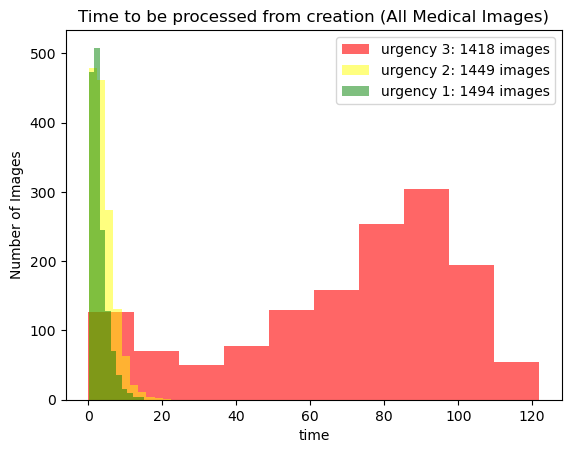

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.85096163655914
Urgency 2: 4.0425711526400345
Urgency 3: 69.81860572972931


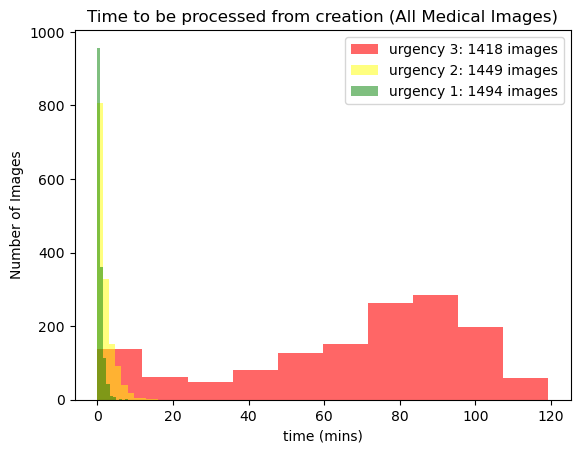

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.7812292282144819
Urgency 2: 2.042354718281828
Urgency 3: 67.79471312035507

_______________________________________________

Time plots for images arriving avg every 1.5 mins


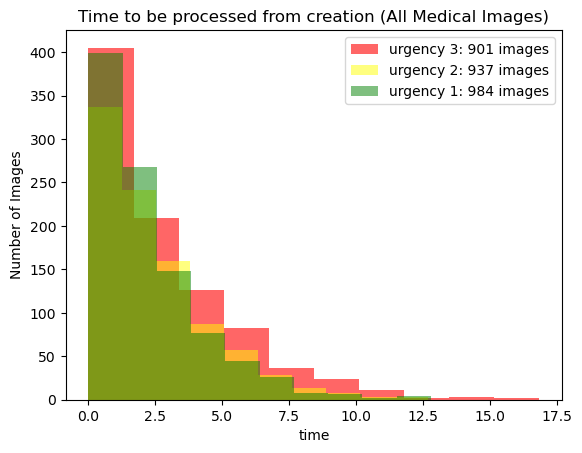

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.2353263376110144
Urgency 2: 2.464527783153471
Urgency 3: 2.84500949031241


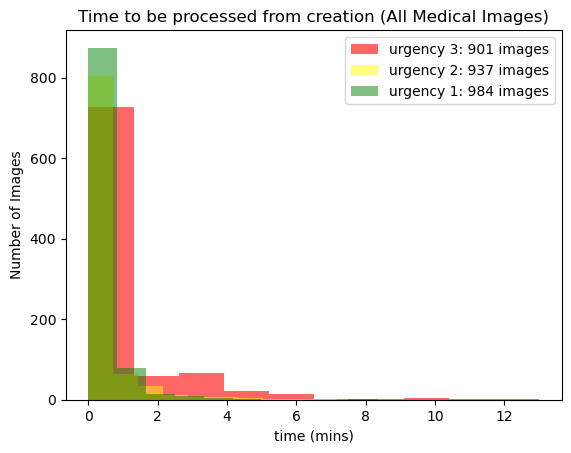

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2725250874611379
Urgency 2: 0.33430535956981305
Urgency 3: 0.7826830358792816

_______________________________________________

Time plots for images arriving avg every 2.0 mins


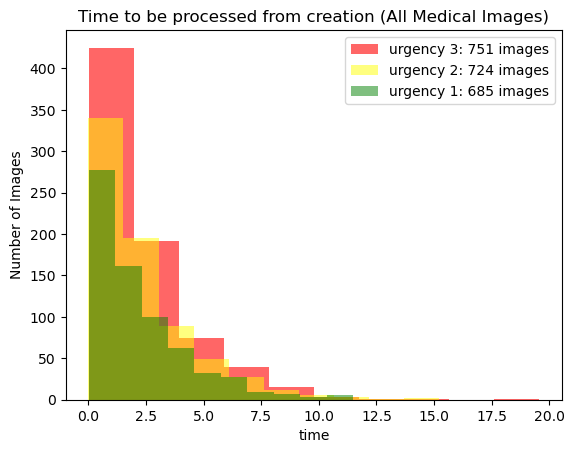

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.2098458568139594
Urgency 2: 2.315829590017659
Urgency 3: 2.2529002970901795


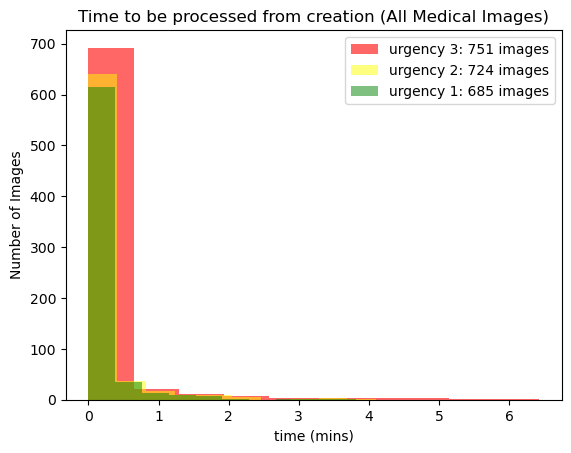

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.12693405377193087
Urgency 2: 0.15619468307332376
Urgency 3: 0.19918516379497633

_______________________________________________

Time plots for images arriving avg every 2.5 mins


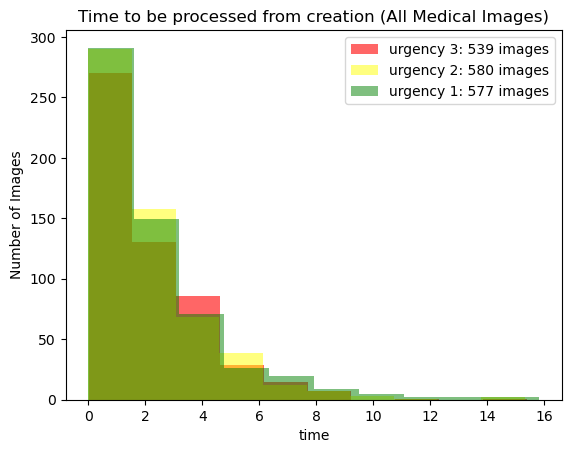

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.2766215727752455
Urgency 2: 2.113399137344098
Urgency 3: 2.105289242585204


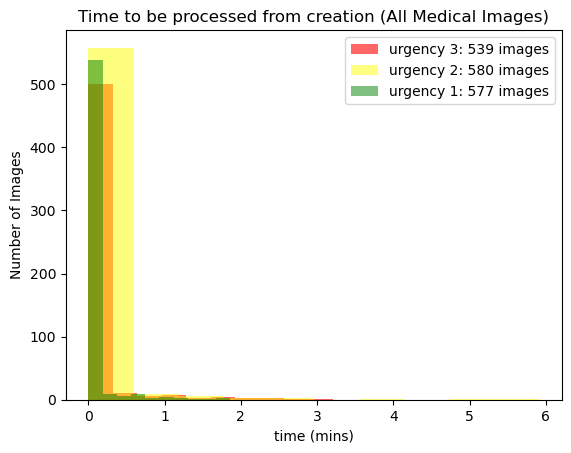

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.051929295275925595
Urgency 2: 0.08983645629737923
Urgency 3: 0.09190231900408743

_______________________________________________

Time plots for images arriving avg every 3.0 mins


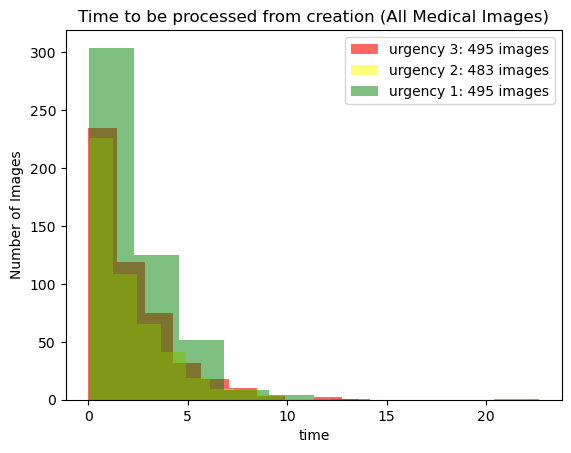

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.255964499842538
Urgency 2: 2.0345078296571635
Urgency 3: 2.154609959462808


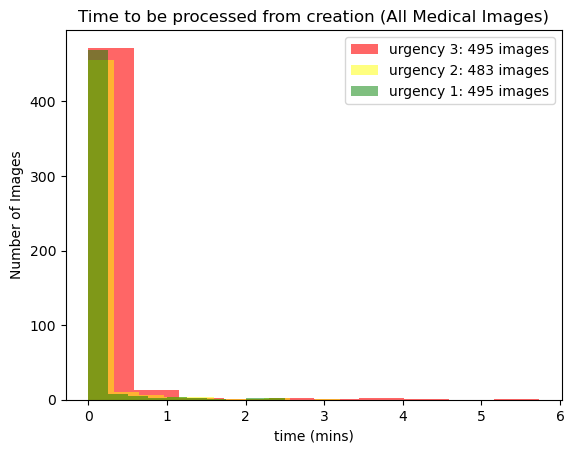

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.05490793608658539
Urgency 2: 0.06531298608316696
Urgency 3: 0.09480113402696971

_______________________________________________

Time plots for images arriving avg every 3.5 mins


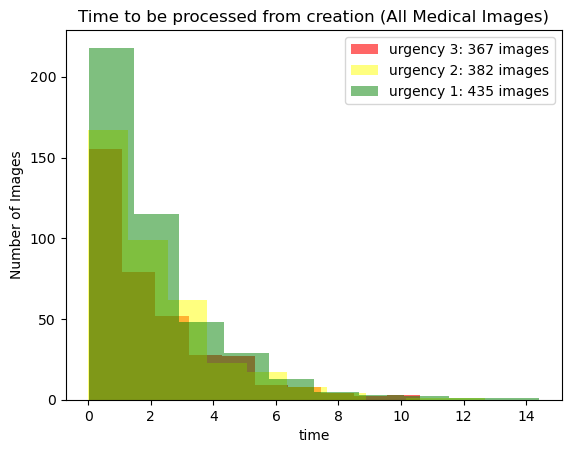

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0525569320003596
Urgency 2: 2.0120789436340245
Urgency 3: 2.0541060565430773


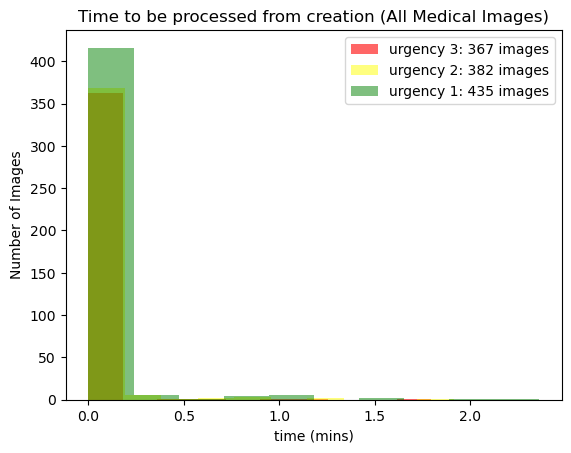

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.04372853374515231
Urgency 2: 0.02707221655482692
Urgency 3: 0.013942095786812833

_______________________________________________



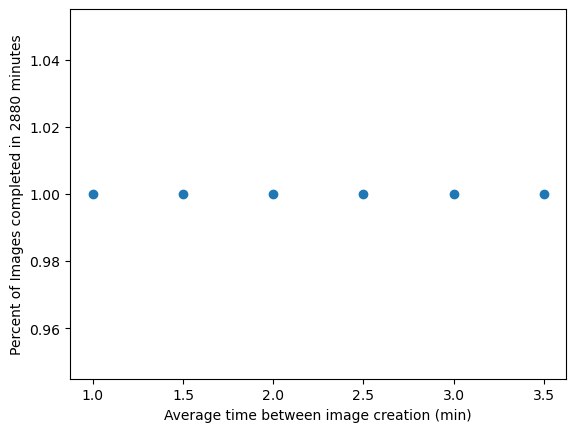

In [43]:
for arr_val, s in sims_dict.items():
    print(f"Time plots for images arriving avg every {round(arr_val,2)} mins")
    total_time_hist(s)
    wait_time_hist(s)
    print("")
    print("_______________________________________________")
    print("")
    
completion_plot(sims_dict)

In [44]:
for i in range(6):
    specs = sims_dict[list(sims_dict.keys())[0]].rads[i].specialties
    print(f"Rad {i} has specialties: {specs}")

Rad 0 has specialties: [1, 5, 2, 4]
Rad 1 has specialties: [2, 4, 3, 1]
Rad 2 has specialties: [2, 5, 4, 1]
Rad 3 has specialties: [3, 5]
Rad 4 has specialties: [1, 4, 3]
Rad 5 has specialties: [5, 1, 4]


In [45]:
ex_img_table = sims_dict[list(sims_dict.keys())[2]].img_table
ex_img_table#[ex_img_table.create_time >=5].iloc[0]

img_id  radiologist  urgency  create_time    seen_time     finished  \
0        1.0          0.0      1.0     1.605356     1.605356     2.327503   
1        2.0          0.0      2.0     2.394918     2.394918     2.407116   
2        3.0          0.0      1.0     2.537207     2.537207     3.965139   
3        6.0          5.0      3.0     3.773125     3.773125     4.078139   
4        7.0          0.0      1.0     4.741629     4.741629     5.050543   
...      ...          ...      ...          ...          ...          ...   
2155  2154.0          0.0      2.0  1438.333536  1438.333536  1440.507163   
2156  2157.0          1.0      2.0  1440.186995  1440.186995  1440.991918   
2157  2158.0          0.0      1.0  1441.001510  1441.001510  1444.170402   
2158  2159.0          1.0      3.0  1444.158755  1444.158755  1444.683609   
2159  2156.0          2.0      2.0  1439.853521  1439.853521  1446.990381   

      img_wait_time  time_w_rad  total_time  on_time  success  
0               0.0    0.722147    0.722147      1.0      1.0  
1               0.0    0.012197    0.012197      1.0      1.0  
2               0.0    1.427932    1.427932      1.0      1.0  
3               0.0    0.305014    0.305014      1.0      1.0  
4               0.0    0.308914    0.308914      1.0      1.0  
...             ...         ...         ...      ...      ...  
2155            0.0    2.173627    2.173627      1.0      1.0  
2156            0.0    0.804923    0.804923      1.0      1.0  
2157            0.0    3.168893    3.168893      1.0      1.0  
2158            0.0    0.524854    0.524854      1.0      1.0  
2159            0.0    7.136860    7.136860      1.0      0.0  

[2160 rows x 11 columns]

2260 medical images
There are 786 that were not completed in time
Simulation complete at 597.9497882859392 minutes


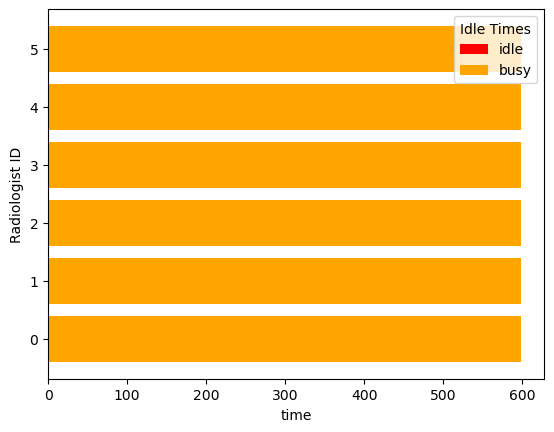

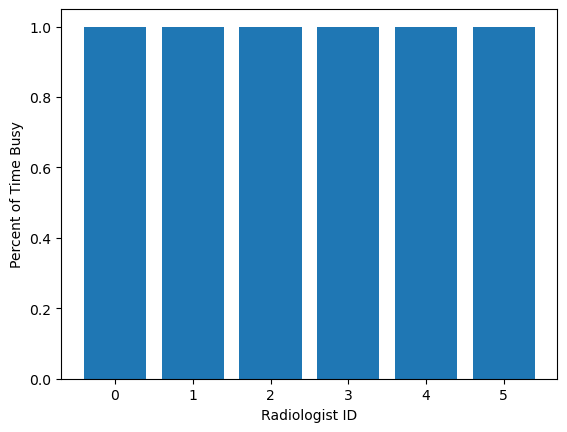

Radiologists were busy 0.999 of the time.
1758 medical images
There are 458 that were not completed in time
Simulation complete at 599.3621404865679 minutes


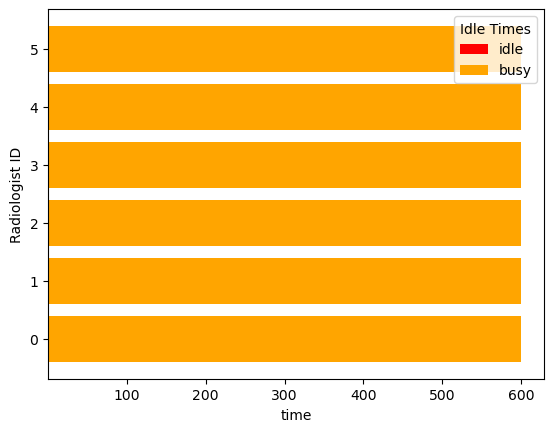

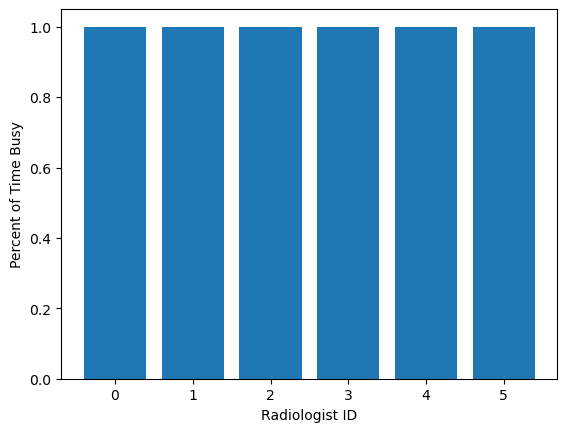

Radiologists were busy 0.999 of the time.
1441 medical images
There are 289 that were not completed in time
Simulation complete at 599.2874835183246 minutes


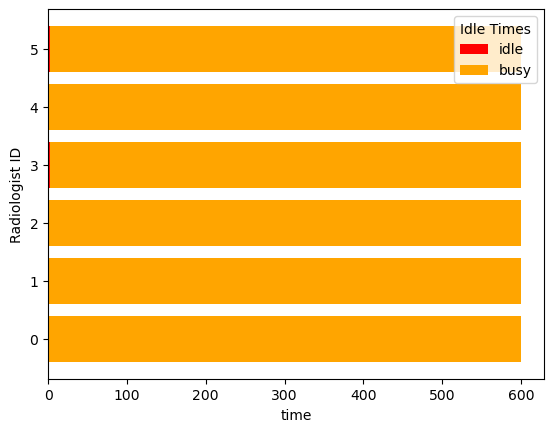

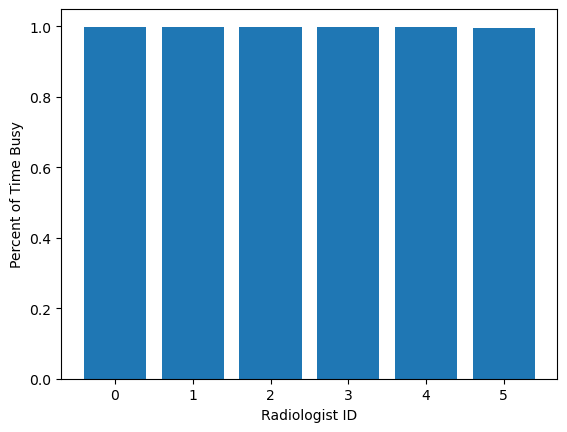

Radiologists were busy 0.998 of the time.
1283 medical images
There are 161 that were not completed in time
Simulation complete at 599.9896375580483 minutes


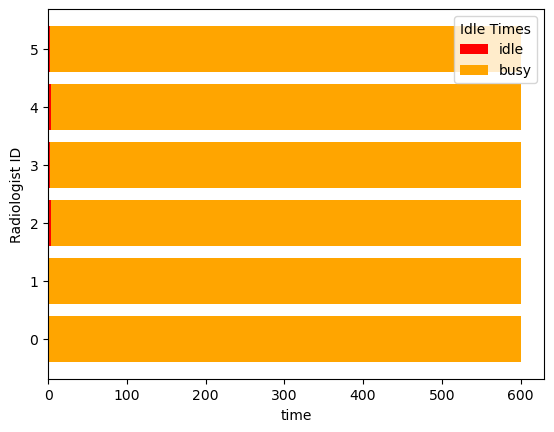

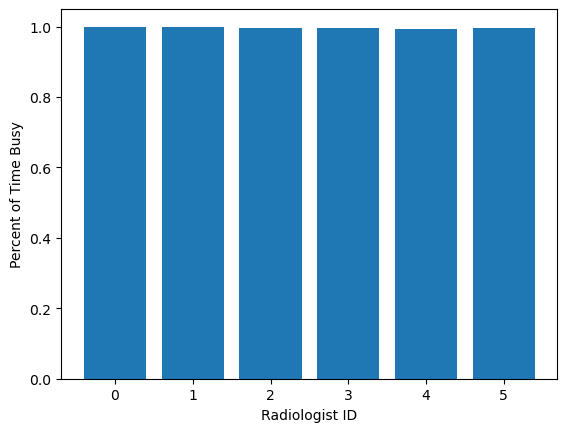

Radiologists were busy 0.997 of the time.
1176 medical images
There are 103 that were not completed in time
Simulation complete at 599.2026429642831 minutes


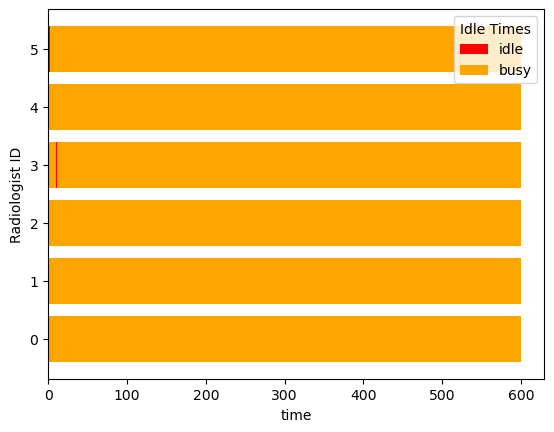

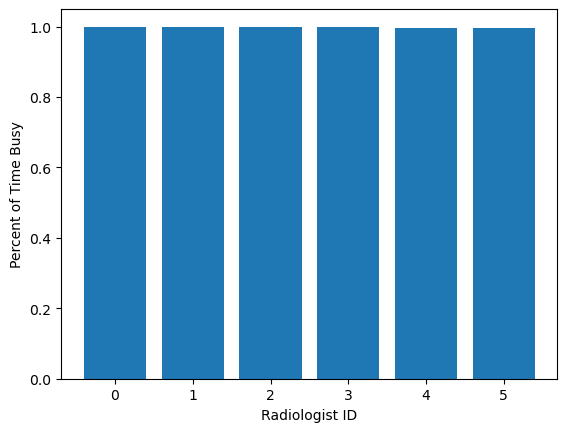

Radiologists were busy 0.998 of the time.
1060 medical images
There are 1 that were not completed in time
Simulation complete at 599.9971166377234 minutes


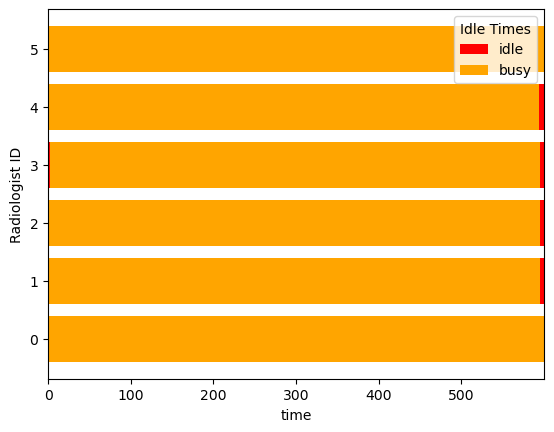

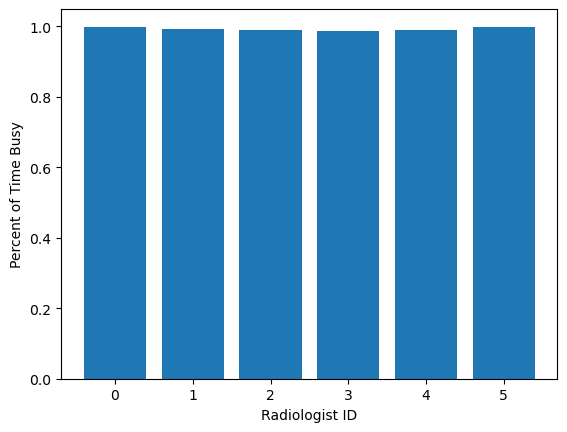

Radiologists were busy 0.993 of the time.
883 medical images
There are 0 that were not completed in time
Simulation complete at 521.3289772520498 minutes


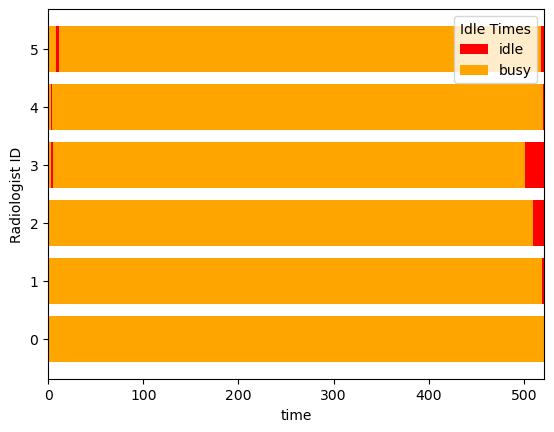

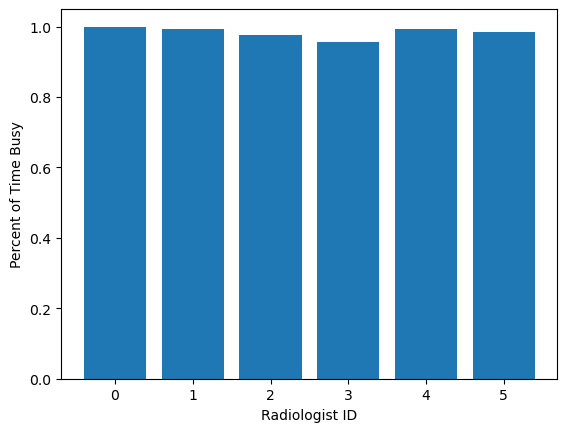

Radiologists were busy 0.984 of the time.
837 medical images
There are 0 that were not completed in time
Simulation complete at 374.54881465274946 minutes


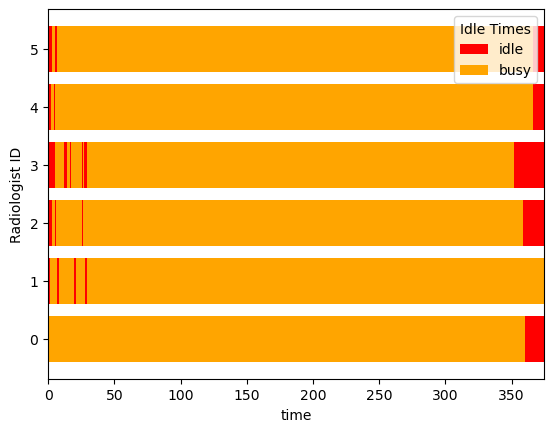

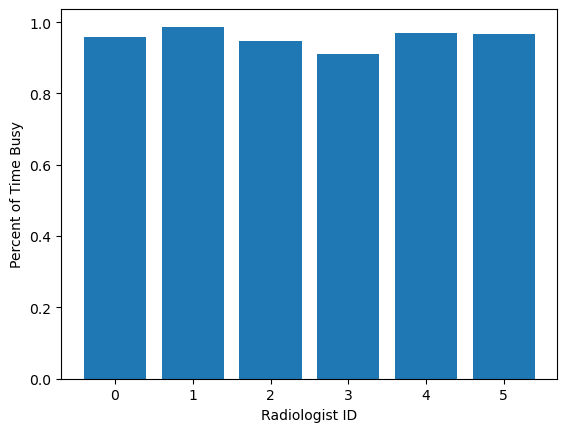

Radiologists were busy 0.956 of the time.
716 medical images
There are 0 that were not completed in time
Simulation complete at 419.8659252798963 minutes


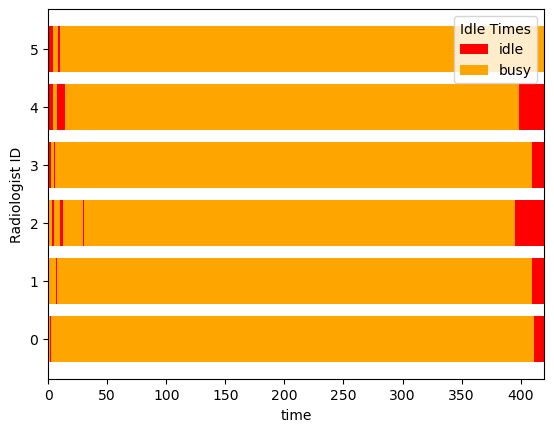

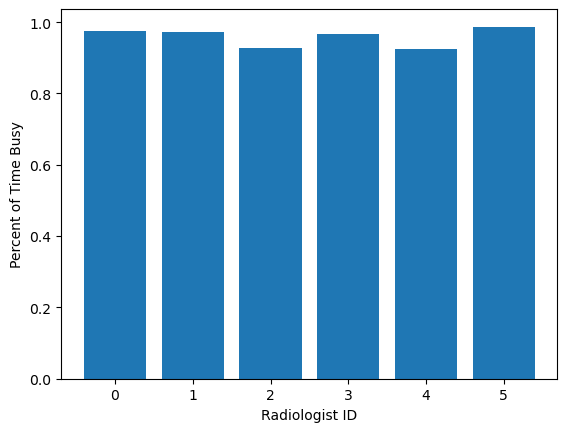

Radiologists were busy 0.958 of the time.
652 medical images
There are 0 that were not completed in time
Simulation complete at 383.02320925751974 minutes


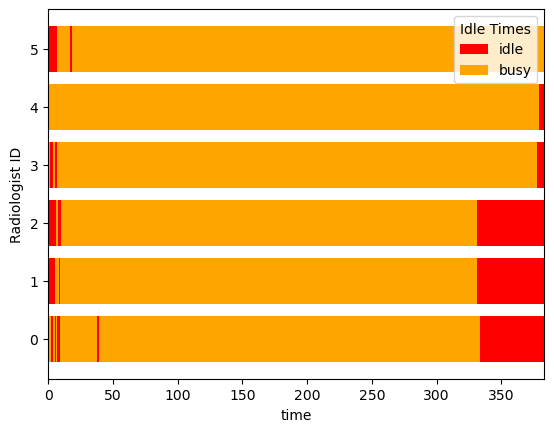

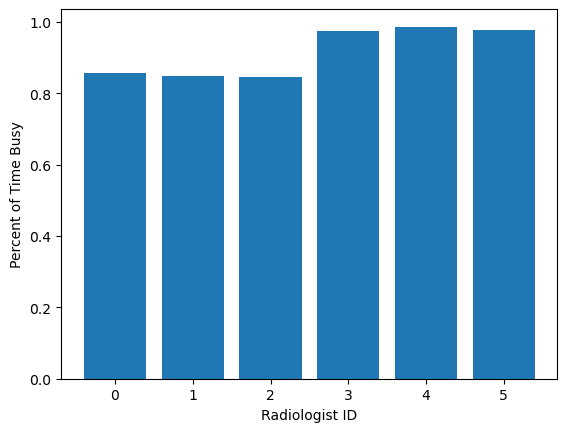

Radiologists were busy 0.915 of the time.
625 medical images
There are 0 that were not completed in time
Simulation complete at 524.0744787007922 minutes


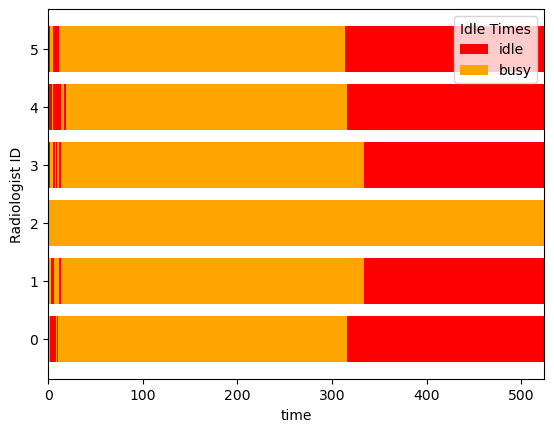

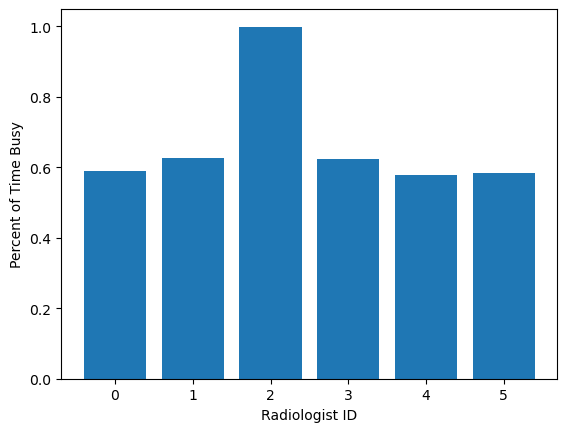

Radiologists were busy 0.666 of the time.
616 medical images
There are 0 that were not completed in time
Simulation complete at 354.00248740607714 minutes


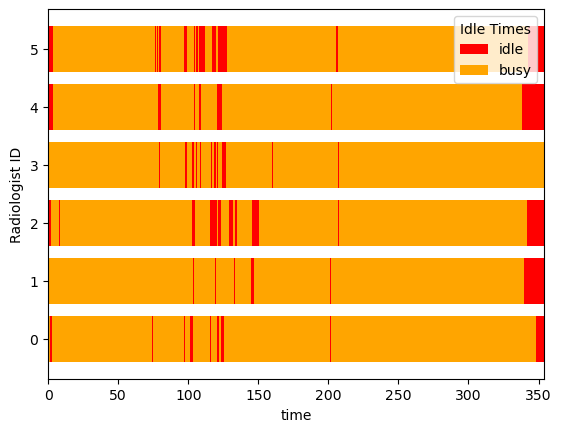

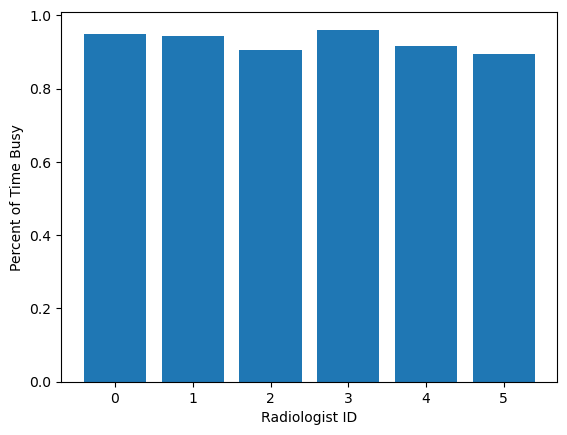

Radiologists were busy 0.928 of the time.
561 medical images
There are 0 that were not completed in time
Simulation complete at 434.20820762583037 minutes


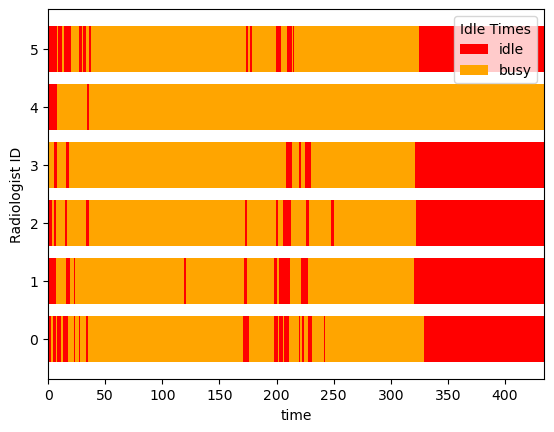

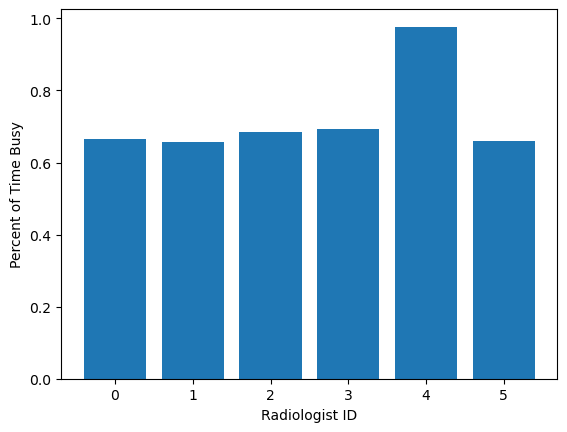

Radiologists were busy 0.723 of the time.
527 medical images
There are 0 that were not completed in time
Simulation complete at 358.68872887963164 minutes


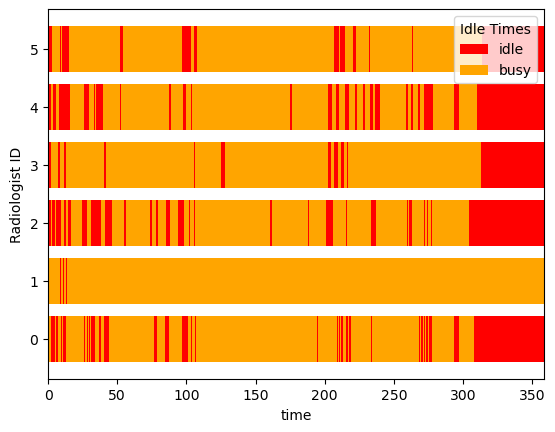

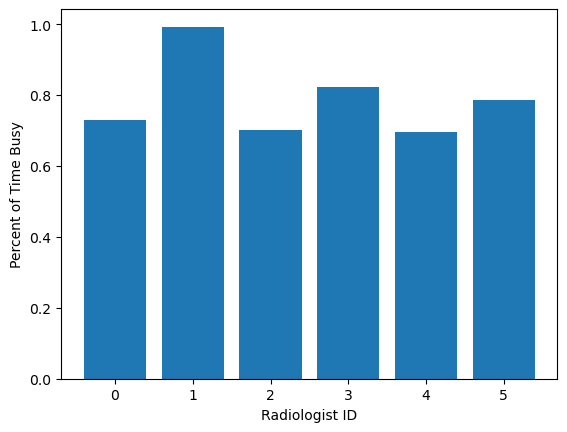

Radiologists were busy 0.788 of the time.
513 medical images
There are 0 that were not completed in time
Simulation complete at 305.8494711855909 minutes


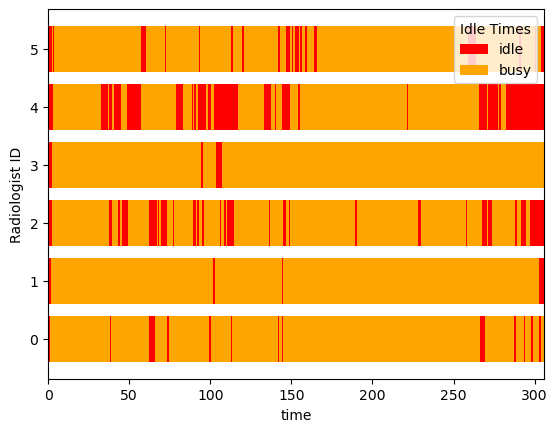

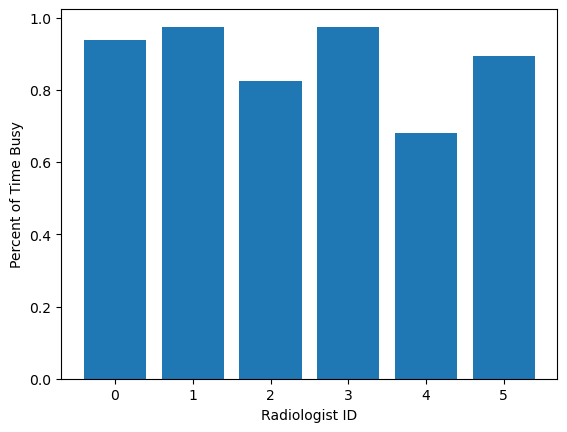

Radiologists were busy 0.881 of the time.
482 medical images
There are 0 that were not completed in time
Simulation complete at 318.1615626652404 minutes


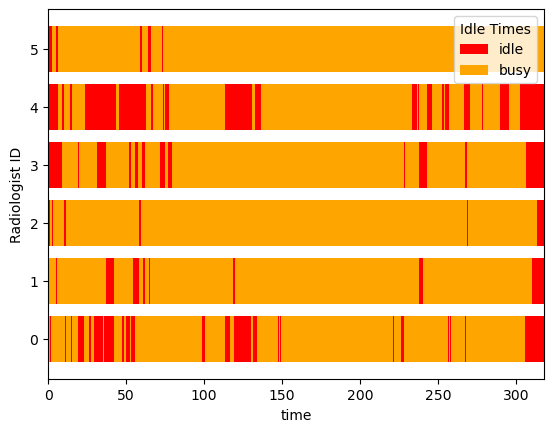

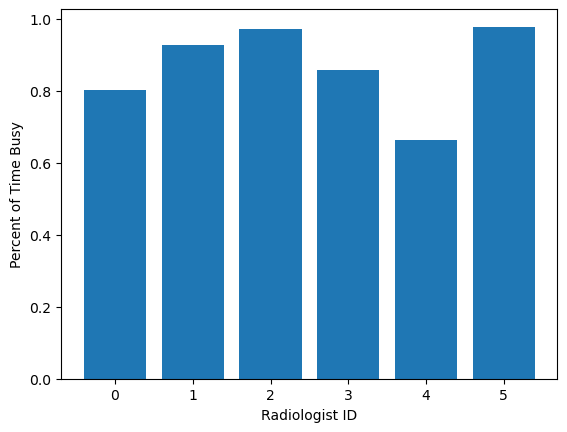

Radiologists were busy 0.866 of the time.
469 medical images
There are 0 that were not completed in time
Simulation complete at 310.48065877268164 minutes


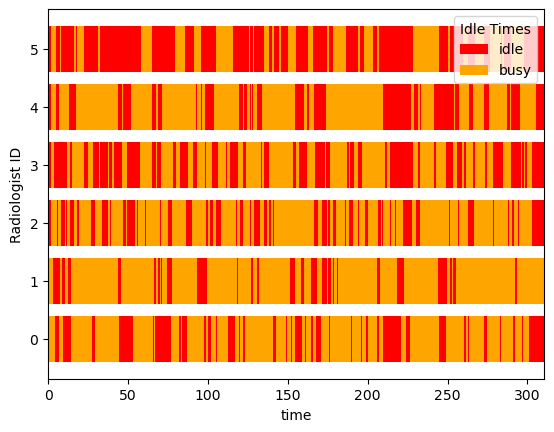

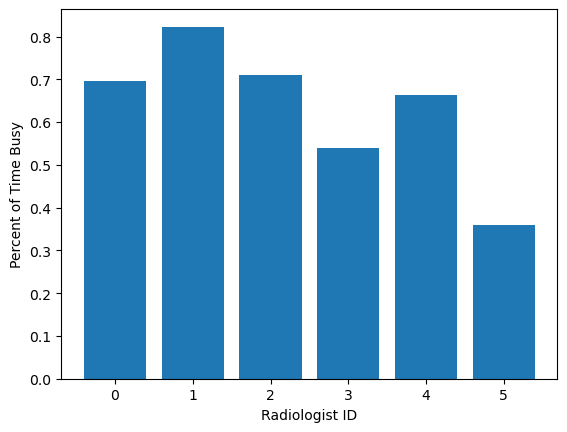

Radiologists were busy 0.632 of the time.
428 medical images
There are 0 that were not completed in time
Simulation complete at 315.05198121267046 minutes


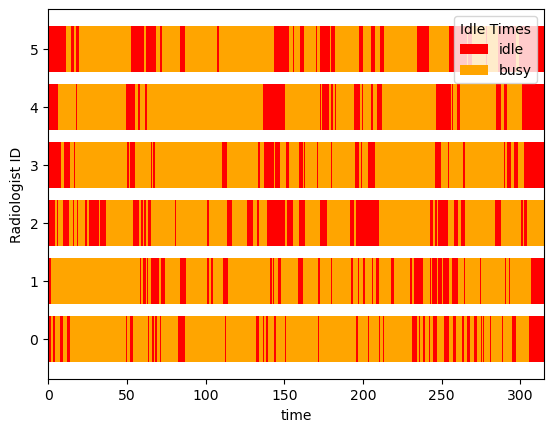

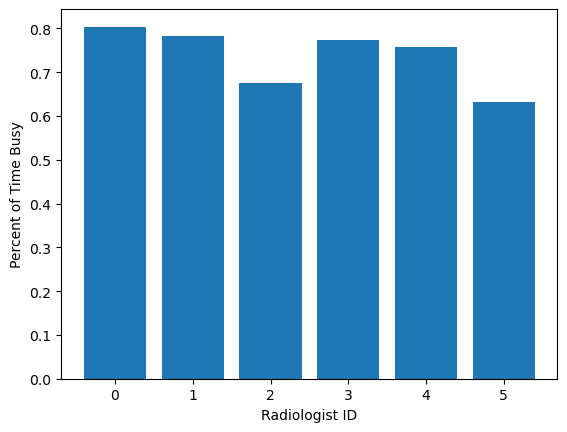

Radiologists were busy 0.737 of the time.
415 medical images
There are 0 that were not completed in time
Simulation complete at 314.9256607702229 minutes


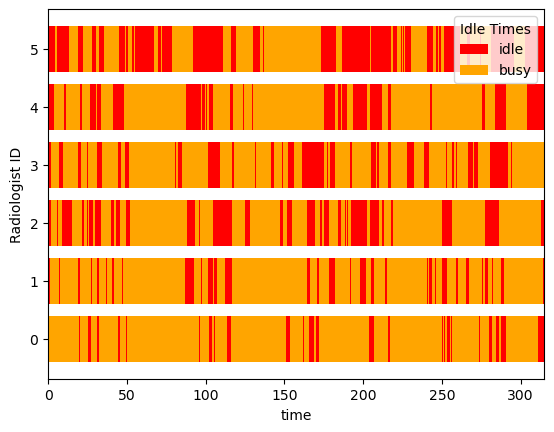

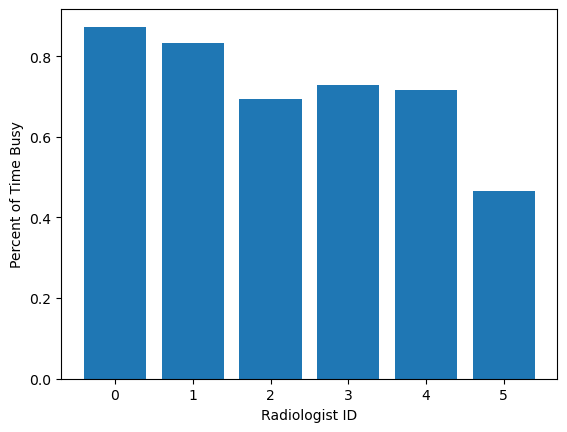

Radiologists were busy 0.718 of the time.
379 medical images
There are 0 that were not completed in time
Simulation complete at 309.2859956969639 minutes


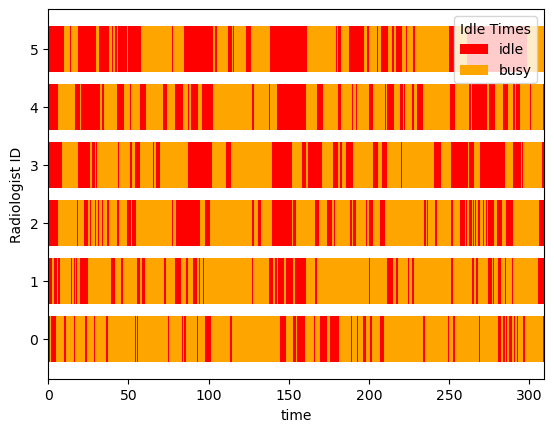

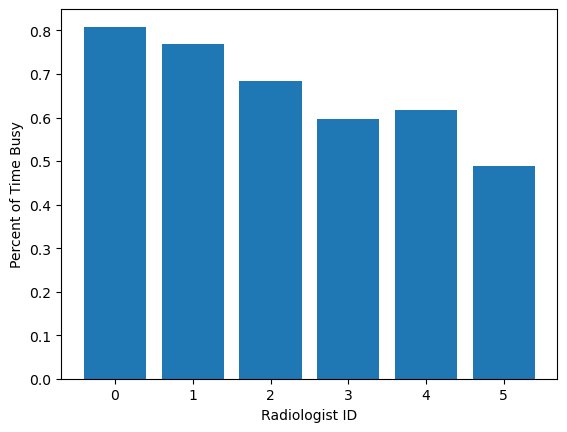

Radiologists were busy 0.661 of the time.
375 medical images
There are 0 that were not completed in time
Simulation complete at 310.03701100313515 minutes


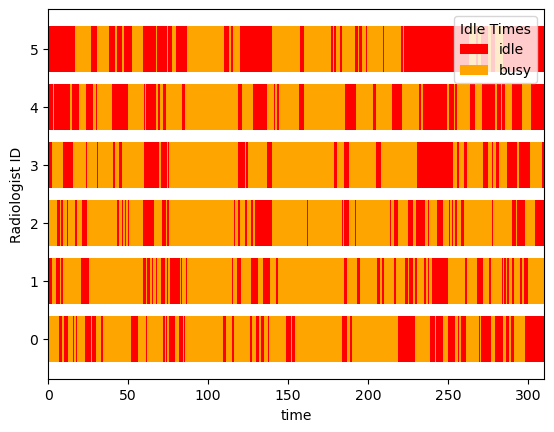

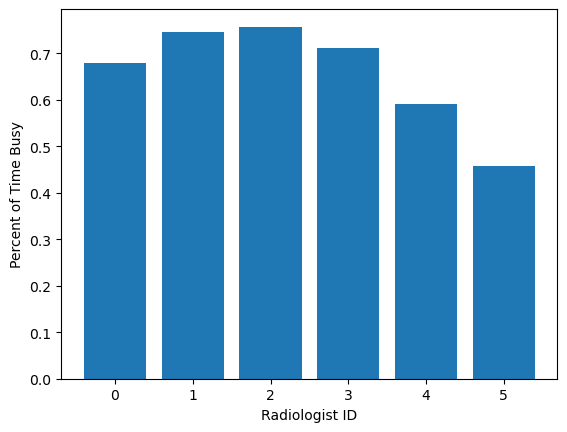

Radiologists were busy 0.657 of the time.
355 medical images
There are 0 that were not completed in time
Simulation complete at 315.55062848392157 minutes


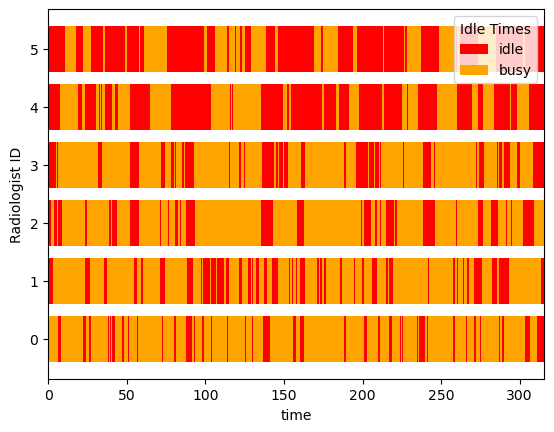

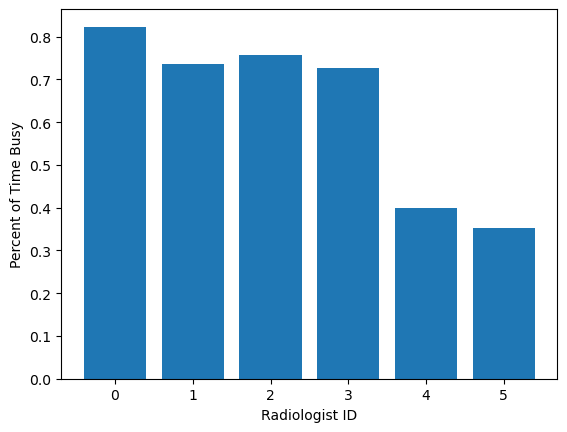

Radiologists were busy 0.633 of the time.
343 medical images
There are 0 that were not completed in time
Simulation complete at 306.7961830176558 minutes


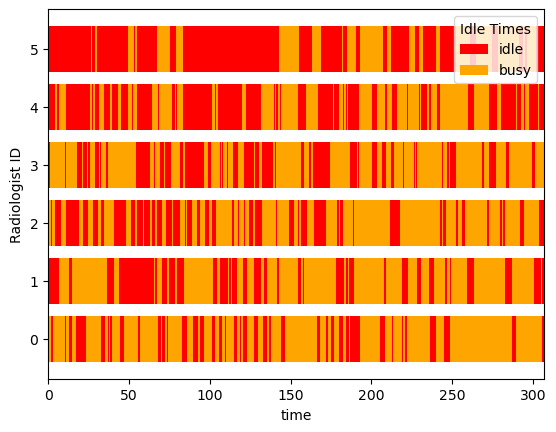

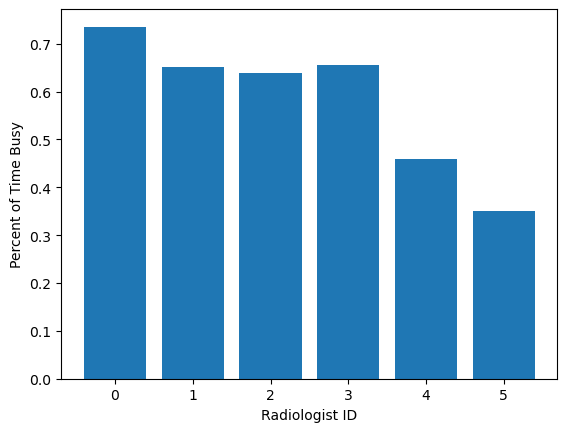

Radiologists were busy 0.582 of the time.
344 medical images
There are 0 that were not completed in time
Simulation complete at 315.3038493681755 minutes


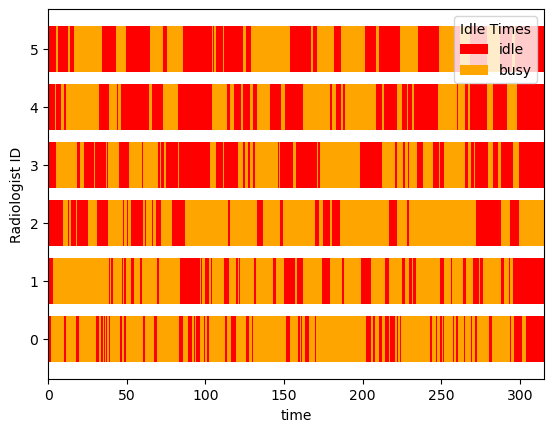

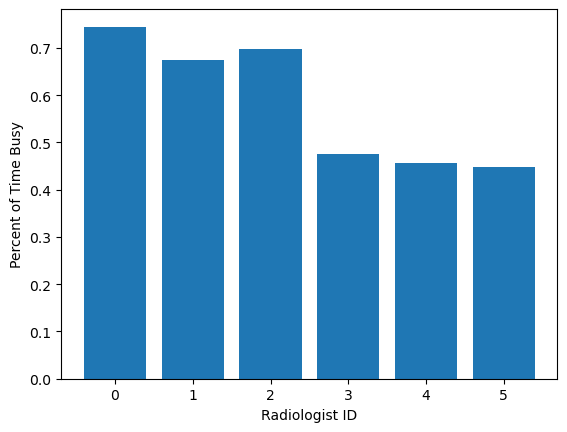

Radiologists were busy 0.583 of the time.
327 medical images
There are 0 that were not completed in time
Simulation complete at 308.7048660692161 minutes


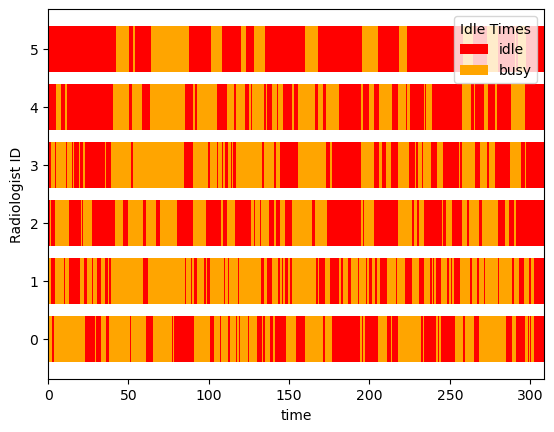

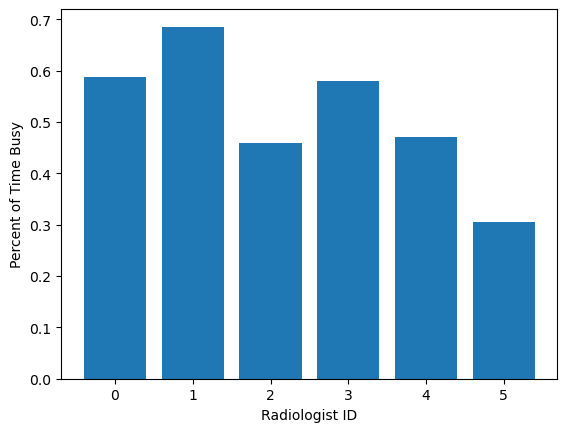

Radiologists were busy 0.515 of the time.
333 medical images
There are 0 that were not completed in time
Simulation complete at 310.8838221681454 minutes


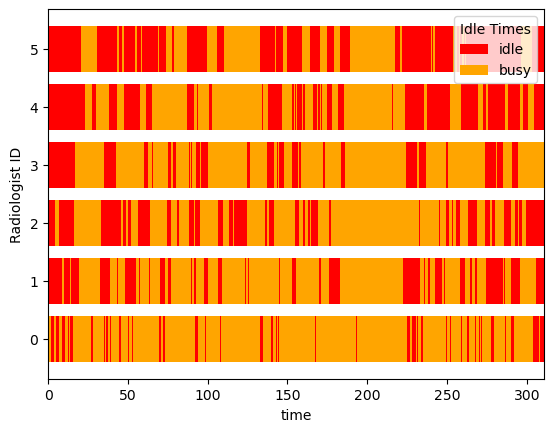

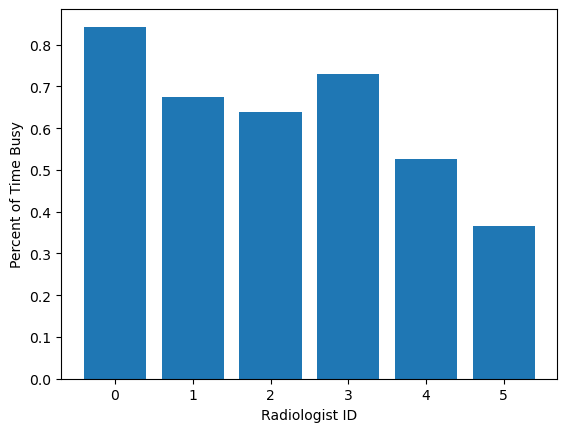

Radiologists were busy 0.629 of the time.
300 medical images
There are 0 that were not completed in time
Simulation complete at 313.27983775414754 minutes


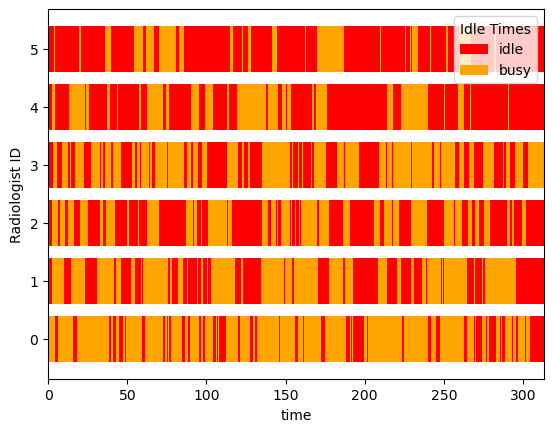

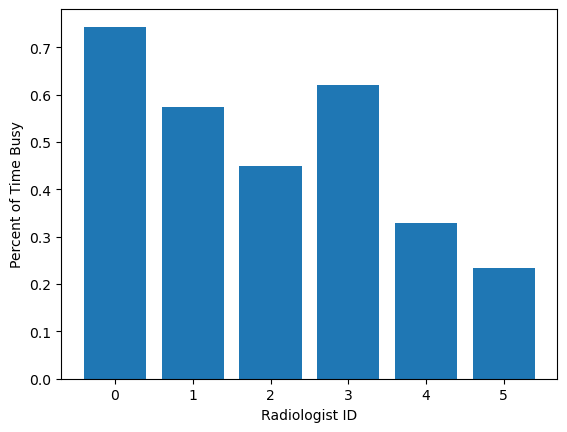

Radiologists were busy 0.492 of the time.
319 medical images
There are 0 that were not completed in time
Simulation complete at 312.99344650421983 minutes


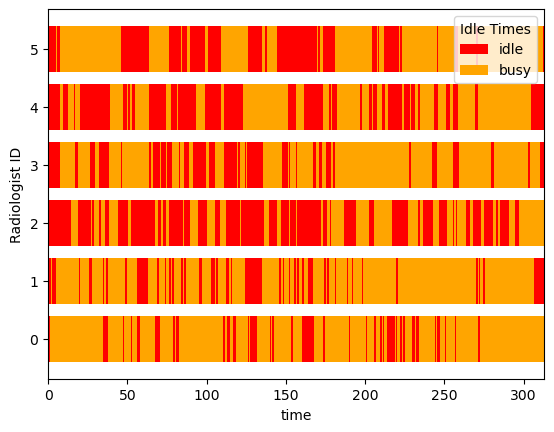

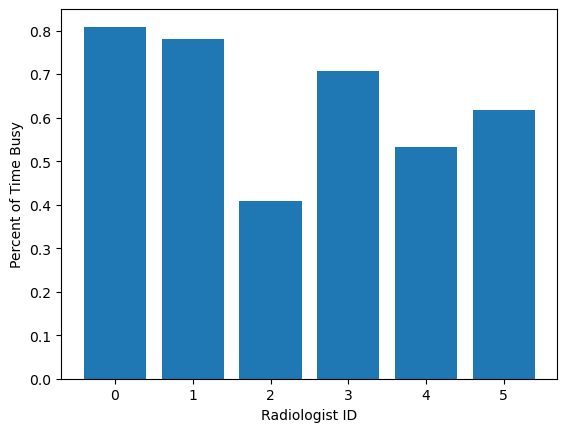

Radiologists were busy 0.642 of the time.
333 medical images
There are 0 that were not completed in time
Simulation complete at 311.272237040346 minutes


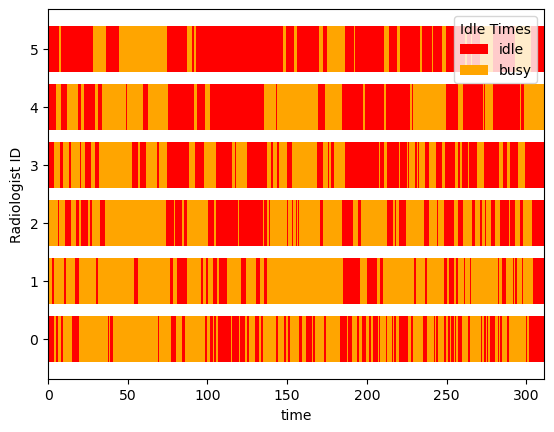

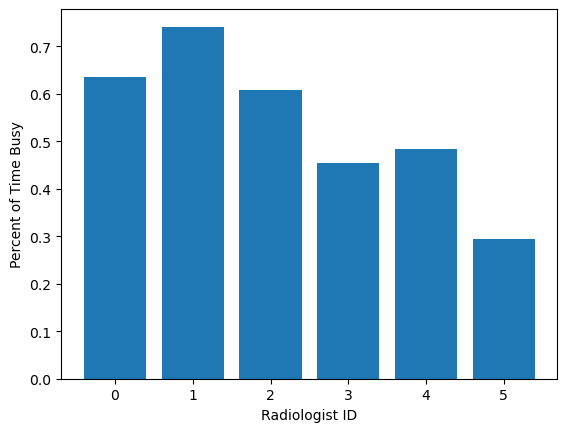

Radiologists were busy 0.536 of the time.
256 medical images
There are 0 that were not completed in time
Simulation complete at 307.943805708978 minutes


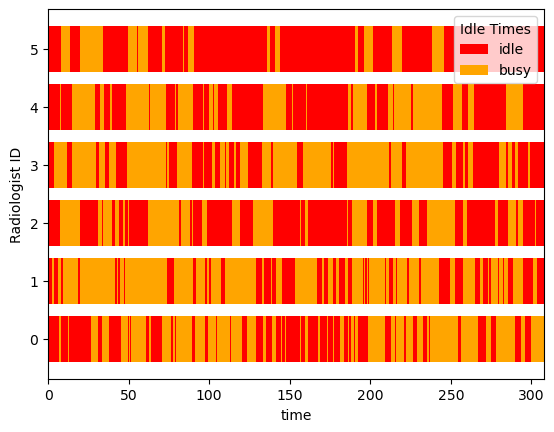

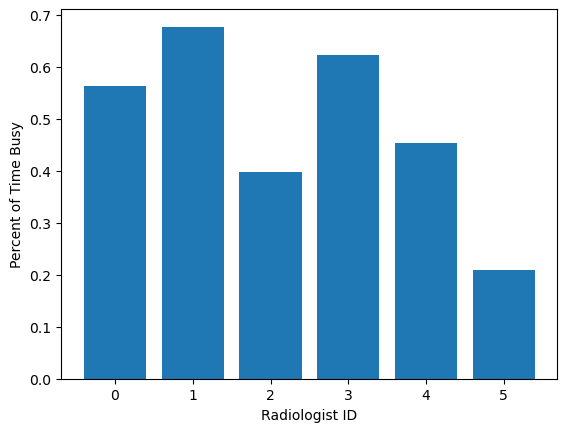

Radiologists were busy 0.487 of the time.
254 medical images
There are 0 that were not completed in time
Simulation complete at 310.2750447347018 minutes


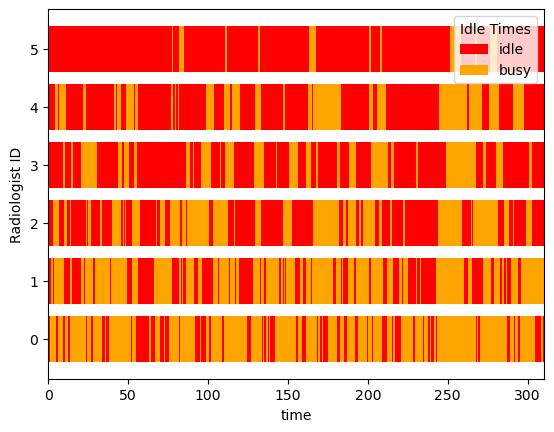

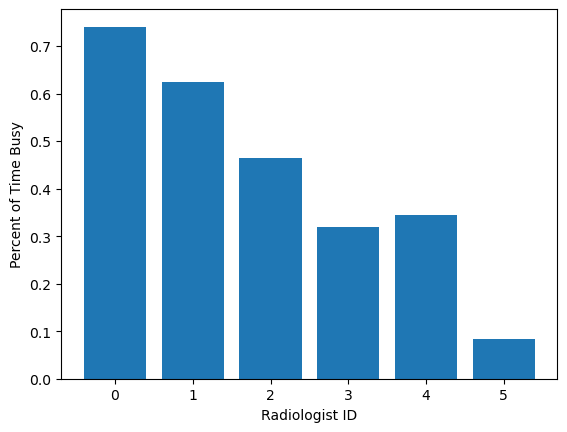

Radiologists were busy 0.429 of the time.
257 medical images
There are 0 that were not completed in time
Simulation complete at 306.6857314509422 minutes


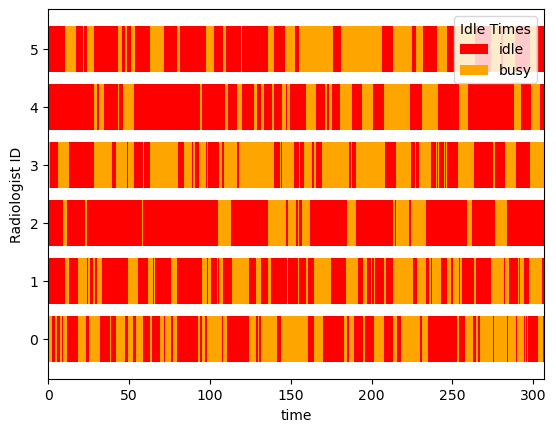

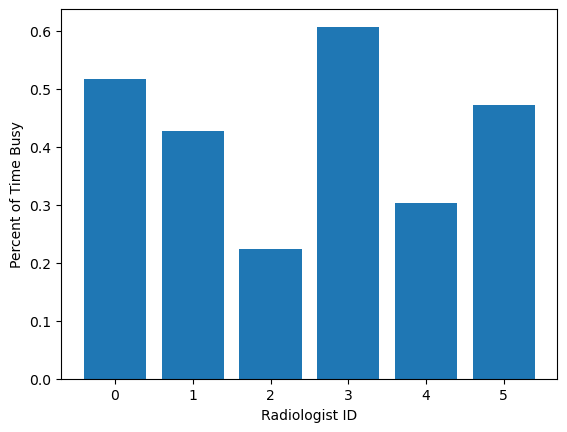

Radiologists were busy 0.426 of the time.
244 medical images
There are 0 that were not completed in time
Simulation complete at 308.974850026524 minutes


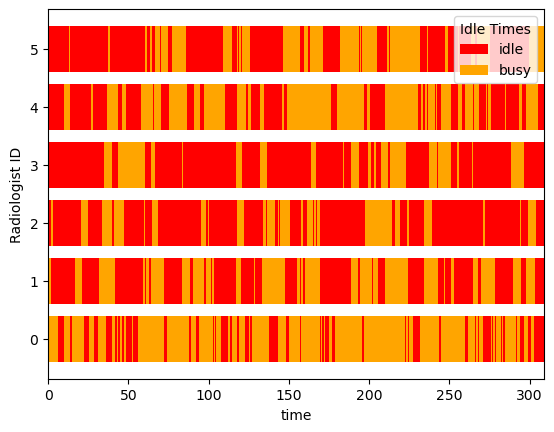

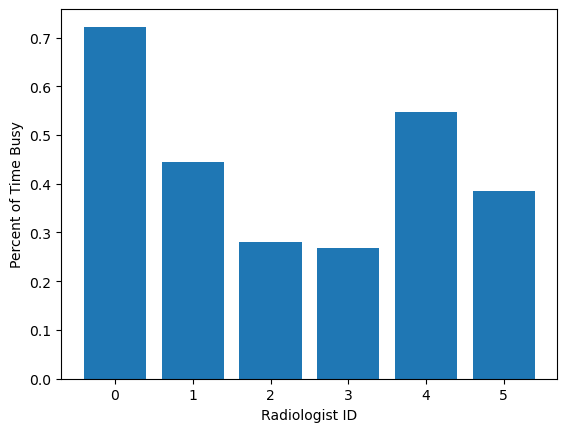

Radiologists were busy 0.441 of the time.
229 medical images
There are 0 that were not completed in time
Simulation complete at 312.19092421371255 minutes


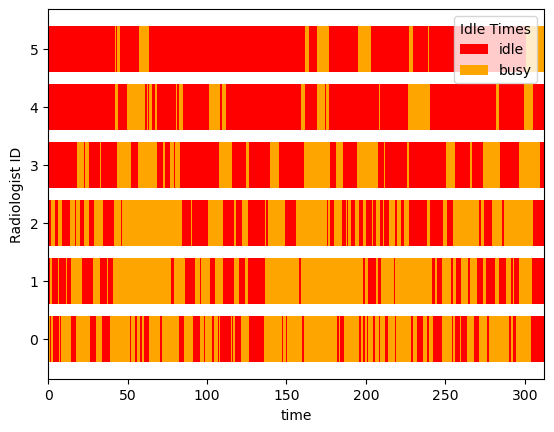

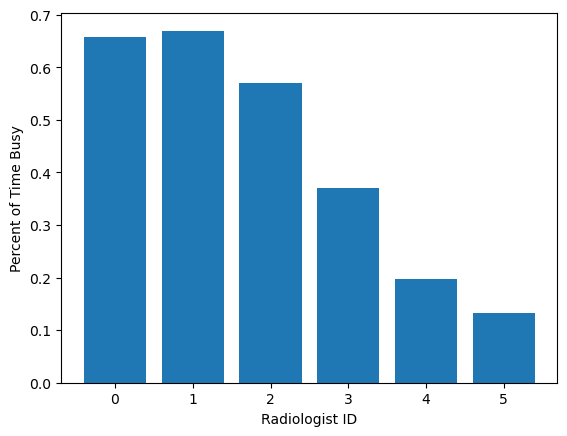

Radiologists were busy 0.433 of the time.
250 medical images
There are 0 that were not completed in time
Simulation complete at 319.7388072828656 minutes


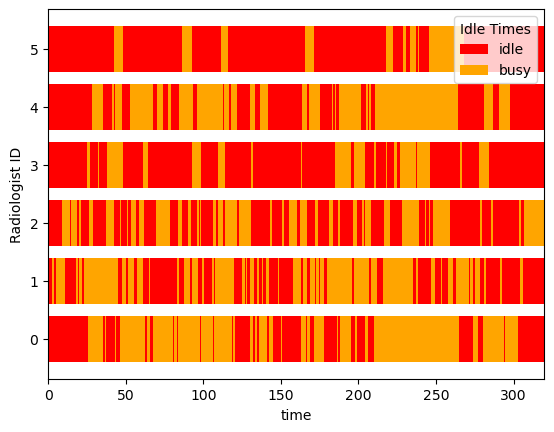

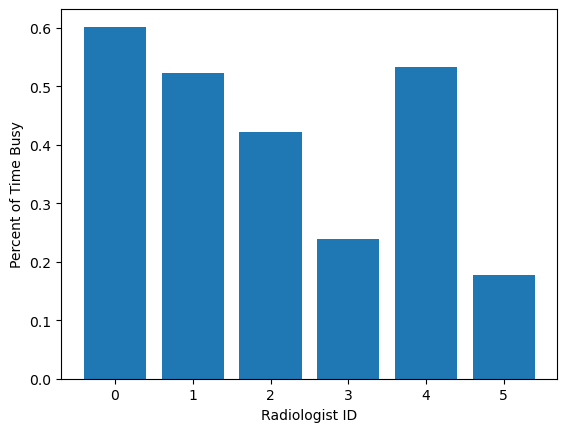

Radiologists were busy 0.416 of the time.
236 medical images
There are 0 that were not completed in time
Simulation complete at 306.7383947680841 minutes


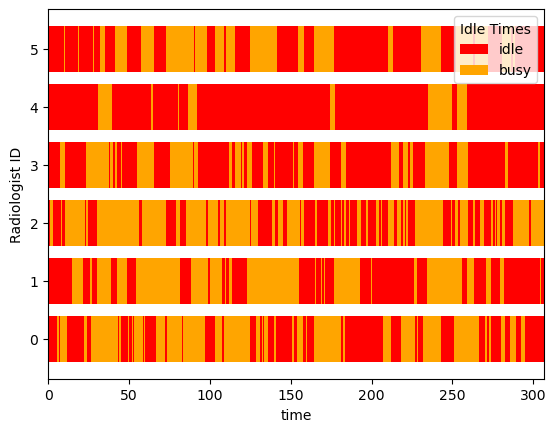

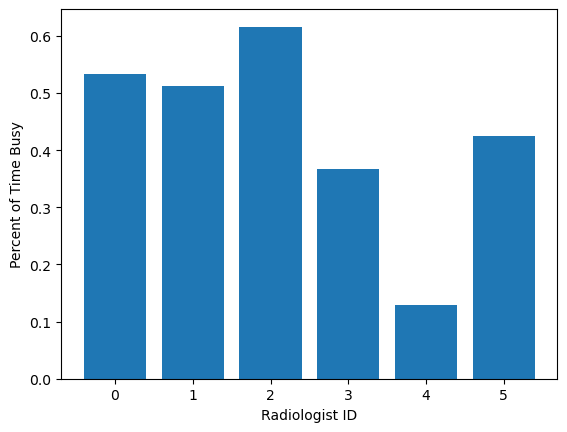

Radiologists were busy 0.43 of the time.
235 medical images
There are 0 that were not completed in time
Simulation complete at 305.48036037679657 minutes


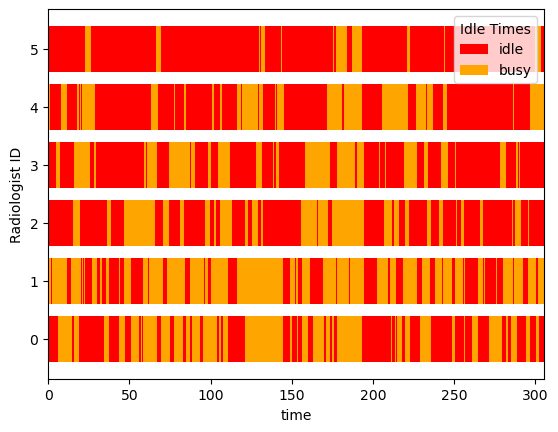

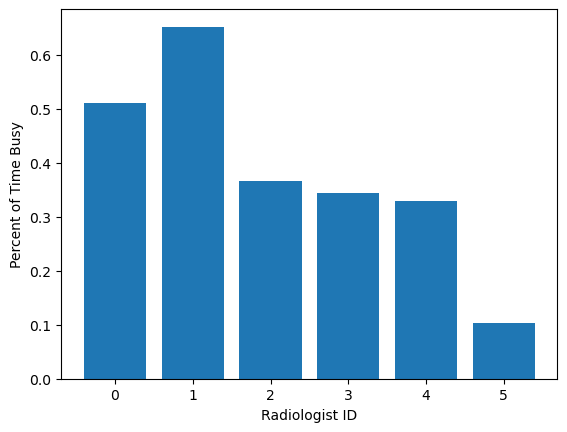

Radiologists were busy 0.384 of the time.
229 medical images
There are 0 that were not completed in time
Simulation complete at 310.3142190141526 minutes


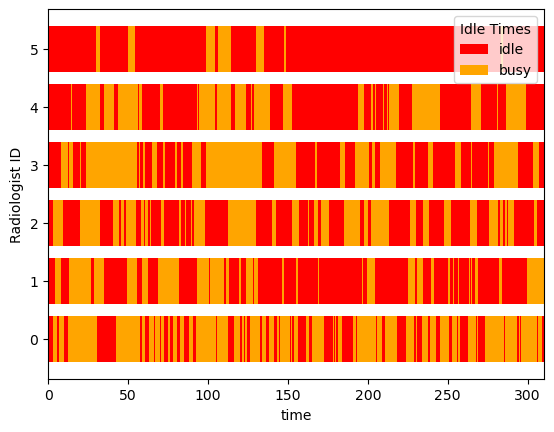

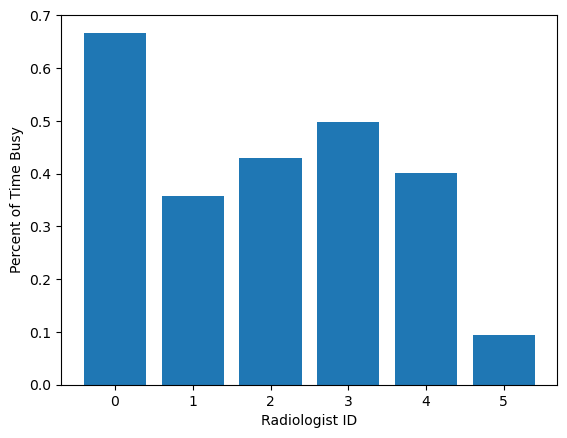

Radiologists were busy 0.408 of the time.
201 medical images
There are 0 that were not completed in time
Simulation complete at 310.4207624333927 minutes


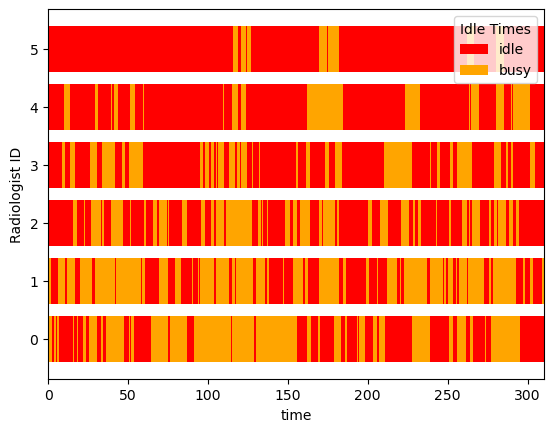

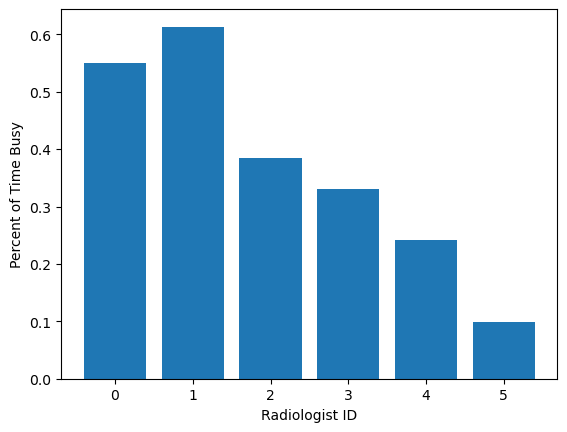

Radiologists were busy 0.37 of the time.
223 medical images
There are 0 that were not completed in time
Simulation complete at 314.74748887793027 minutes


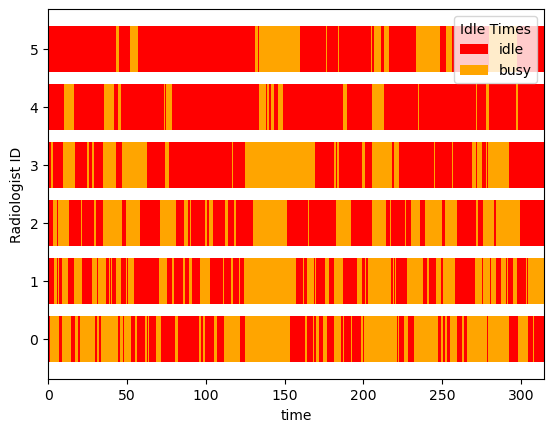

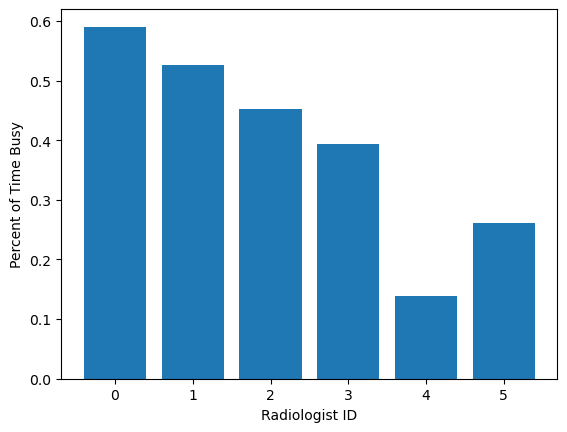

Radiologists were busy 0.394 of the time.
204 medical images
There are 0 that were not completed in time
Simulation complete at 308.2755859389327 minutes


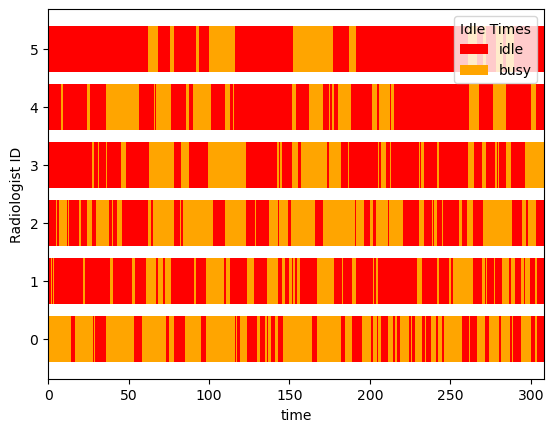

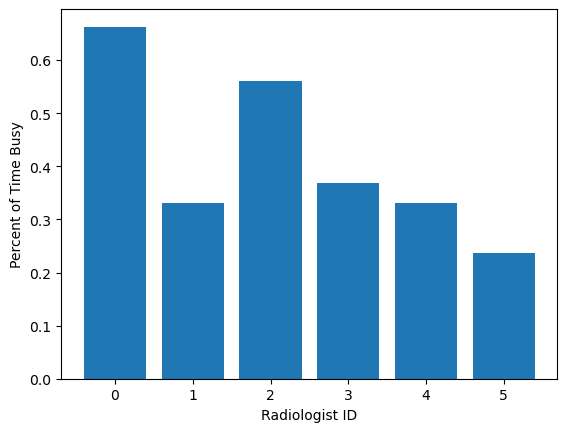

Radiologists were busy 0.415 of the time.
211 medical images
There are 0 that were not completed in time
Simulation complete at 305.75410753061016 minutes


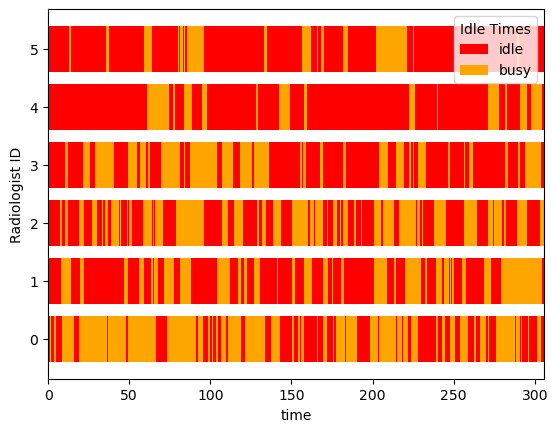

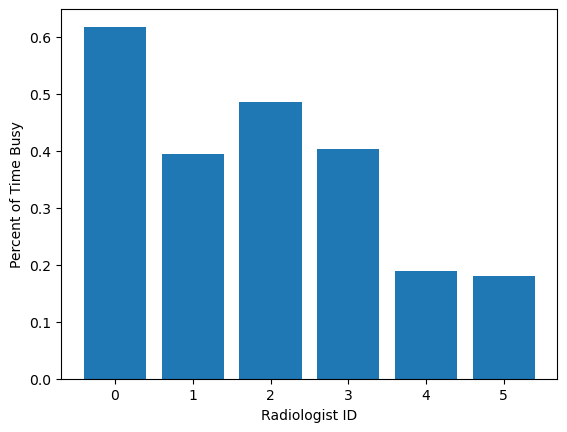

Radiologists were busy 0.378 of the time.
197 medical images
There are 0 that were not completed in time
Simulation complete at 315.99466496961367 minutes


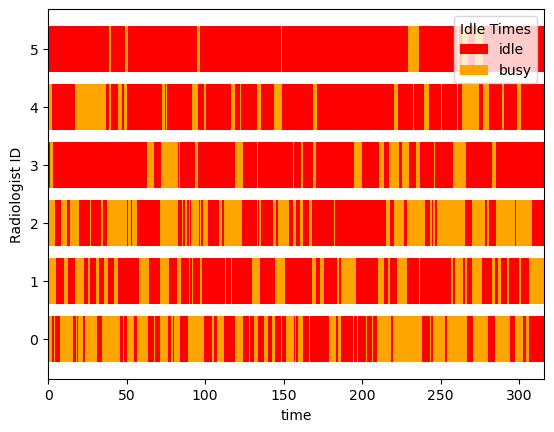

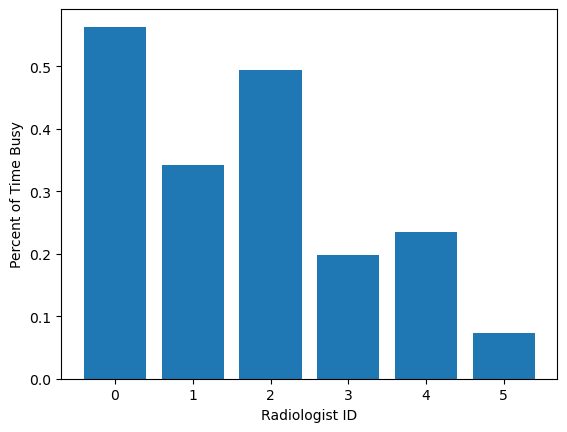

Radiologists were busy 0.318 of the time.
190 medical images
There are 0 that were not completed in time
Simulation complete at 310.2843705359435 minutes


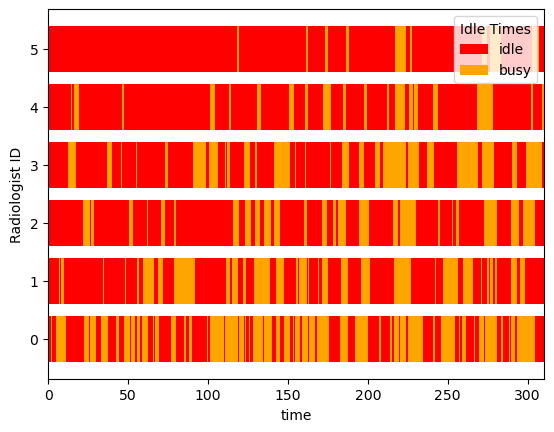

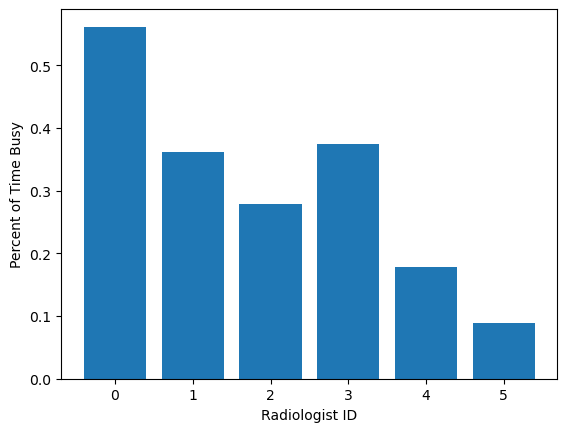

Radiologists were busy 0.307 of the time.
185 medical images
There are 0 that were not completed in time
Simulation complete at 315.6947768869476 minutes


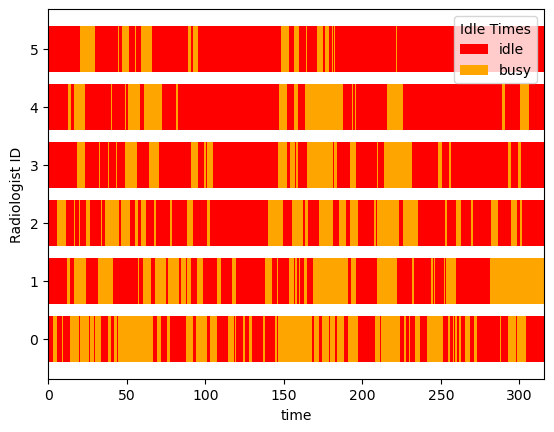

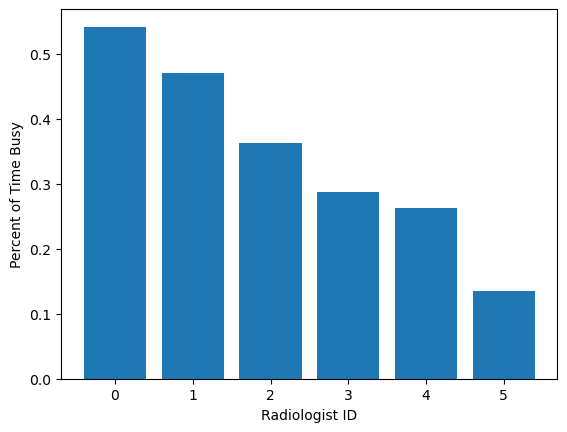

Radiologists were busy 0.343 of the time.
170 medical images
There are 0 that were not completed in time
Simulation complete at 318.3308433554803 minutes


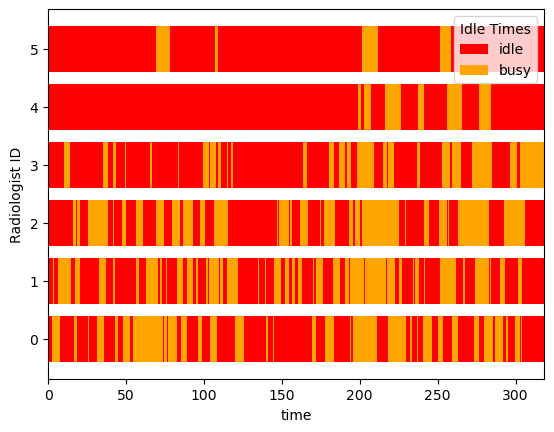

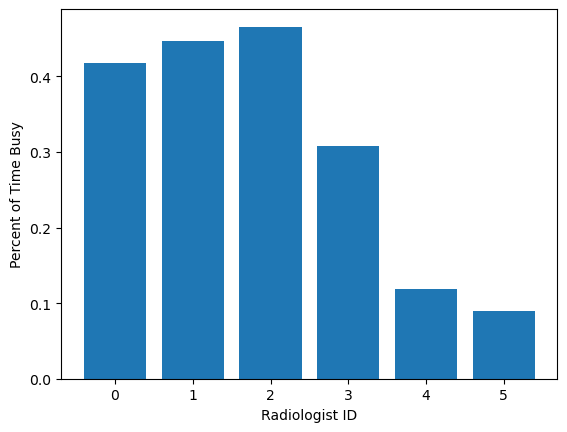

Radiologists were busy 0.308 of the time.
161 medical images
There are 0 that were not completed in time
Simulation complete at 305.7731790370811 minutes


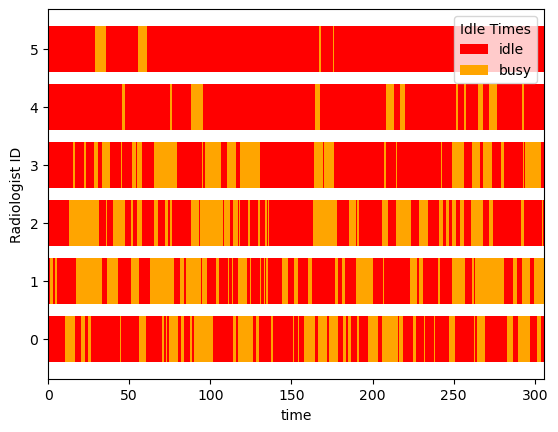

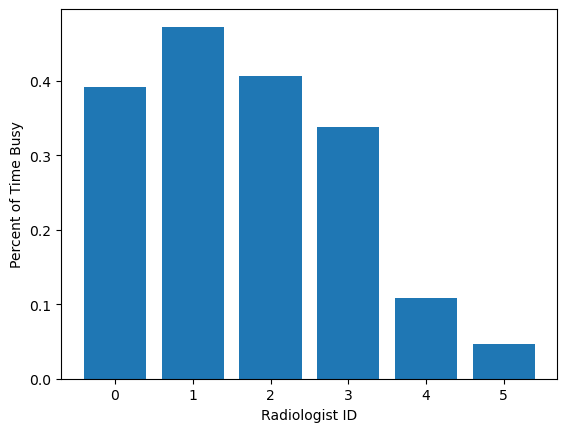

Radiologists were busy 0.294 of the time.
197 medical images
There are 0 that were not completed in time
Simulation complete at 327.80676095768547 minutes


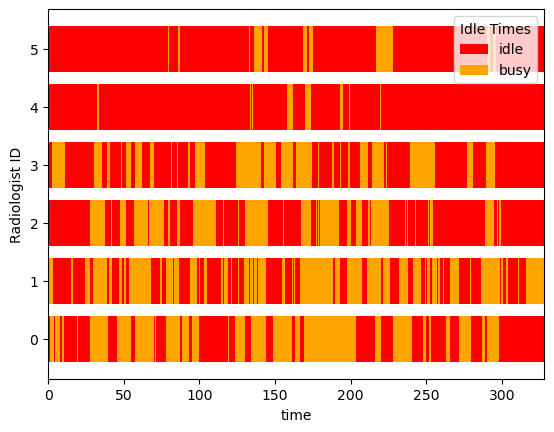

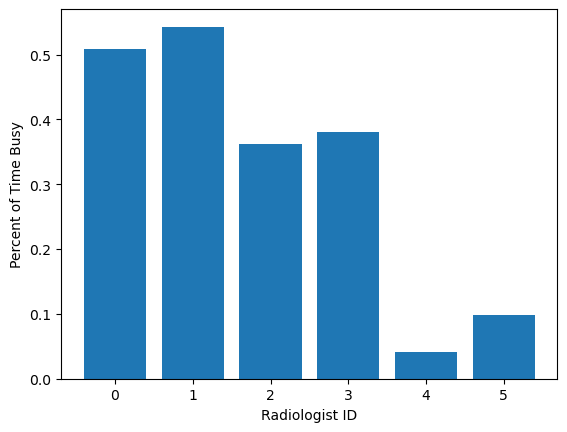

Radiologists were busy 0.322 of the time.
170 medical images
There are 0 that were not completed in time
Simulation complete at 314.21957825649054 minutes


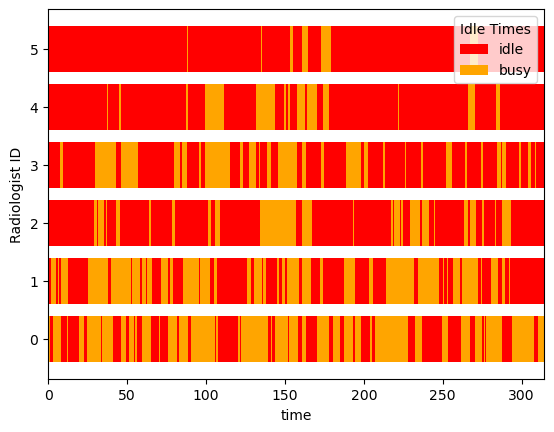

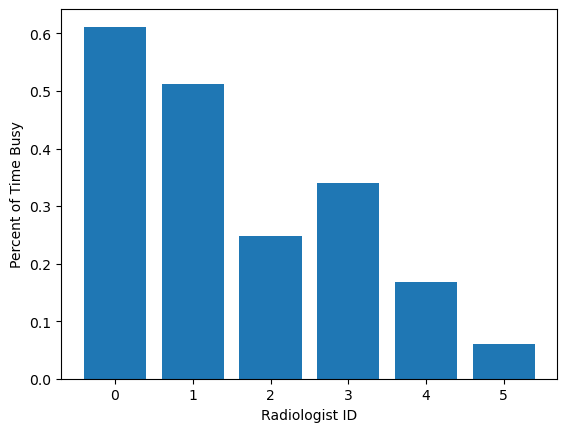

Radiologists were busy 0.323 of the time.
150 medical images
There are 0 that were not completed in time
Simulation complete at 310.58494596814506 minutes


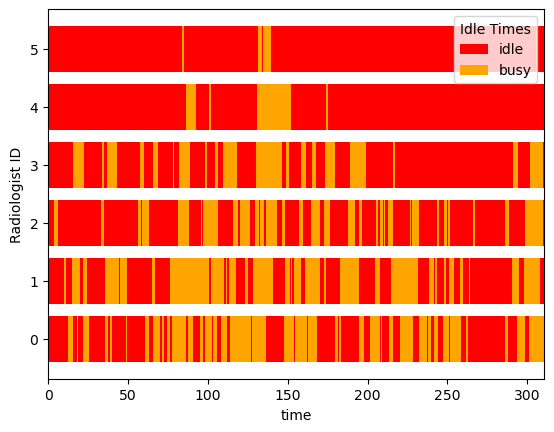

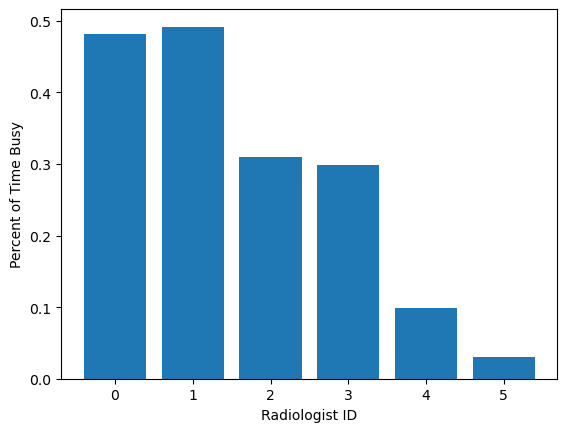

Radiologists were busy 0.285 of the time.
154 medical images
There are 0 that were not completed in time
Simulation complete at 329.1697343258846 minutes


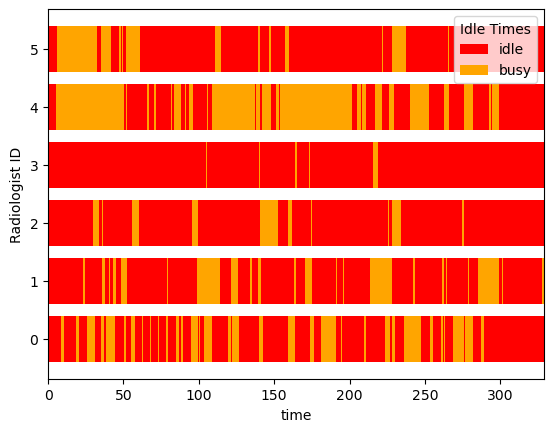

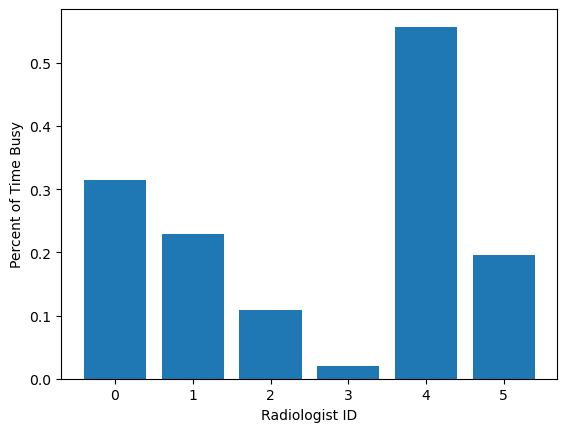

Radiologists were busy 0.238 of the time.
168 medical images
There are 0 that were not completed in time
Simulation complete at 324.902529965457 minutes


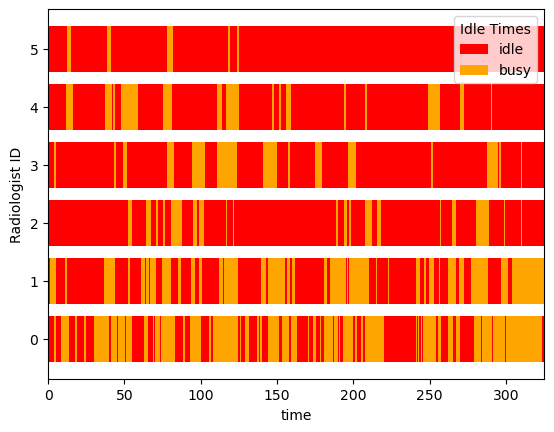

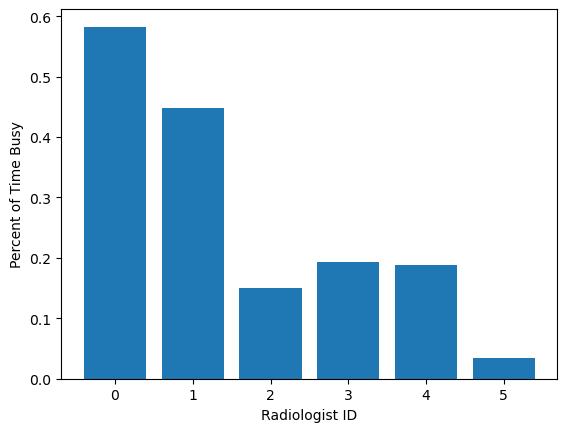

Radiologists were busy 0.266 of the time.
168 medical images
There are 0 that were not completed in time
Simulation complete at 318.8382111827647 minutes


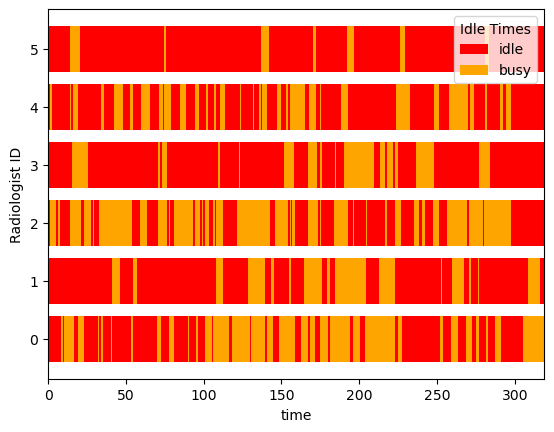

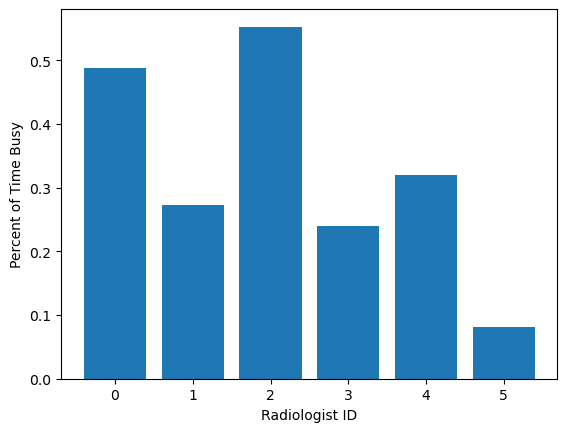

Radiologists were busy 0.326 of the time.
170 medical images
There are 0 that were not completed in time
Simulation complete at 306.93797192638874 minutes


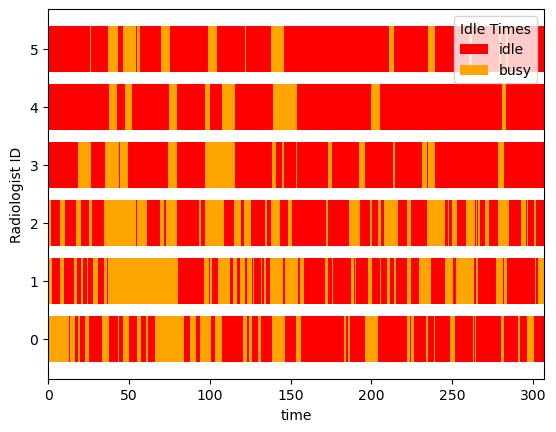

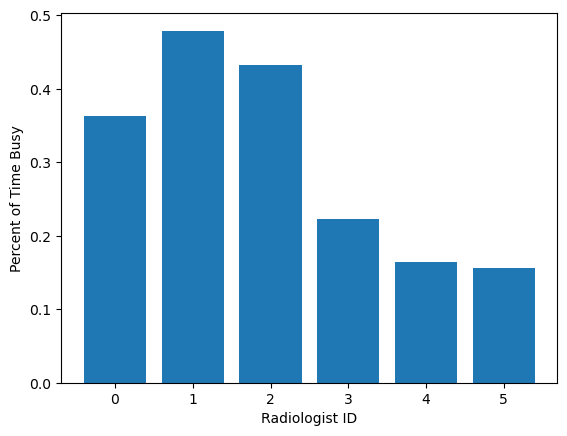

Radiologists were busy 0.303 of the time.
166 medical images
There are 0 that were not completed in time
Simulation complete at 305.55978496618496 minutes


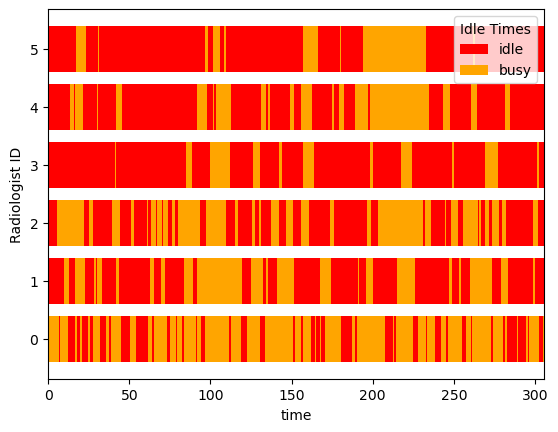

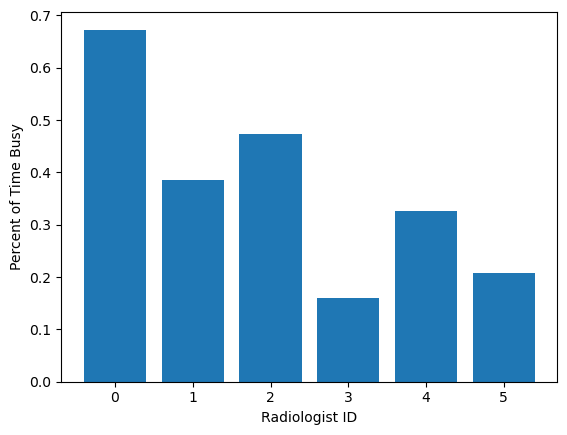

Radiologists were busy 0.371 of the time.
141 medical images
There are 0 that were not completed in time
Simulation complete at 318.7856824048843 minutes


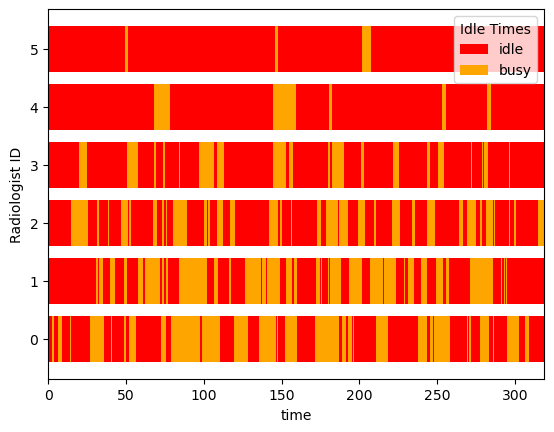

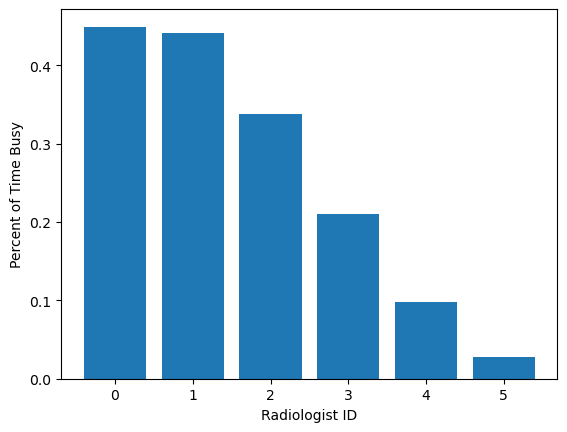

Radiologists were busy 0.261 of the time.
142 medical images
There are 0 that were not completed in time
Simulation complete at 314.60550629483726 minutes


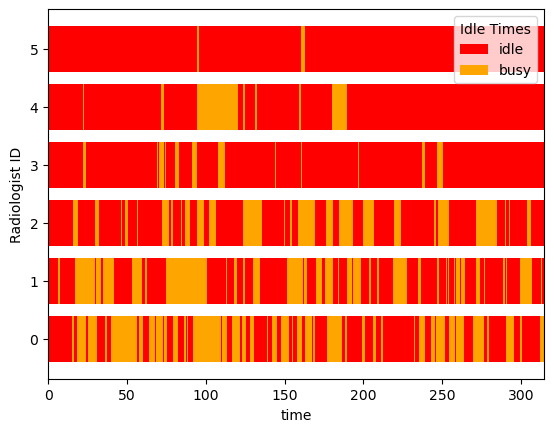

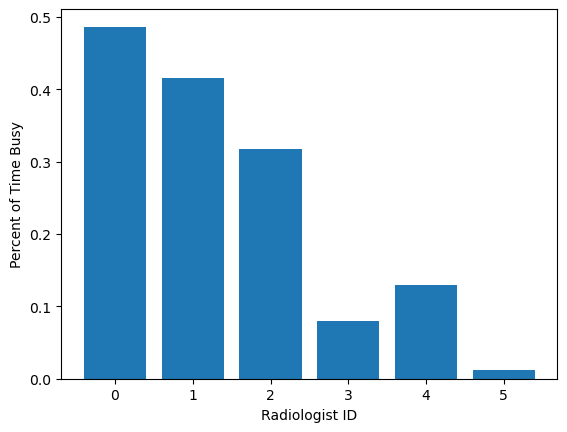

Radiologists were busy 0.24 of the time.
137 medical images
There are 0 that were not completed in time
Simulation complete at 314.36346946372834 minutes


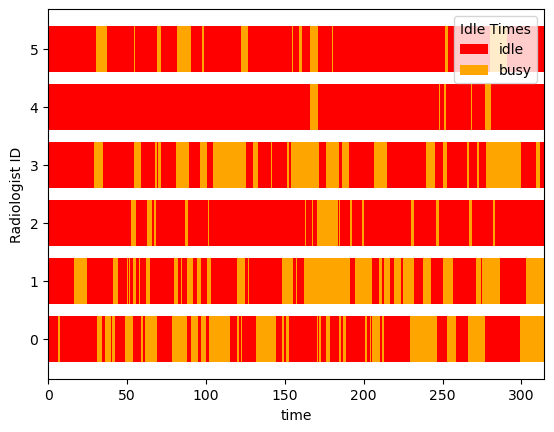

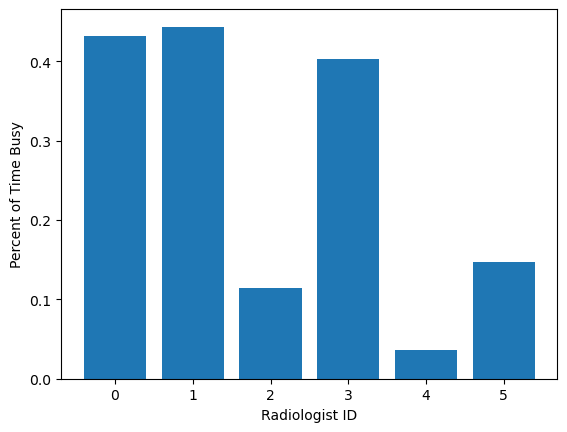

Radiologists were busy 0.263 of the time.
160 medical images
There are 0 that were not completed in time
Simulation complete at 307.72285322363376 minutes


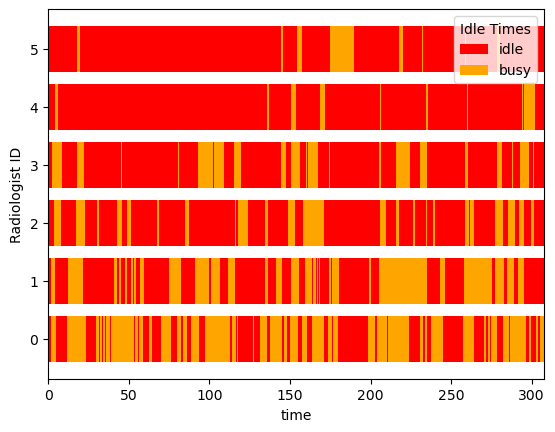

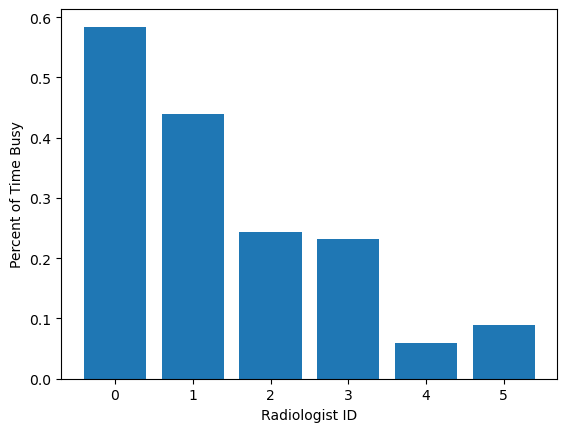

Radiologists were busy 0.274 of the time.
134 medical images
There are 0 that were not completed in time
Simulation complete at 310.36414547220386 minutes


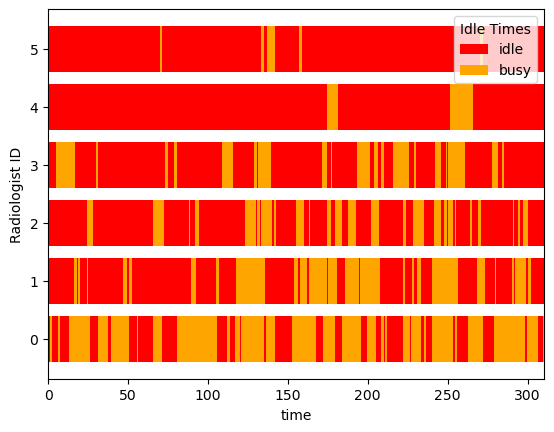

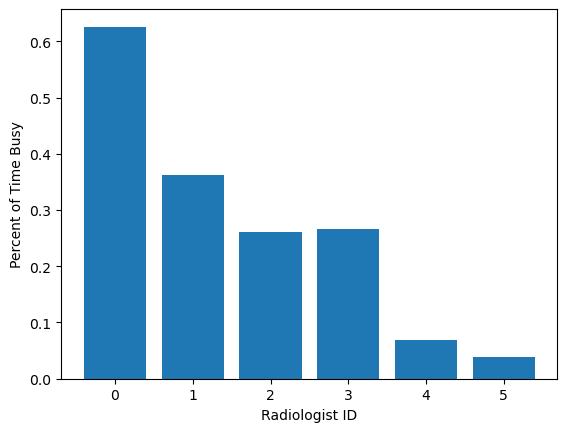

Radiologists were busy 0.27 of the time.
133 medical images
There are 0 that were not completed in time
Simulation complete at 313.92824828147974 minutes


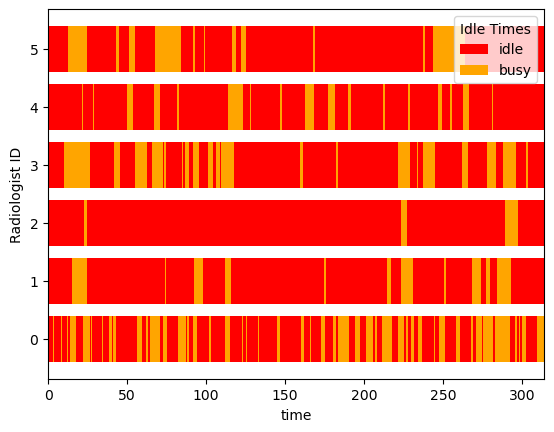

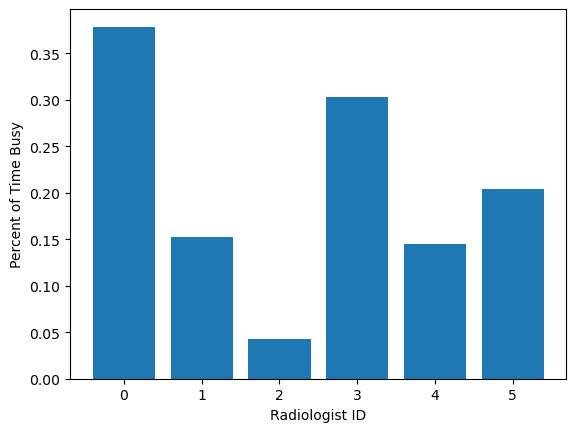

Radiologists were busy 0.204 of the time.
133 medical images
There are 0 that were not completed in time
Simulation complete at 319.60580232767427 minutes


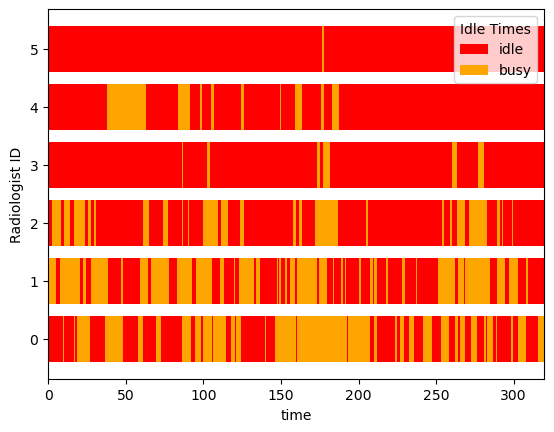

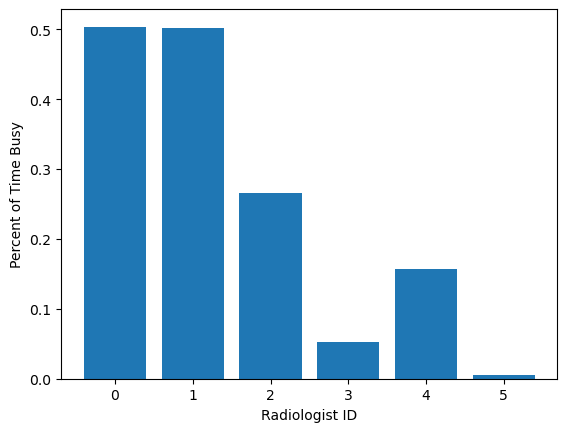

Radiologists were busy 0.248 of the time.
156 medical images
There are 0 that were not completed in time
Simulation complete at 321.9699475971203 minutes


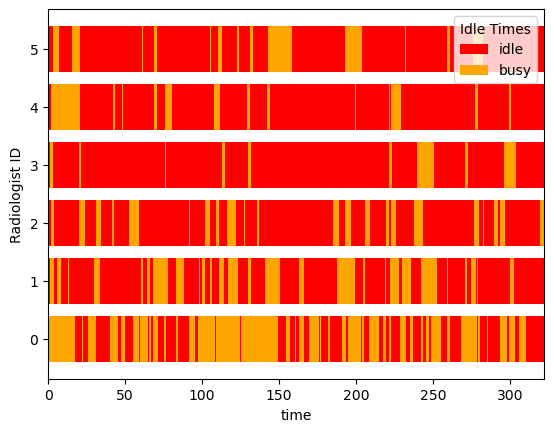

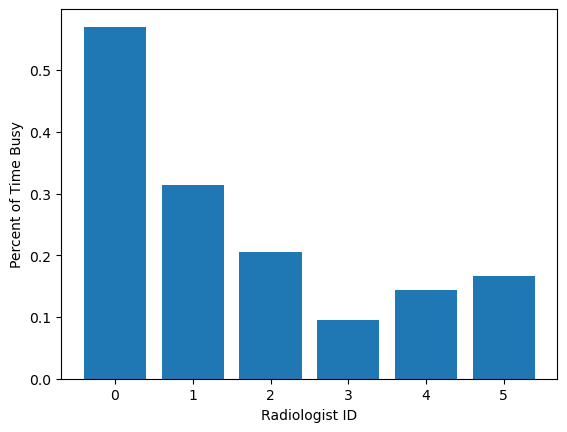

Radiologists were busy 0.249 of the time.
136 medical images
There are 0 that were not completed in time
Simulation complete at 310.57340353193825 minutes


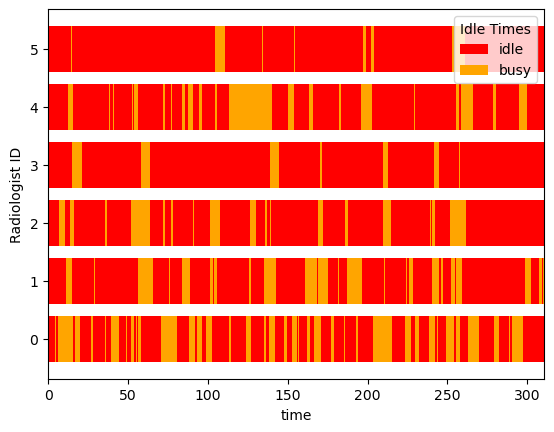

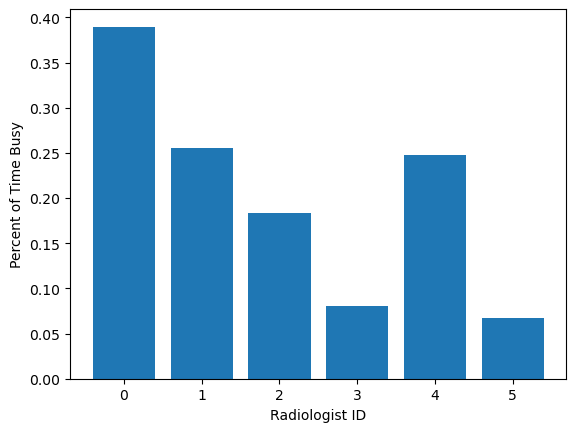

Radiologists were busy 0.204 of the time.
137 medical images
There are 0 that were not completed in time
Simulation complete at 318.3885549863198 minutes


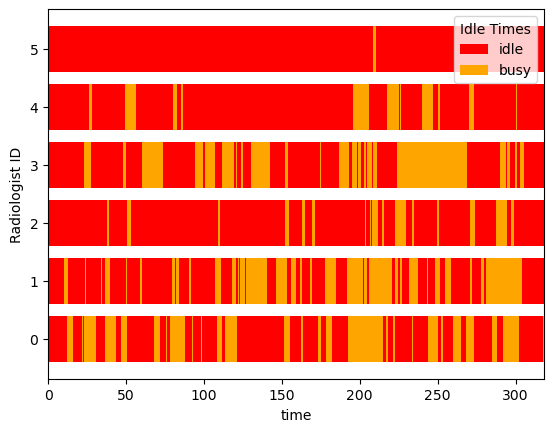

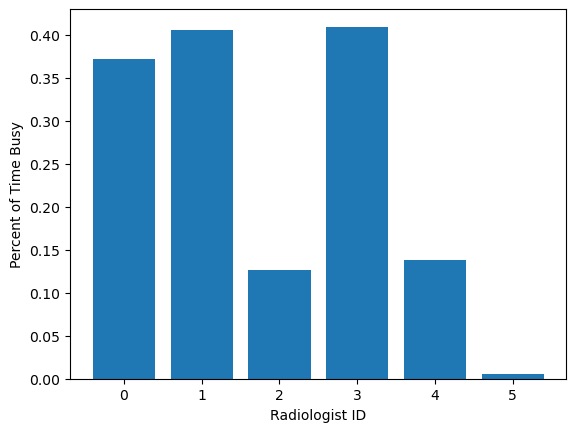

Radiologists were busy 0.243 of the time.
138 medical images
There are 0 that were not completed in time
Simulation complete at 316.61217469626644 minutes


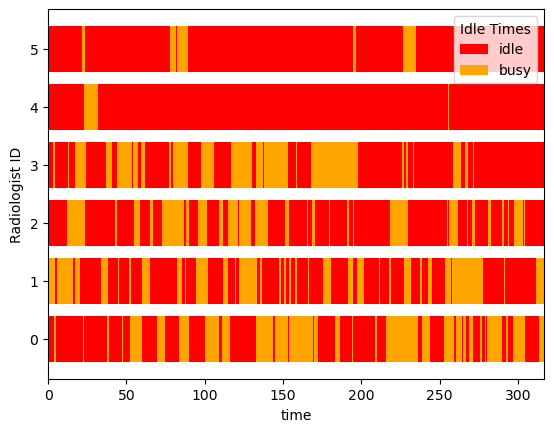

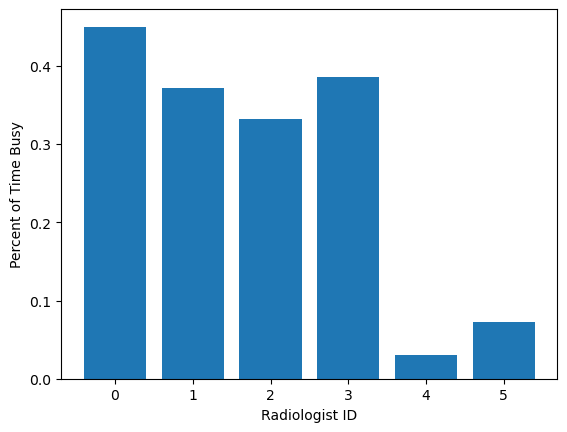

Radiologists were busy 0.274 of the time.
132 medical images
There are 0 that were not completed in time
Simulation complete at 320.50902504032695 minutes


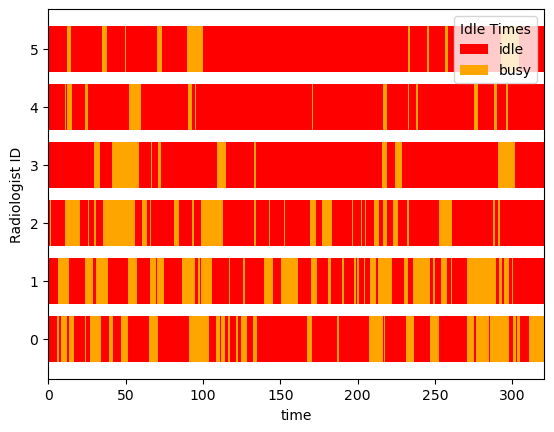

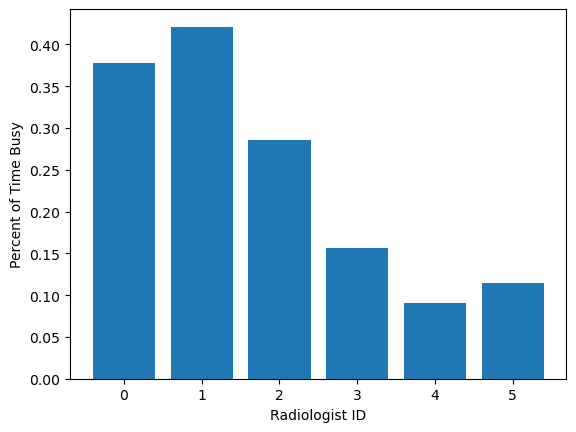

Radiologists were busy 0.241 of the time.
123 medical images
There are 0 that were not completed in time
Simulation complete at 307.043040282505 minutes


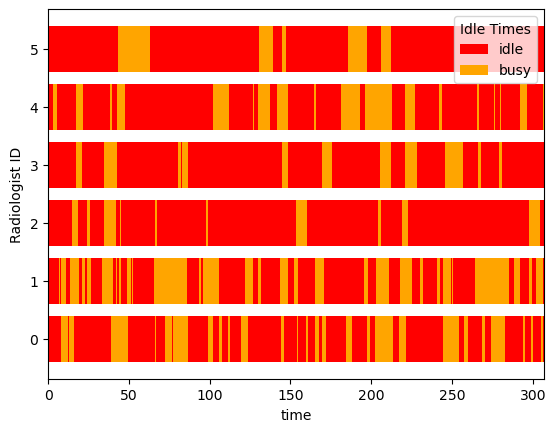

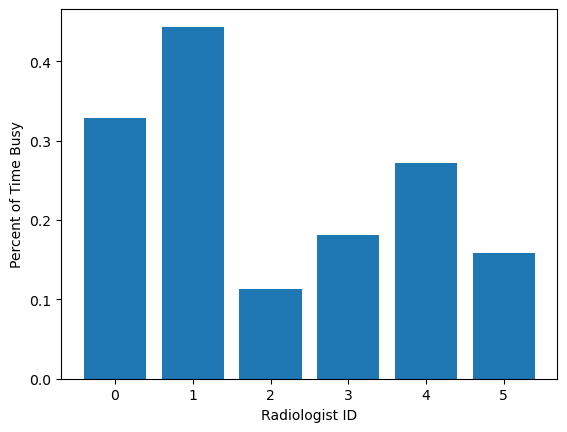

Radiologists were busy 0.25 of the time.
125 medical images
There are 0 that were not completed in time
Simulation complete at 327.22604909821854 minutes


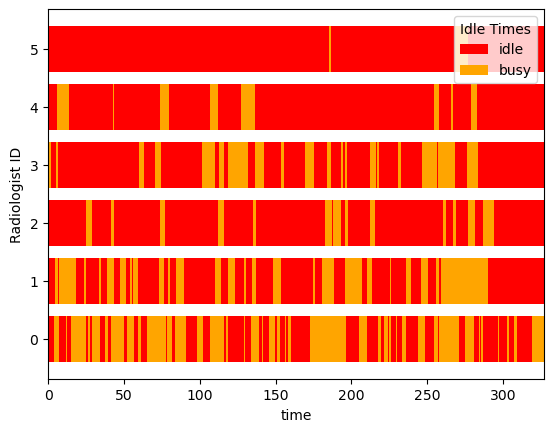

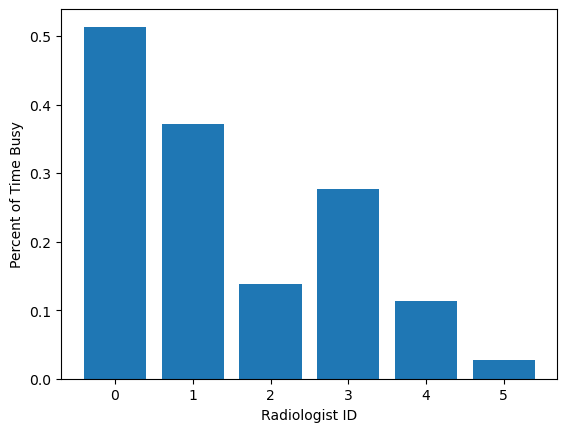

Radiologists were busy 0.24 of the time.
141 medical images
There are 0 that were not completed in time
Simulation complete at 314.8382924607283 minutes


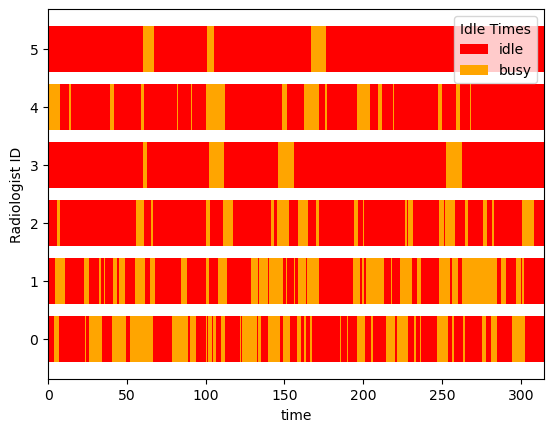

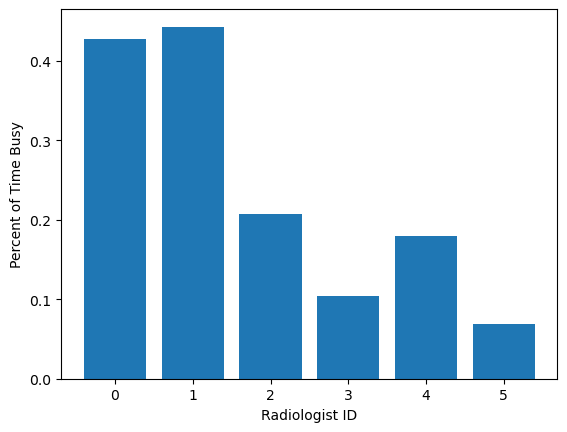

Radiologists were busy 0.238 of the time.
141 medical images
There are 0 that were not completed in time
Simulation complete at 312.348308564826 minutes


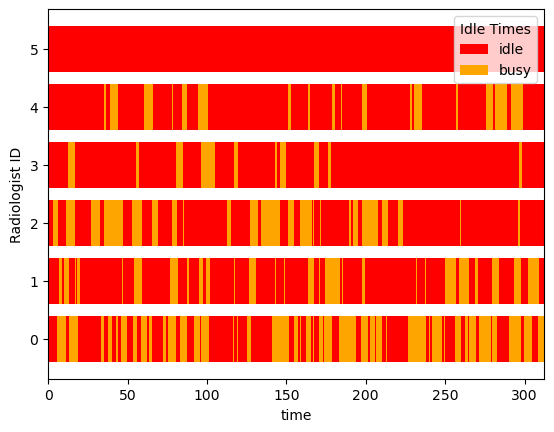

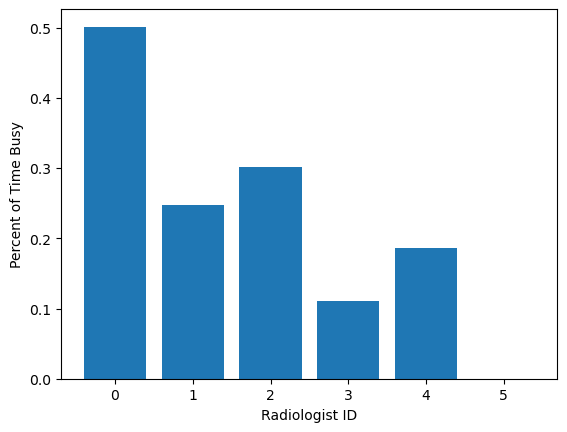

Radiologists were busy 0.224 of the time.
121 medical images
There are 0 that were not completed in time
Simulation complete at 323.96011768475324 minutes


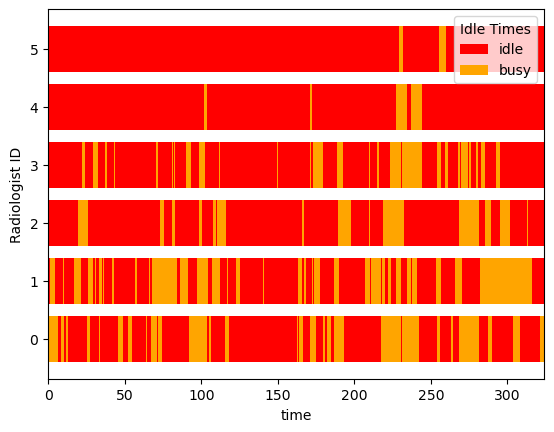

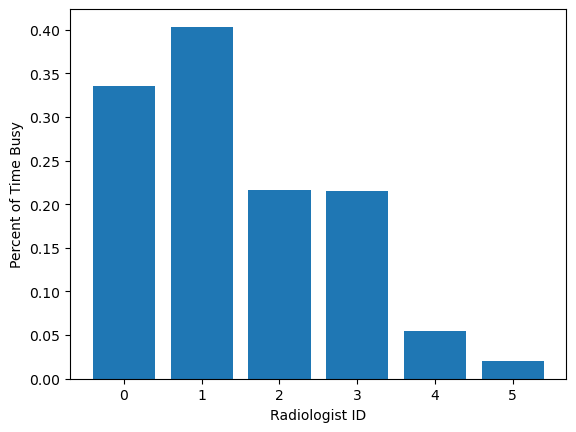

Radiologists were busy 0.208 of the time.
108 medical images
There are 0 that were not completed in time
Simulation complete at 329.31650544511 minutes


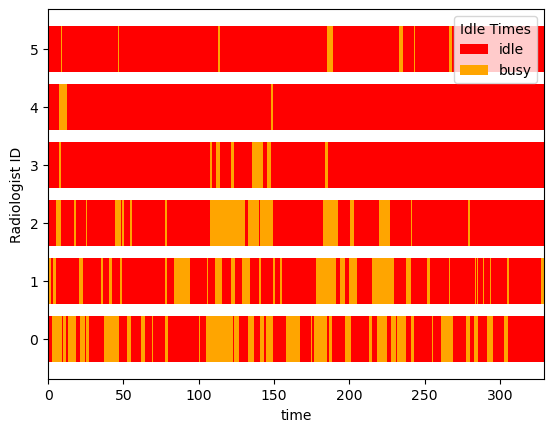

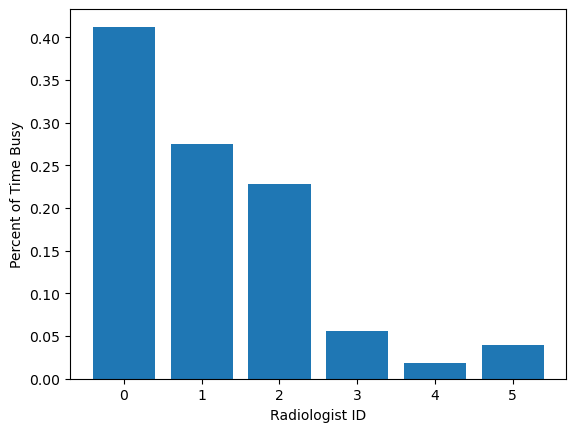

Radiologists were busy 0.171 of the time.
117 medical images
There are 0 that were not completed in time
Simulation complete at 309.5195131505582 minutes


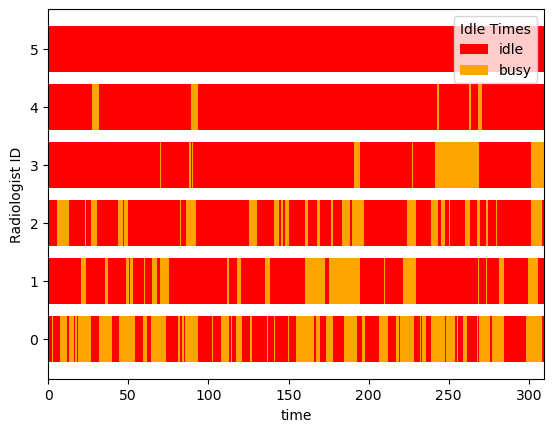

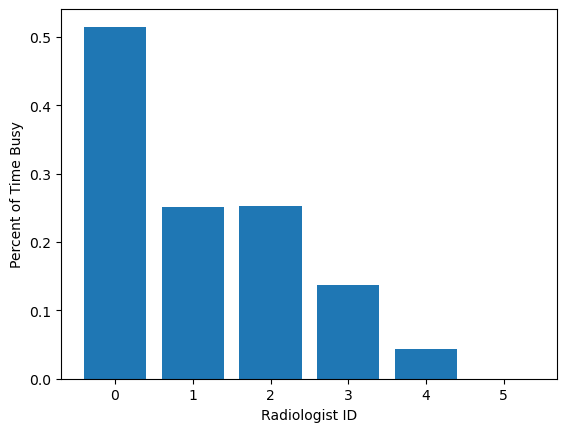

Radiologists were busy 0.2 of the time.
124 medical images
There are 0 that were not completed in time
Simulation complete at 321.9869102822418 minutes


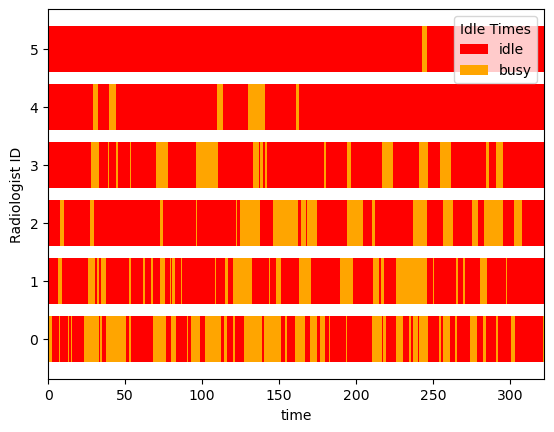

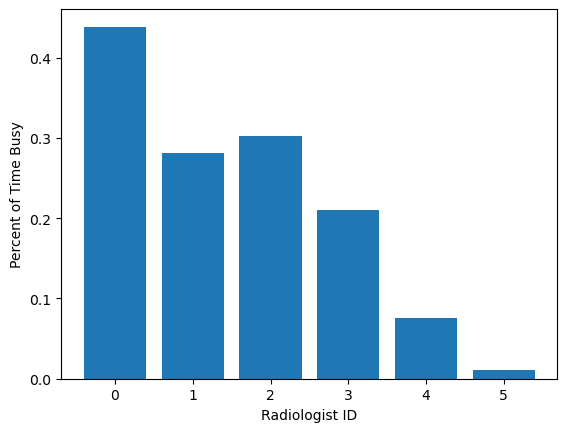

Radiologists were busy 0.22 of the time.
111 medical images
There are 0 that were not completed in time
Simulation complete at 318.9187573511277 minutes


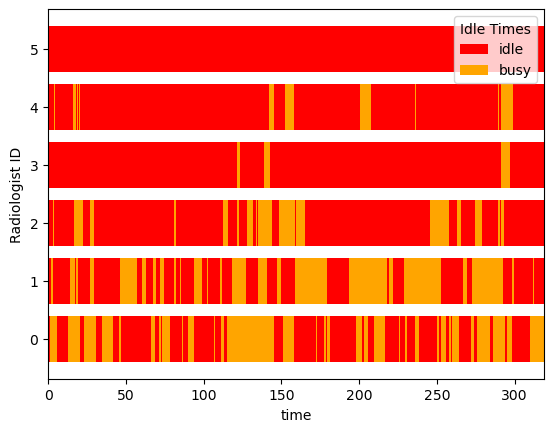

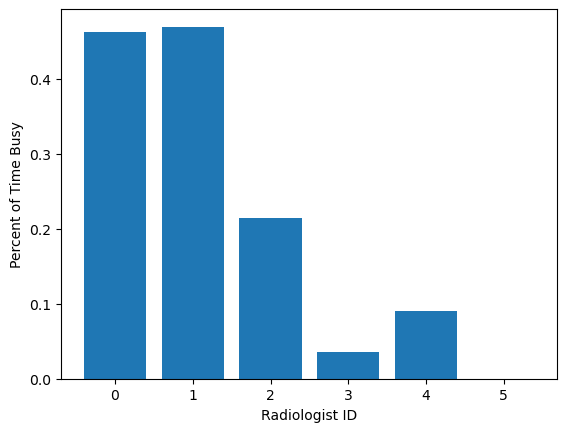

Radiologists were busy 0.212 of the time.


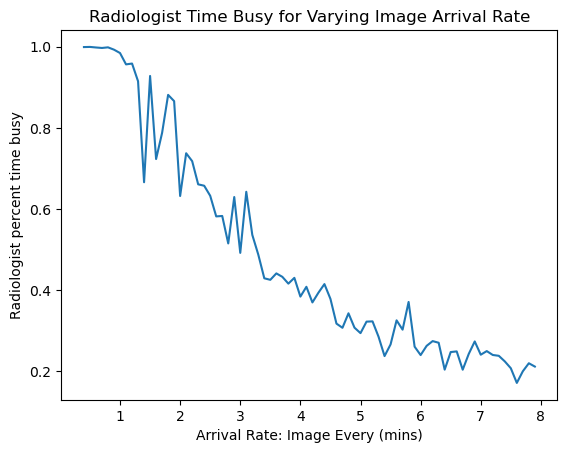

In [84]:
busy_times = {}
sims_dict = {}
for arr_rate_var in np.arange(0.4, 8.0, 0.1):
    #Define variables
    sim_time = 60*5
    rads_count = 6
    arr_rates = [arr_rate_var, arr_rate_var, arr_rate_var]
    urg_times = [2, 5, 10]
    #run sim
    s_temp = sim(sim_time, rads_count, arr_rates, urg_times, cutoff=True, verbose=False)   
    busy_times[arr_rate_var] = idle_plots(s_temp.rads)
    sims_dict[arr_rate_var] = s_temp
plt.plot(busy_times.keys(), busy_times.values(), label=f"{rads_count} radiologists")
plt.xlabel("Arrival Rate: Image Every (mins)")
plt.ylabel("Radiologist percent time busy")
plt.title("Radiologist Time Busy for Varying Image Arrival Rate")
plt.show()

Time plots for images arriving avg every 0.4 mins


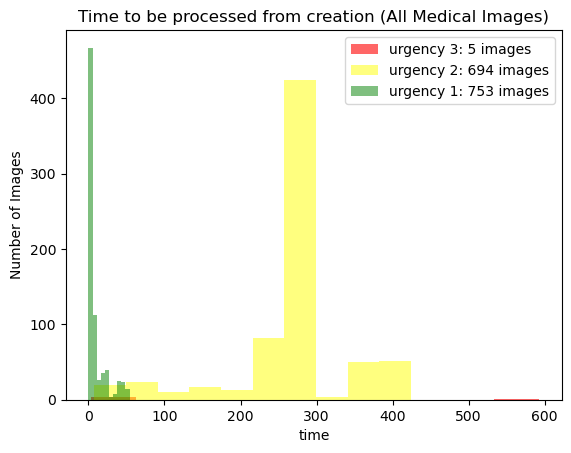

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 9.708629457850936
Urgency 2: 268.5747417388184
Urgency 3: 128.0579363811602


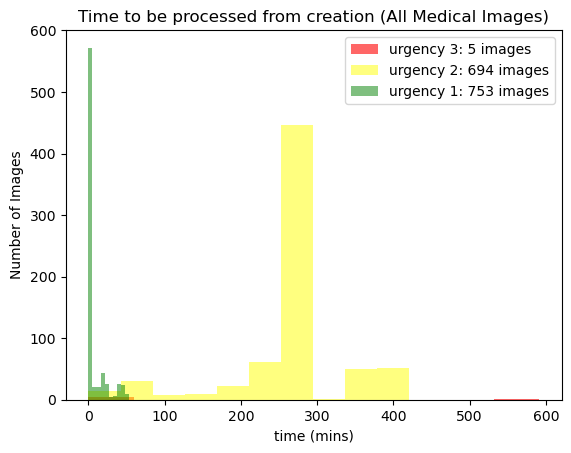

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 7.770132624283985
Urgency 2: 265.61791269457285
Urgency 3: 118.26199820282241

_______________________________________________

Time plots for images arriving avg every 0.5 mins


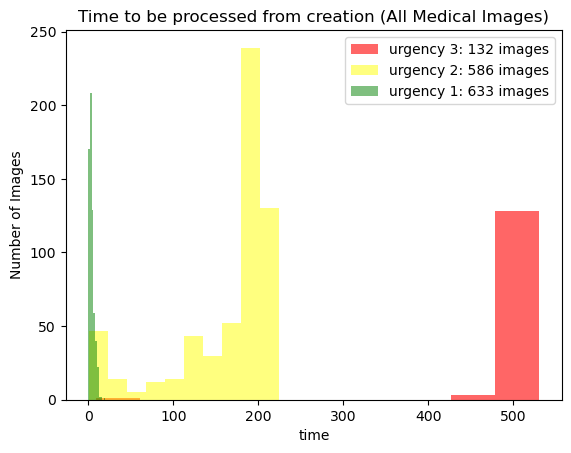

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 4.076302309245505
Urgency 2: 162.19665481218436
Urgency 3: 499.20660795411413


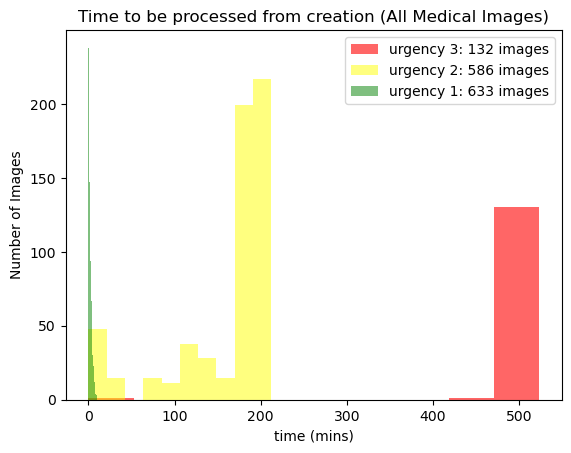

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.040916284468752
Urgency 2: 159.5001061741054
Urgency 3: 493.8727331263216

_______________________________________________

Time plots for images arriving avg every 0.6 mins


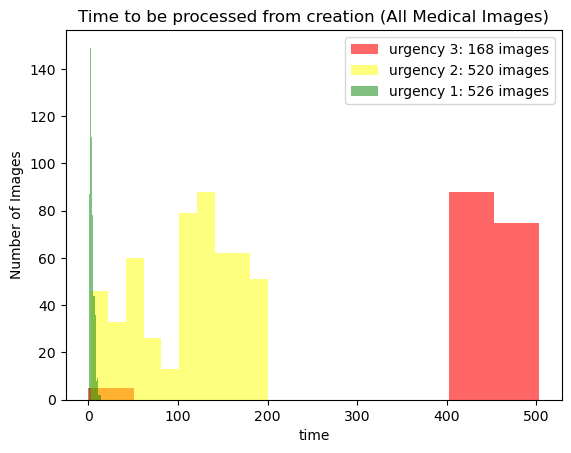

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.6823761450844845
Urgency 2: 111.20605624589614
Urgency 3: 441.2772884579804


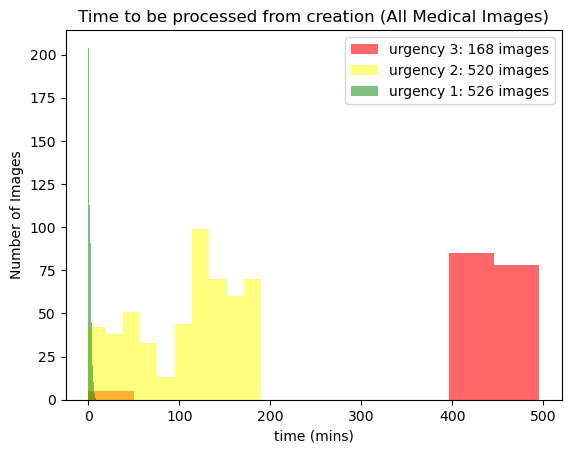

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.6625706614948943
Urgency 2: 108.38893445931956
Urgency 3: 435.26579036561054

_______________________________________________

Time plots for images arriving avg every 0.7 mins


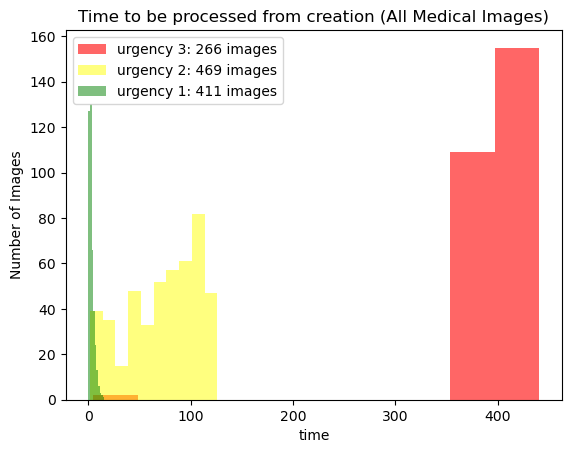

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.2753410953504263
Urgency 2: 72.7171952380746
Urgency 3: 400.7507614056632


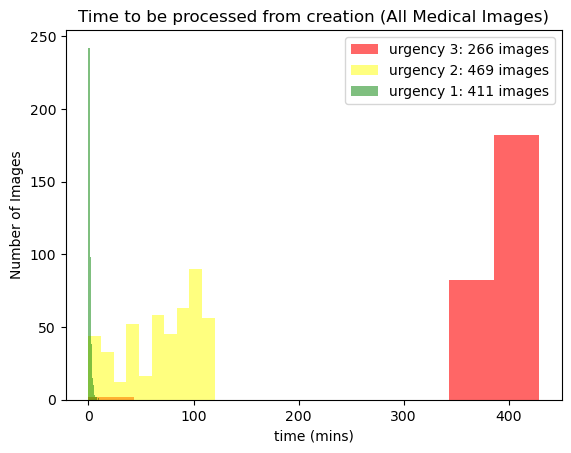

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2295077935131404
Urgency 2: 69.63344078121479
Urgency 3: 395.91496357346676

_______________________________________________

Time plots for images arriving avg every 0.8 mins


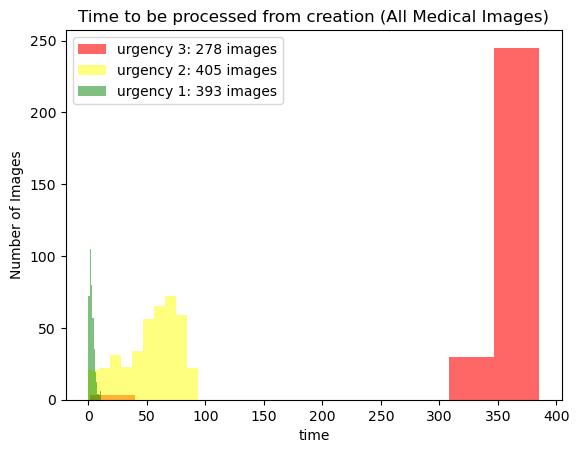

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.9694179491031263
Urgency 2: 53.8126546250247
Urgency 3: 353.32583886794134


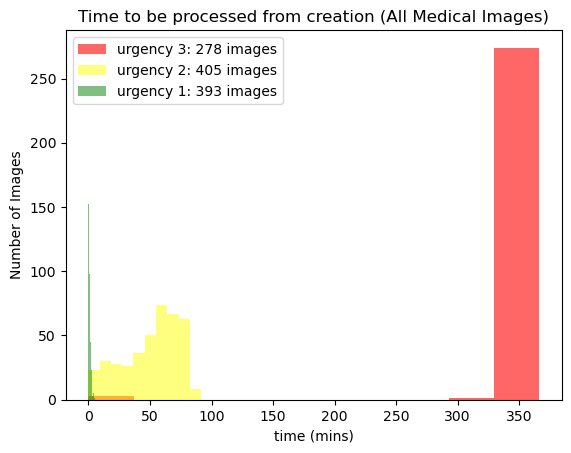

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.0219457046754656
Urgency 2: 50.65681586200849
Urgency 3: 347.891016091324

_______________________________________________

Time plots for images arriving avg every 0.9 mins


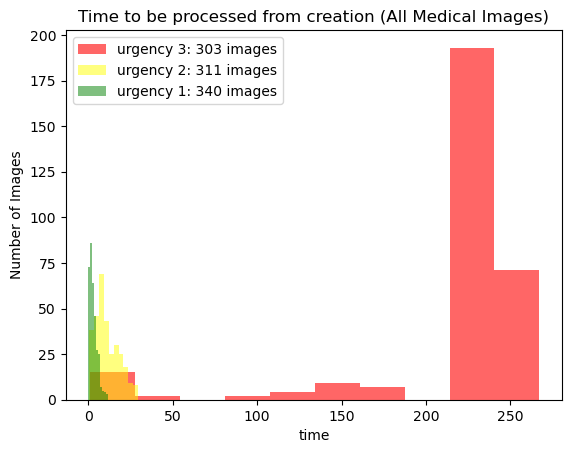

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1186682802848575
Urgency 2: 11.219473417290104
Urgency 3: 217.09067109608824


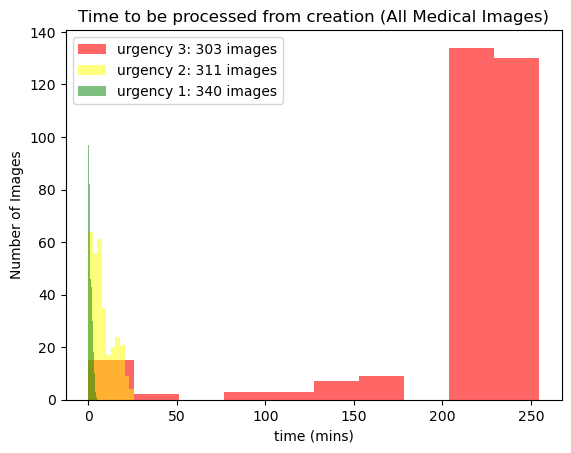

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1920067152724718
Urgency 2: 8.155148283499992
Urgency 3: 212.11949708701587

_______________________________________________

Time plots for images arriving avg every 1.0 mins


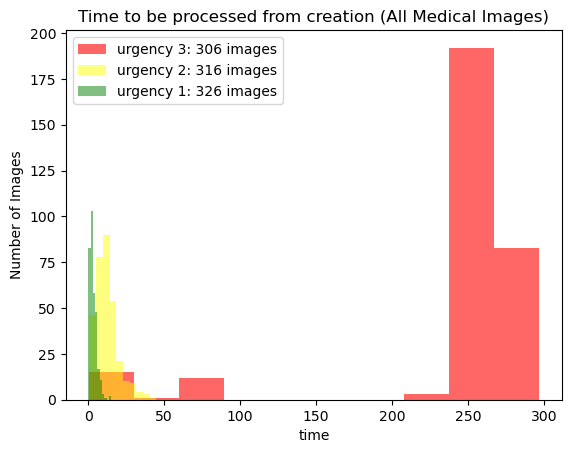

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.281408405473778
Urgency 2: 12.187786896010618
Urgency 3: 240.22710453009884


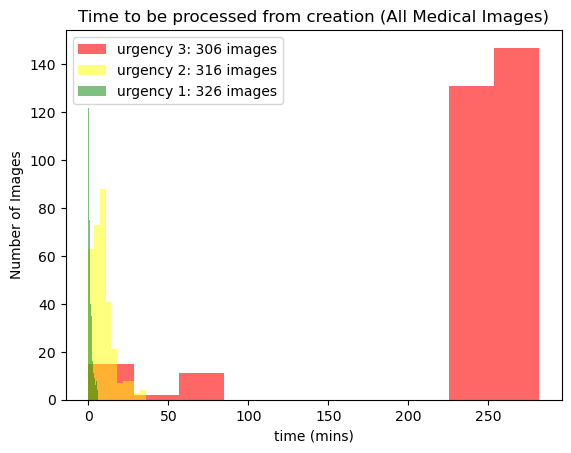

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2846086259132032
Urgency 2: 9.05855506116504
Urgency 3: 234.7124716833674

_______________________________________________

Time plots for images arriving avg every 1.1 mins


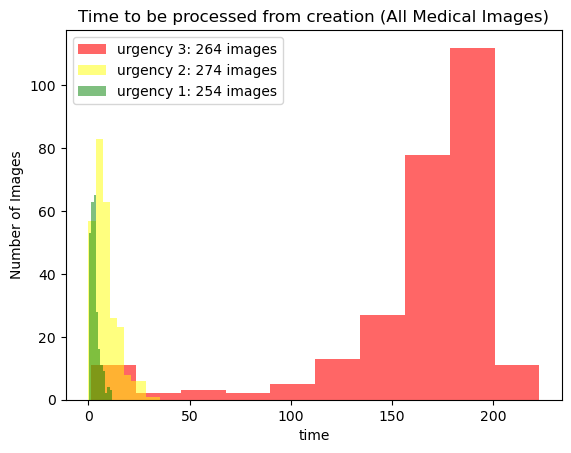

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1598972111418315
Urgency 2: 8.426845662224753
Urgency 3: 162.86926212108182


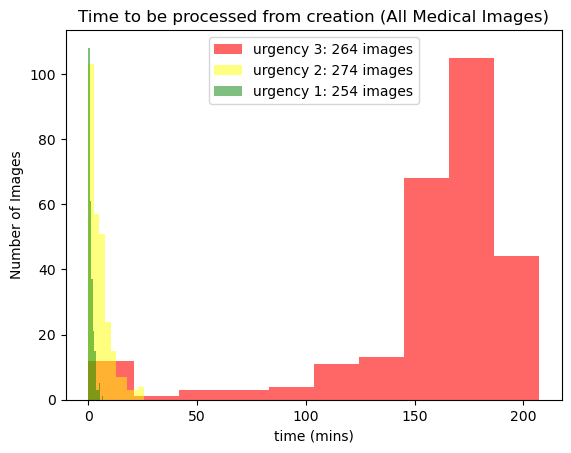

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2139506540477043
Urgency 2: 5.326481840205484
Urgency 3: 157.6770181536717

_______________________________________________

Time plots for images arriving avg every 1.2 mins


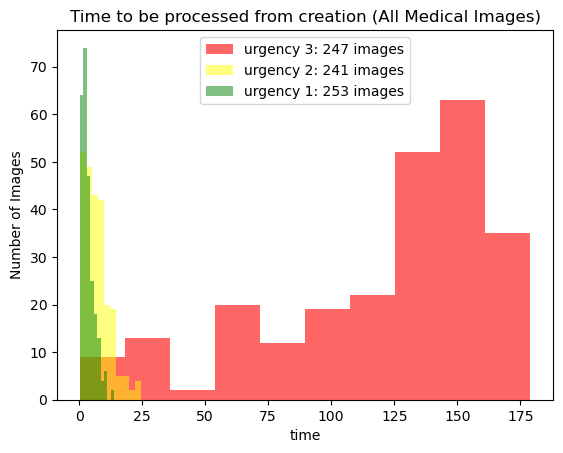

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.423970952886159
Urgency 2: 7.147539306797611
Urgency 3: 119.98143030754837


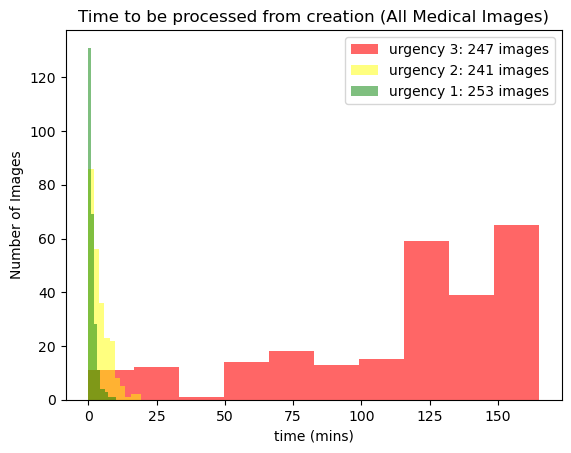

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3953211634052003
Urgency 2: 4.09533373336478
Urgency 3: 114.75191849228258

_______________________________________________

Time plots for images arriving avg every 1.3 mins


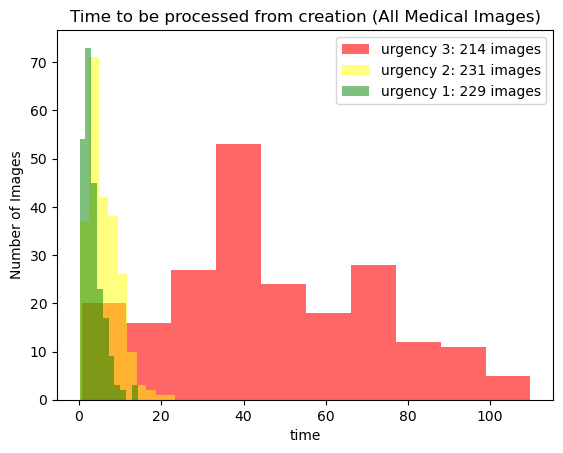

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.3086462941858095
Urgency 2: 6.029736147868909
Urgency 3: 47.08005089434048


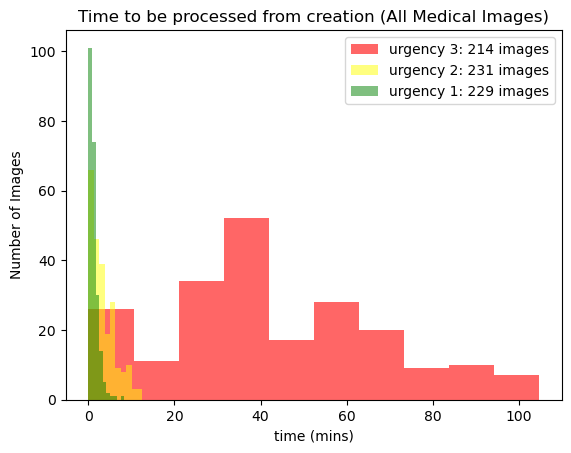

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1919284284036762
Urgency 2: 3.290368847721662
Urgency 3: 42.75774101538468

_______________________________________________

Time plots for images arriving avg every 1.4 mins


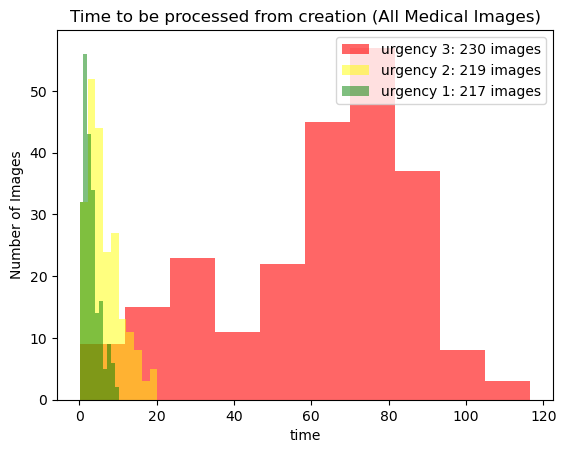

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.070879443653689
Urgency 2: 6.4364404664165
Urgency 3: 61.44489347307914


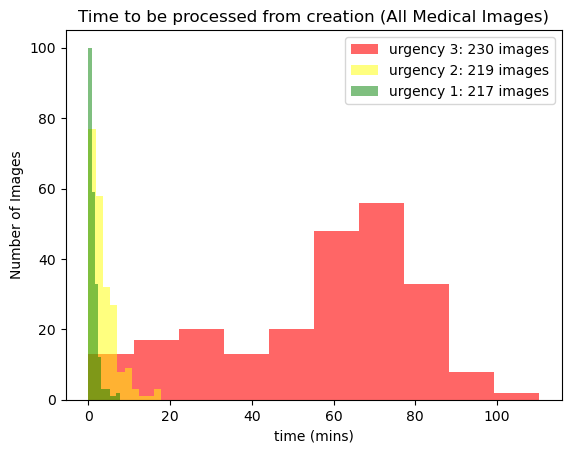

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1535051238975775
Urgency 2: 3.6104211325648405
Urgency 3: 56.46972095932998

_______________________________________________

Time plots for images arriving avg every 1.5 mins


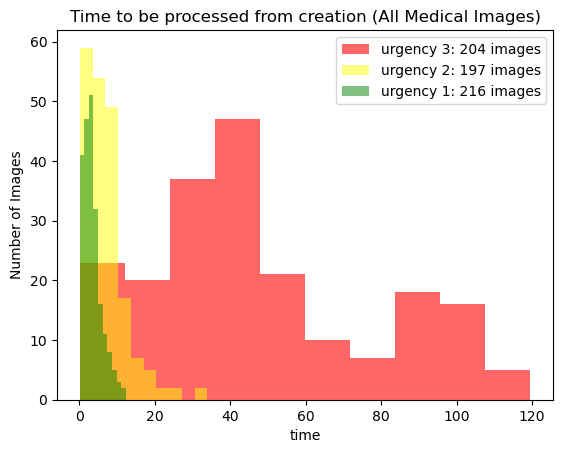

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.519695847020339
Urgency 2: 7.02079173994145
Urgency 3: 47.37631255019414


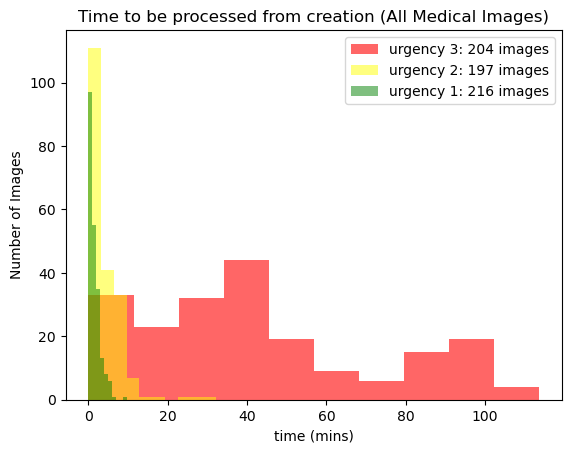

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.524389728520812
Urgency 2: 3.894008813551881
Urgency 3: 42.31212020546995

_______________________________________________

Time plots for images arriving avg every 1.6 mins


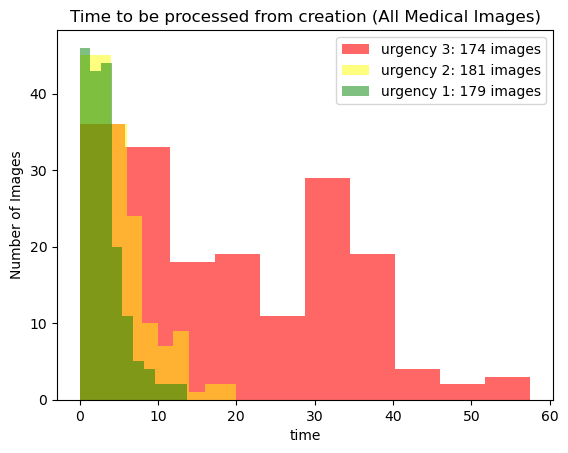

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.1813570505987556
Urgency 2: 4.838298820340123
Urgency 3: 19.415866951247004


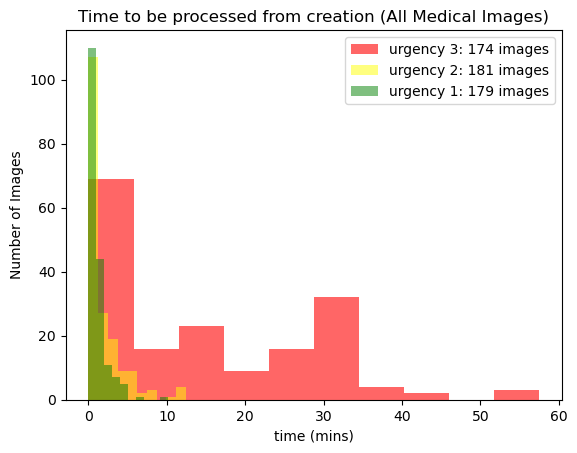

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.06531495099883
Urgency 2: 1.8483260714252416
Urgency 3: 14.871430262530282

_______________________________________________

Time plots for images arriving avg every 1.7 mins


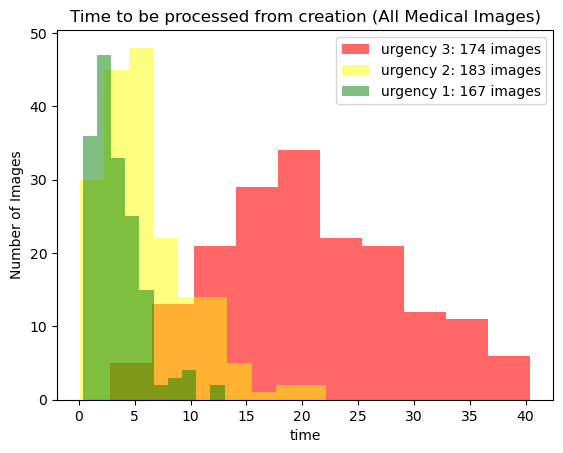

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.403380776409272
Urgency 2: 5.99438574019767
Urgency 3: 20.66864577507256


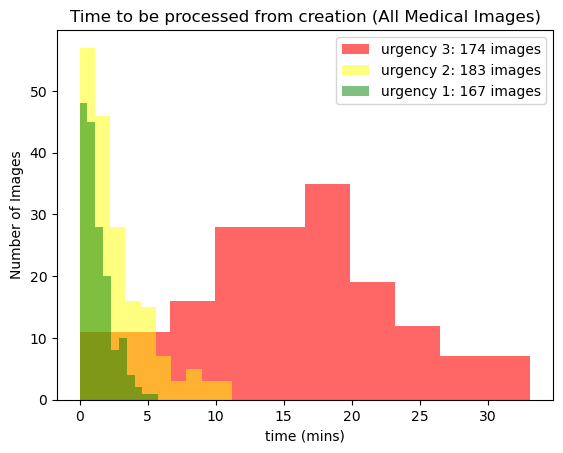

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3112790928459175
Urgency 2: 2.662728359822112
Urgency 3: 15.497120499721438

_______________________________________________

Time plots for images arriving avg every 1.8 mins


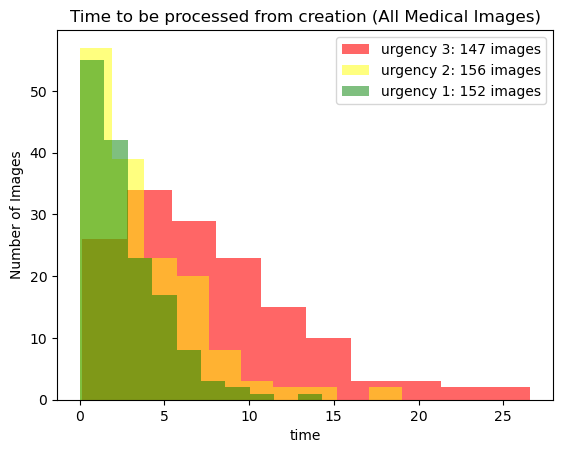

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.6285080533092646
Urgency 2: 3.75752230404742
Urgency 3: 7.571479279291736


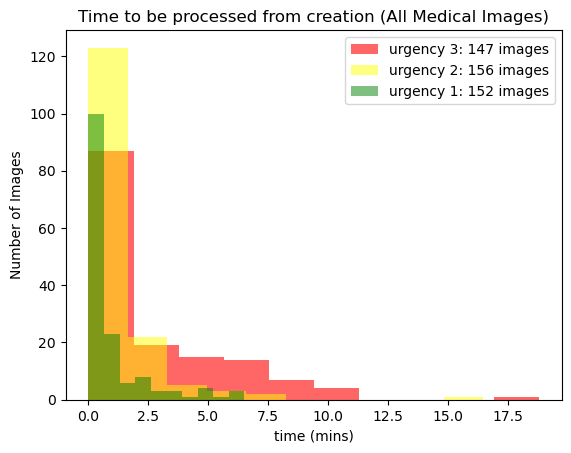

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8307014859521766
Urgency 2: 1.015435433046436
Urgency 3: 2.4299468606680903

_______________________________________________

Time plots for images arriving avg every 1.9 mins


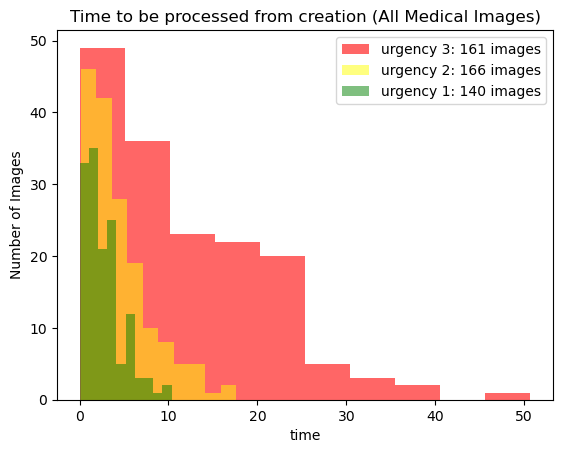

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.706435336373402
Urgency 2: 4.302327334215784
Urgency 3: 11.73595914857241


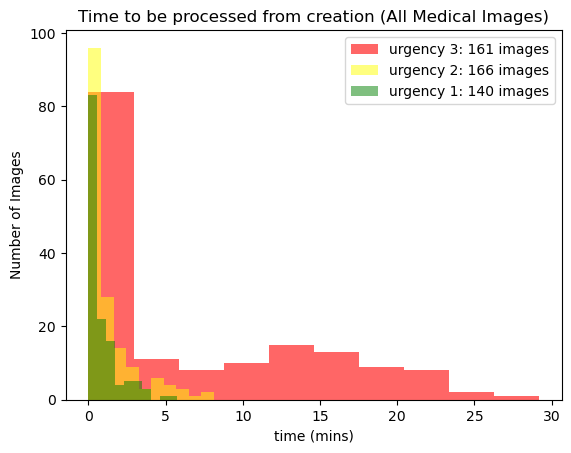

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.7911248336562514
Urgency 2: 1.2340745653847776
Urgency 3: 6.695905077081381

_______________________________________________

Time plots for images arriving avg every 2.0 mins


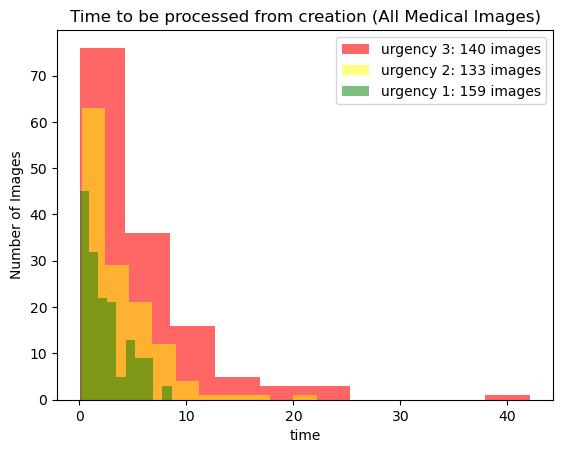

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.428479929051847
Urgency 2: 3.766215432394091
Urgency 3: 5.589622513249851


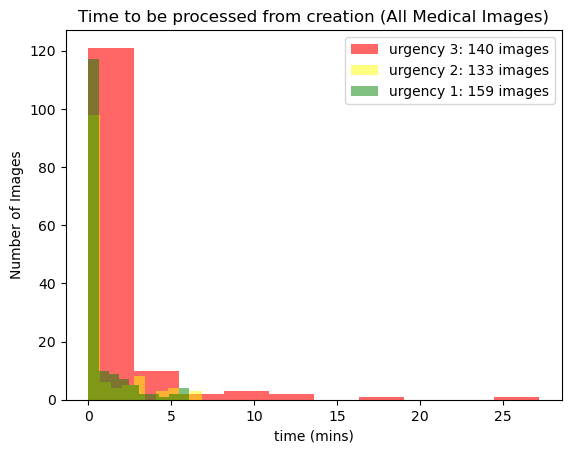

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6954318964543154
Urgency 2: 0.9255288578735656
Urgency 3: 1.379034422430146

_______________________________________________

Time plots for images arriving avg every 2.1 mins


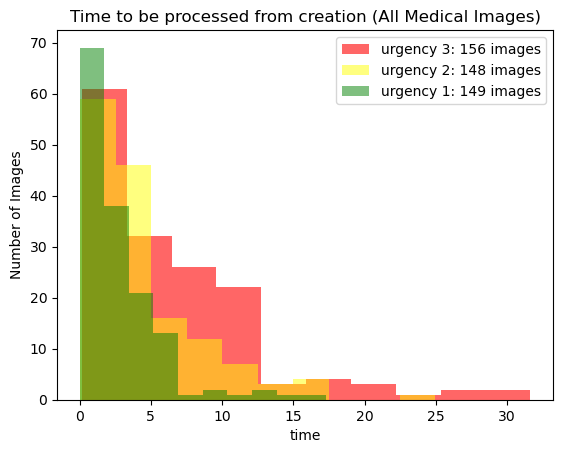

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.7698656949755853
Urgency 2: 4.345375204304229
Urgency 3: 6.603104008910104


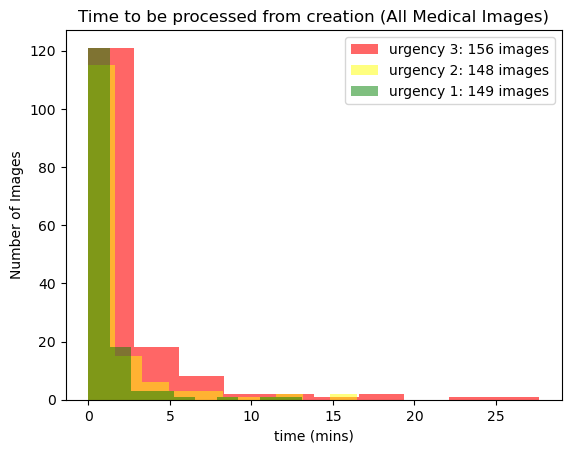

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.8495065642602659
Urgency 2: 1.3566783879459259
Urgency 3: 2.0403922939599712

_______________________________________________

Time plots for images arriving avg every 2.2 mins


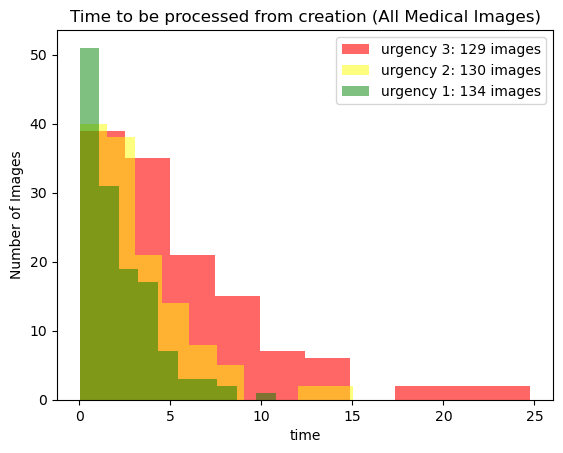

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.162119491547406
Urgency 2: 3.2109856729302835
Urgency 3: 5.588076967352983


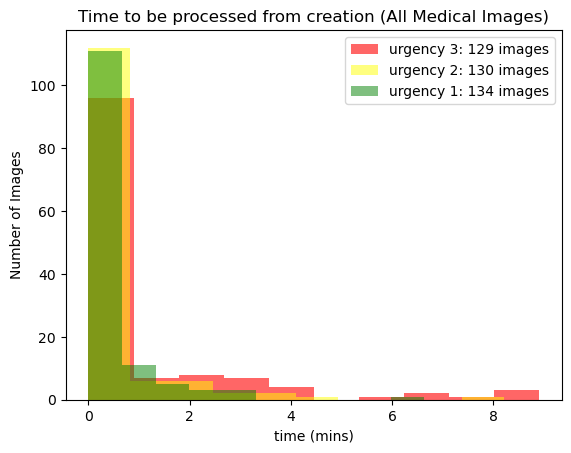

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.33354763237865803
Urgency 2: 0.40817934456793326
Urgency 3: 0.963081615300414

_______________________________________________

Time plots for images arriving avg every 2.3 mins


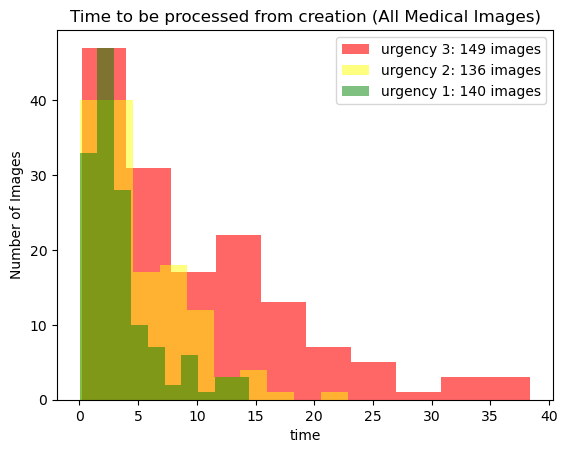

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.5127445253392198
Urgency 2: 4.859614208648671
Urgency 3: 9.898382910099523


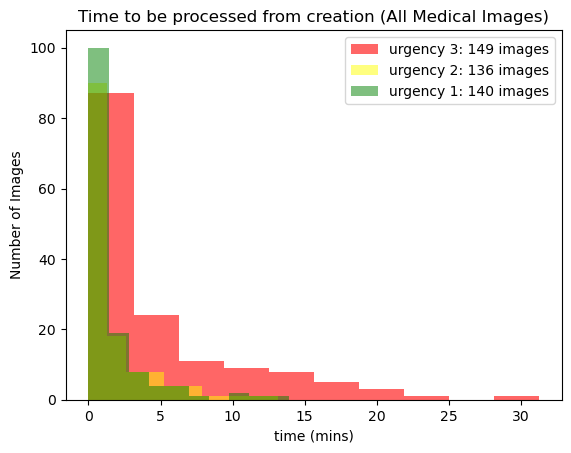

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.4209841312033462
Urgency 2: 1.59221888781205
Urgency 3: 4.299261162874118

_______________________________________________

Time plots for images arriving avg every 2.4 mins


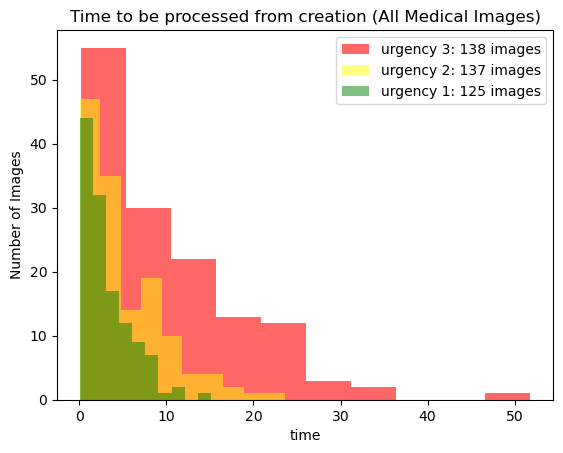

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.216170545374422
Urgency 2: 5.18874612307292
Urgency 3: 9.925789804905888


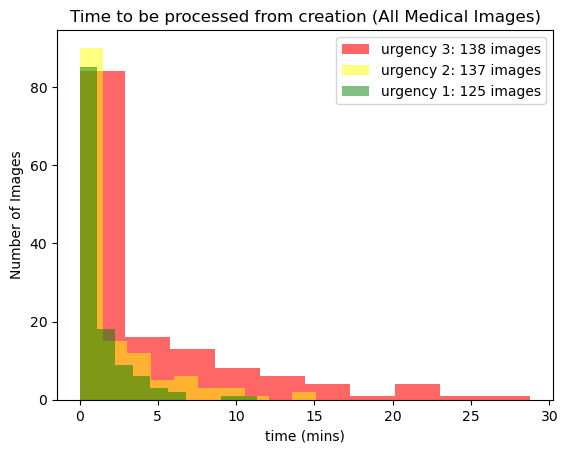

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.1568796520090452
Urgency 2: 1.8947952100449938
Urgency 3: 4.250602950965371

_______________________________________________

Time plots for images arriving avg every 2.5 mins


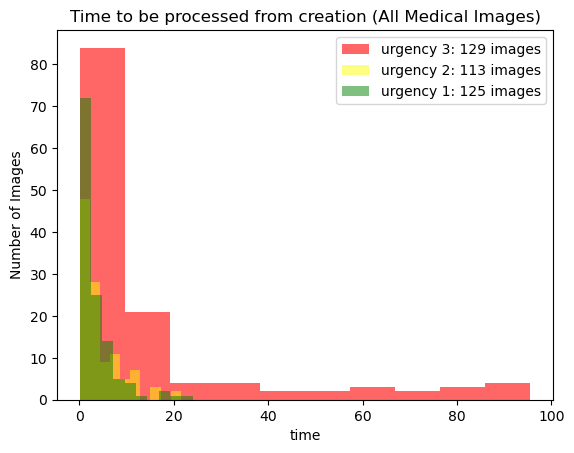

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.3503310488398443
Urgency 2: 4.46131018286314
Urgency 3: 15.16154895817571


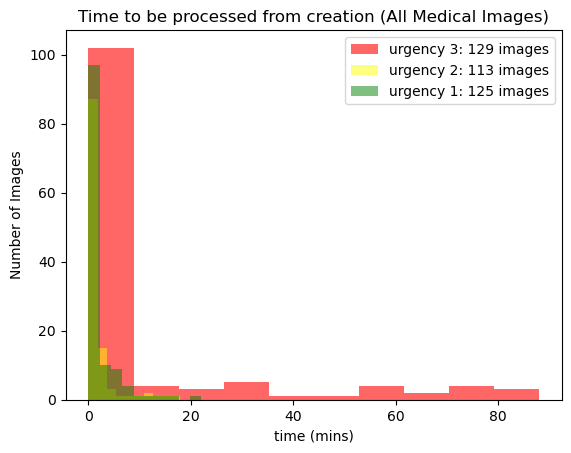

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.6314220043534358
Urgency 2: 1.3770049585975956
Urgency 3: 10.23929041282096

_______________________________________________

Time plots for images arriving avg every 2.6 mins


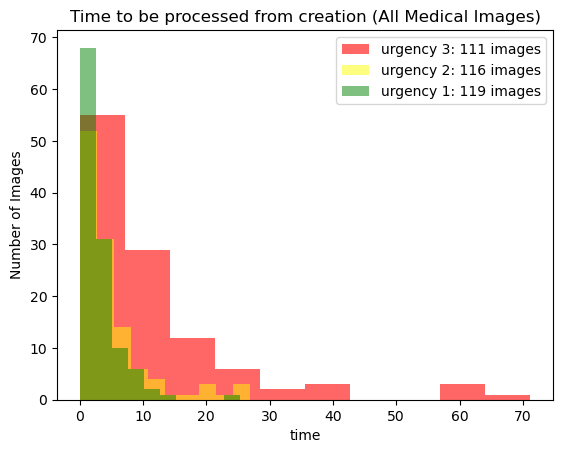

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.0952043616679554
Urgency 2: 4.993675405938915
Urgency 3: 11.39451549969107


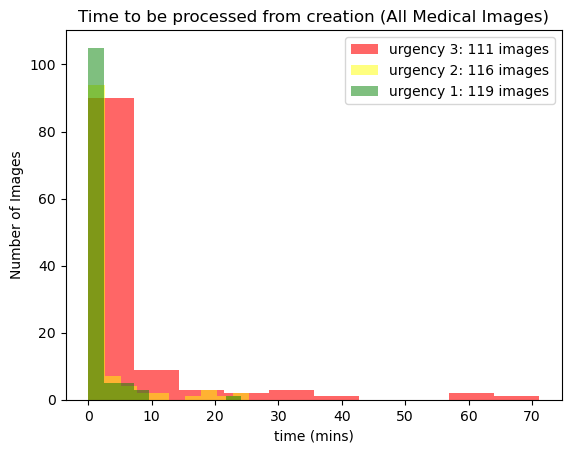

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.0105901298986535
Urgency 2: 2.2940215709109935
Urgency 3: 5.507836902873211

_______________________________________________

Time plots for images arriving avg every 2.7 mins


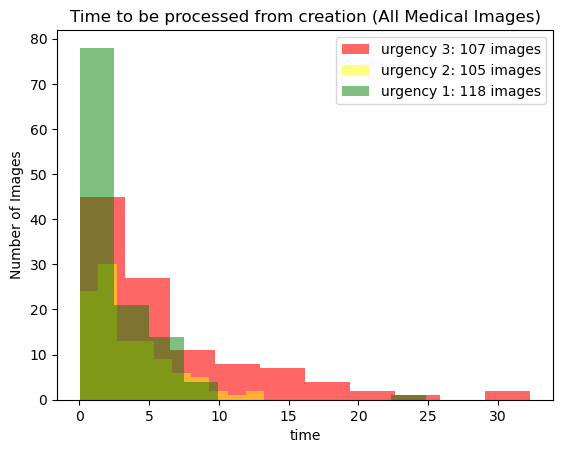

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.6265581029696303
Urgency 2: 3.586762806018894
Urgency 3: 6.3994091933284825


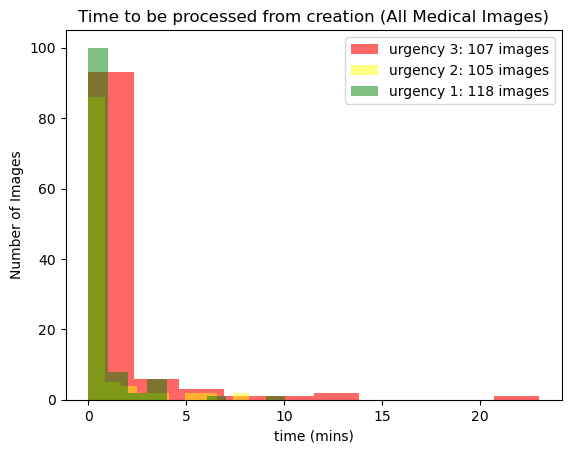

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.5741025227624513
Urgency 2: 0.7196605601171739
Urgency 3: 1.1449512867921554

_______________________________________________

Time plots for images arriving avg every 2.8 mins


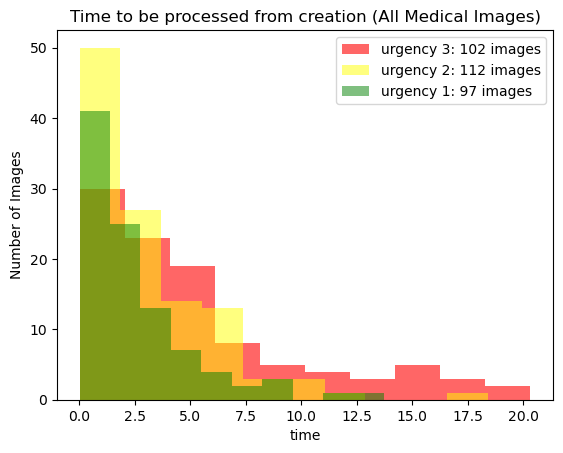

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.457921649771119
Urgency 2: 3.072174083816461
Urgency 3: 5.349410445573916


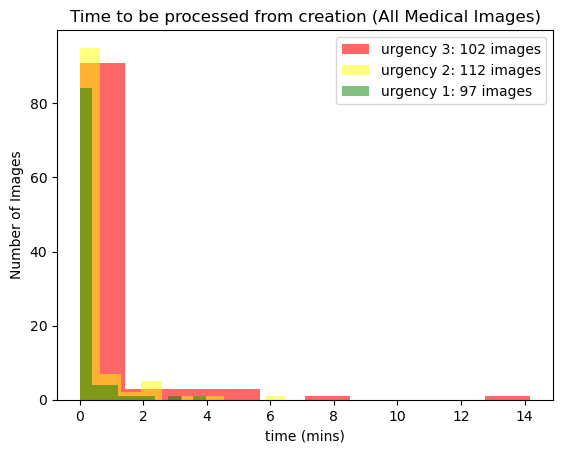

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.19383007806489572
Urgency 2: 0.3188795998827768
Urgency 3: 0.5598811507927249

_______________________________________________

Time plots for images arriving avg every 2.9 mins


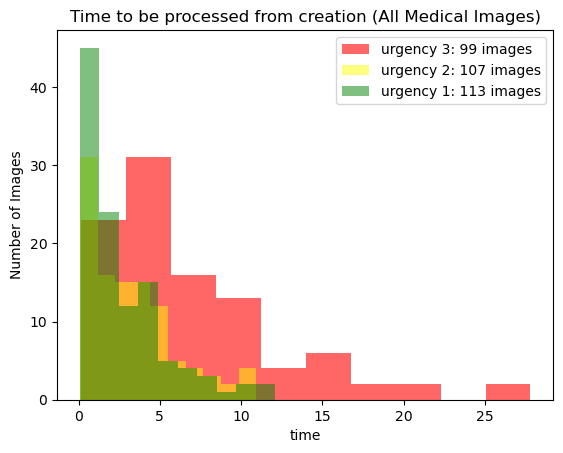

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.653406605991031
Urgency 2: 3.259905706233897
Urgency 3: 6.870780742863065


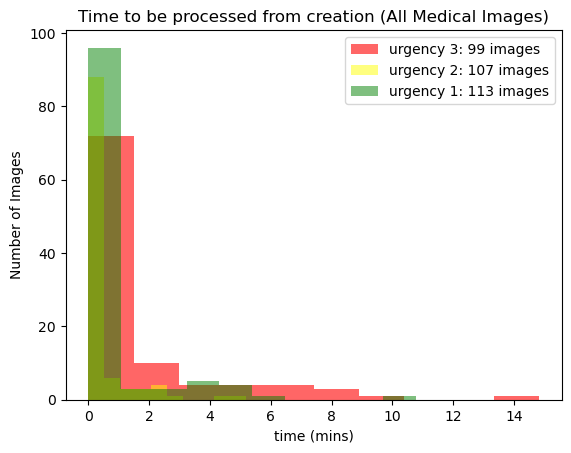

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6593626727505326
Urgency 2: 0.37044382365858974
Urgency 3: 1.3719045076308158

_______________________________________________

Time plots for images arriving avg every 3.0 mins


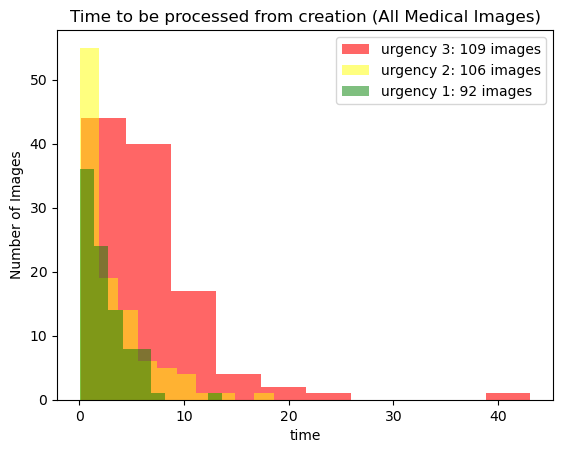

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.516479734436459
Urgency 2: 3.0843688909207074
Urgency 3: 6.39282789862237


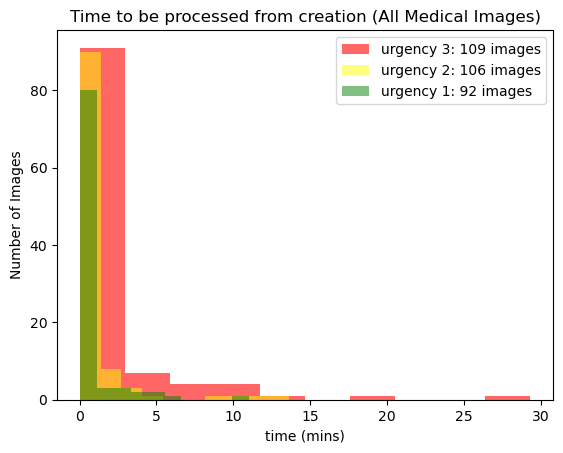

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6188536335875419
Urgency 2: 0.7964265153750032
Urgency 3: 1.7445440985734406

_______________________________________________

Time plots for images arriving avg every 3.1 mins


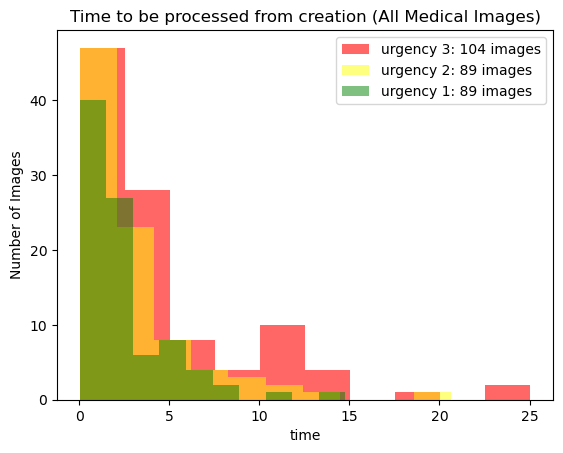

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3380286999051823
Urgency 2: 2.969336771237005
Urgency 3: 4.499985456280488


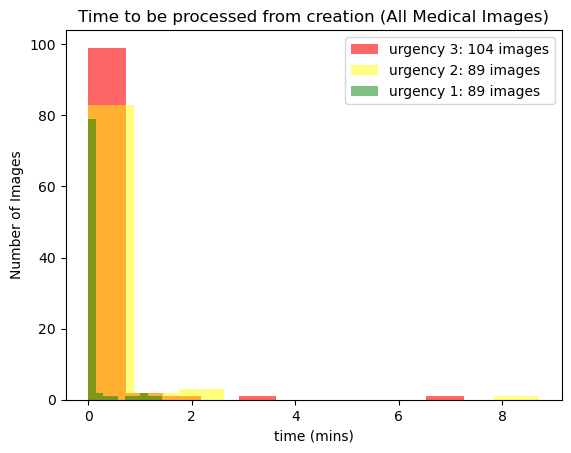

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.08909930465412885
Urgency 2: 0.2449074290422374
Urgency 3: 0.14589658925960808

_______________________________________________

Time plots for images arriving avg every 3.2 mins


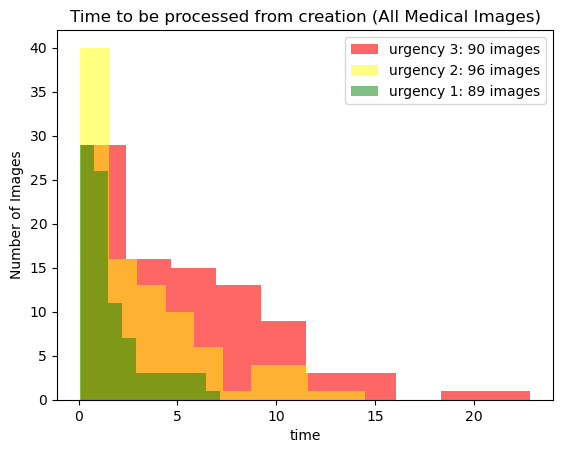

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.7488063383801453
Urgency 2: 3.358111974892413
Urgency 3: 5.555598165127706


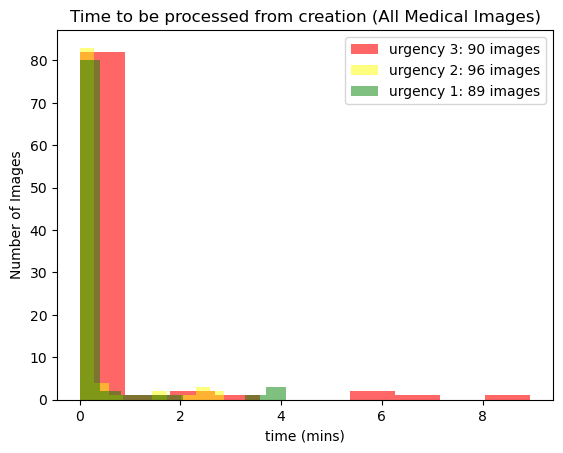

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.233423493900749
Urgency 2: 0.21848367638561747
Urgency 3: 0.4195391097432769

_______________________________________________

Time plots for images arriving avg every 3.3 mins


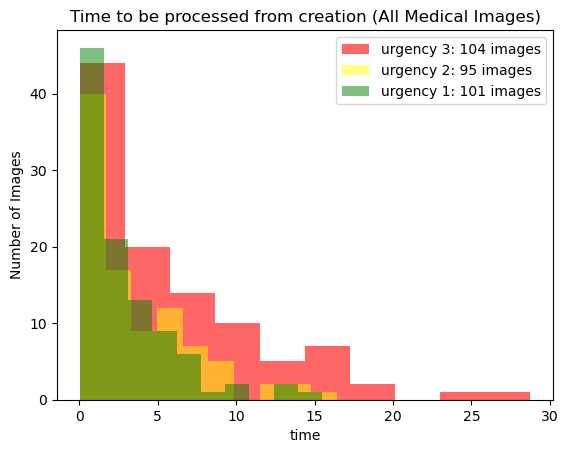

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.932549373476109
Urgency 2: 3.6146526365889535
Urgency 3: 5.78490293630064


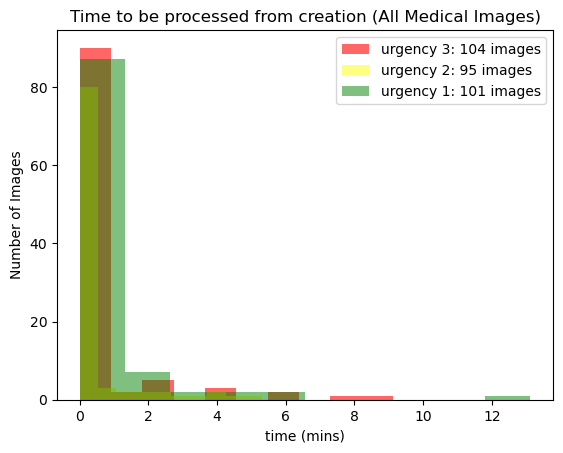

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.6035206546397288
Urgency 2: 0.404161917843571
Urgency 3: 0.547250310523795

_______________________________________________

Time plots for images arriving avg every 3.4 mins


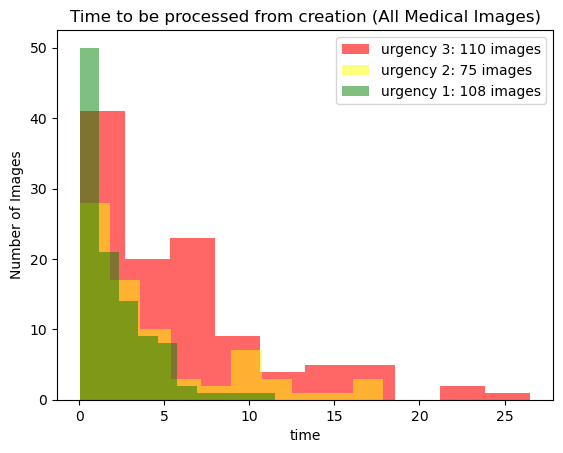

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.159315567125348
Urgency 2: 4.346751624612805
Urgency 3: 5.8237588022753055


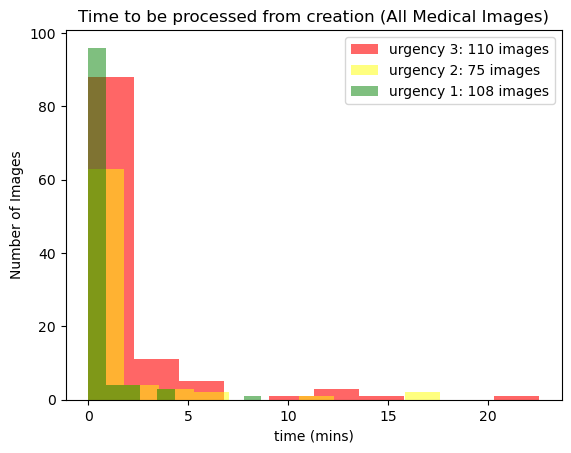

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.3417546074325053
Urgency 2: 1.1497999491923832
Urgency 3: 1.4870706409318053

_______________________________________________

Time plots for images arriving avg every 3.5 mins


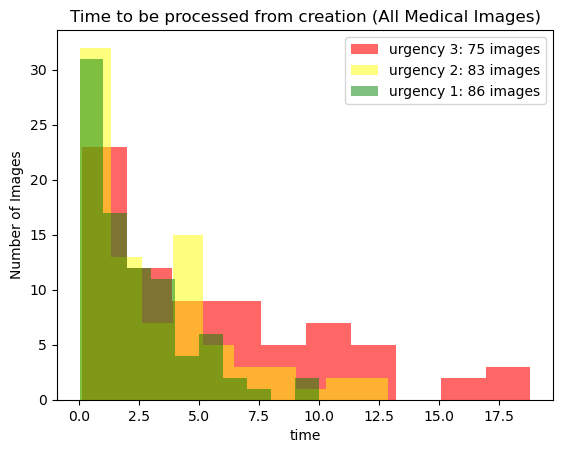

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.2921393388449016
Urgency 2: 3.259891562481557
Urgency 3: 5.655355194173582


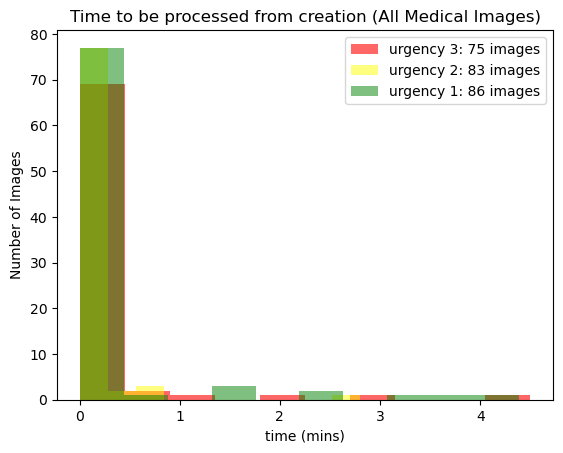

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.24619496912493302
Urgency 2: 0.06684668269512781
Urgency 3: 0.16907144426469667

_______________________________________________

Time plots for images arriving avg every 3.6 mins


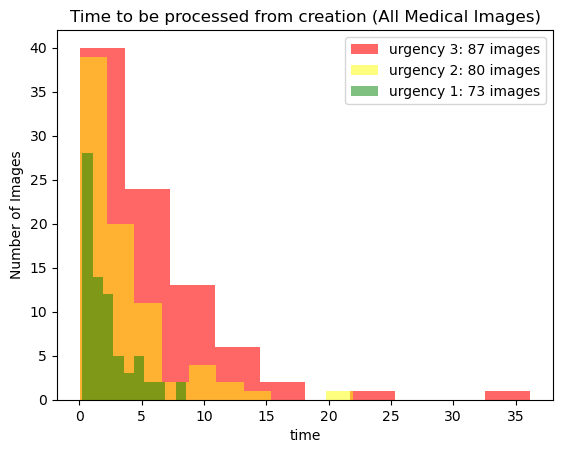

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1624922637218997
Urgency 2: 3.398887902145435
Urgency 3: 5.303052875702127


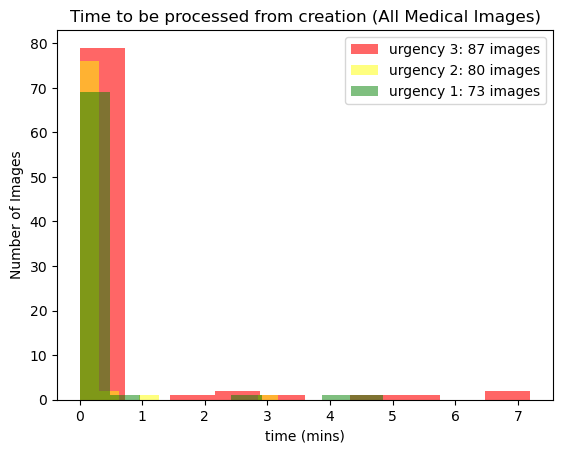

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.18477526294320298
Urgency 2: 0.07350184427504107
Urgency 3: 0.40644963408610907

_______________________________________________

Time plots for images arriving avg every 3.7 mins


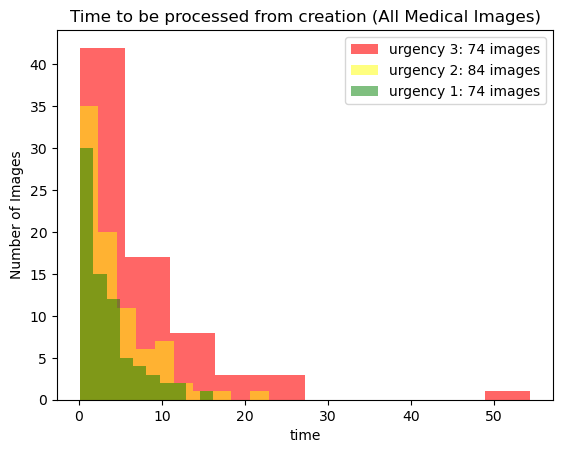

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.47176442664044
Urgency 2: 4.403768999112645
Urgency 3: 6.9207005065935805


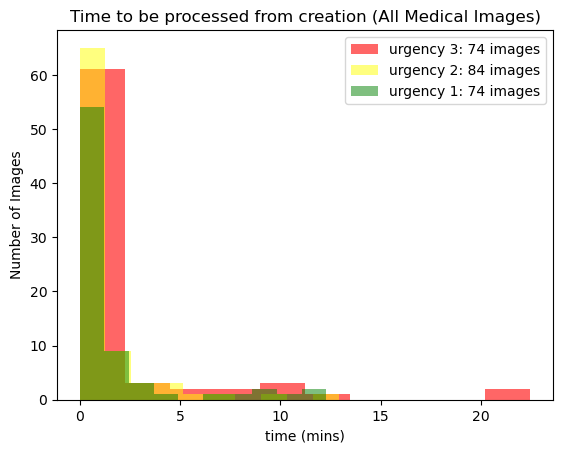

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3337704915368598
Urgency 2: 0.9842236771587002
Urgency 3: 1.8150278640595139

_______________________________________________

Time plots for images arriving avg every 3.8 mins


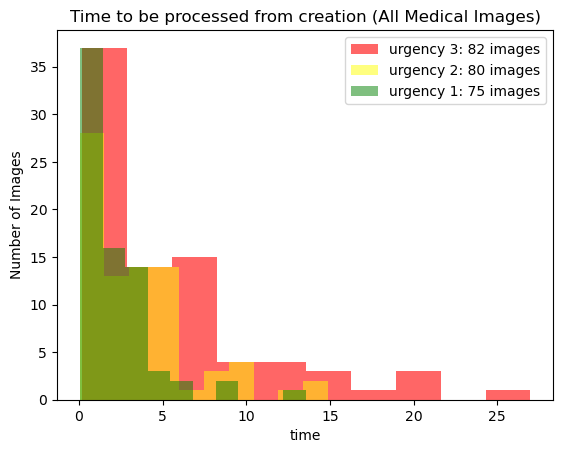

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1427433396308424
Urgency 2: 3.5752895284353974
Urgency 3: 5.408334596460317


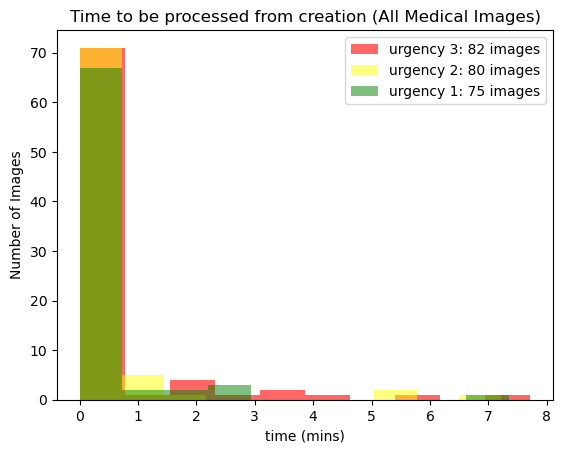

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.28975983515337767
Urgency 2: 0.33451041388975433
Urgency 3: 0.45796394096096754

_______________________________________________

Time plots for images arriving avg every 3.9 mins


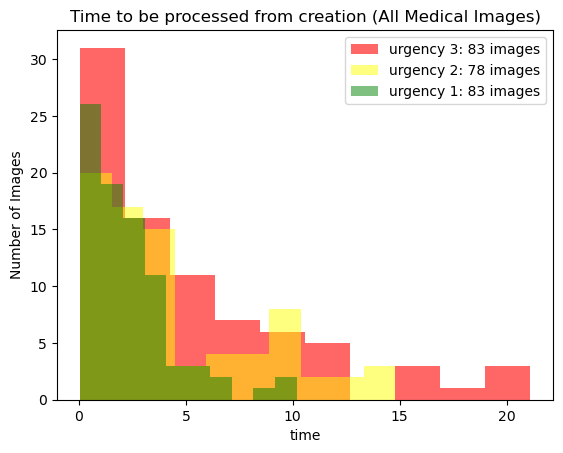

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3238770298087132
Urgency 2: 4.54645364228579
Urgency 3: 5.216916120403733


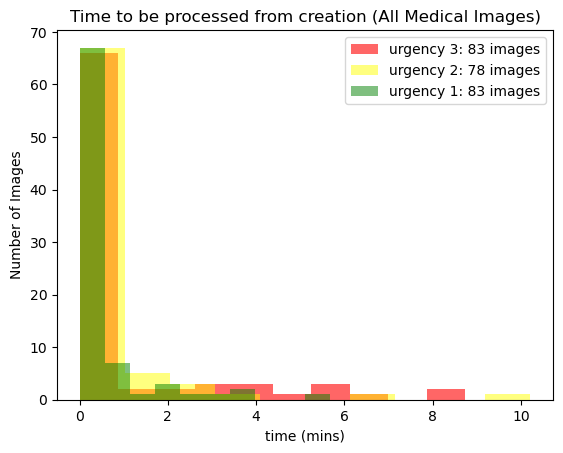

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.39798069883140214
Urgency 2: 0.49395548966448605
Urgency 3: 0.8772773555786709

_______________________________________________

Time plots for images arriving avg every 4.0 mins


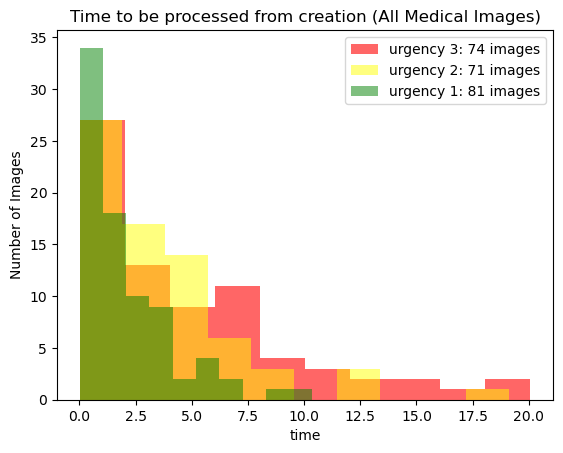

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.067726132776628
Urgency 2: 3.5741136321015983
Urgency 3: 4.980750383501504


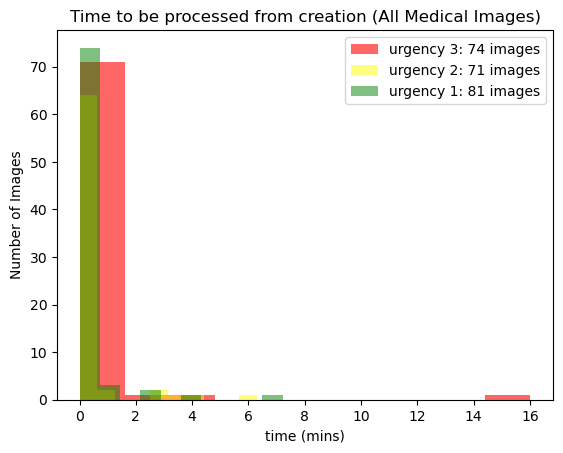

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.24686959373155917
Urgency 2: 0.3230859946791456
Urgency 3: 0.368732180499826

_______________________________________________

Time plots for images arriving avg every 4.1 mins


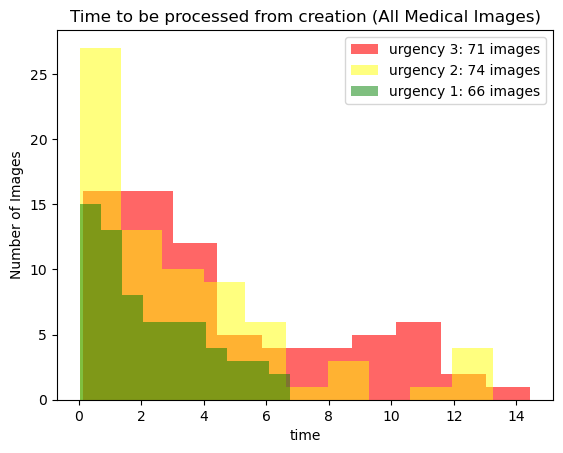

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3144509247624128
Urgency 2: 3.34008556401463
Urgency 3: 4.664084910931092


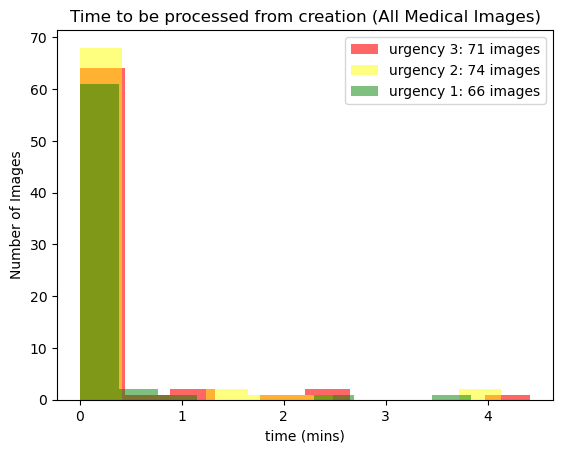

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.13817583388256058
Urgency 2: 0.20170970395782395
Urgency 3: 0.19900168108400568

_______________________________________________

Time plots for images arriving avg every 4.2 mins


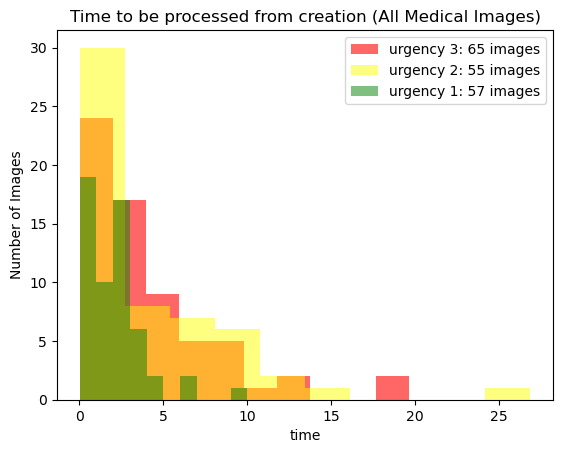

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.061860405533035
Urgency 2: 4.185247134995382
Urgency 3: 4.223007726001042


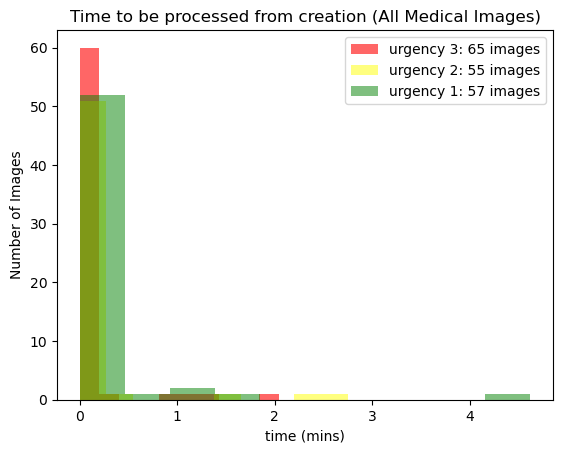

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.1561633493928783
Urgency 2: 0.12229490999719701
Urgency 3: 0.0918544528190111

_______________________________________________

Time plots for images arriving avg every 4.3 mins


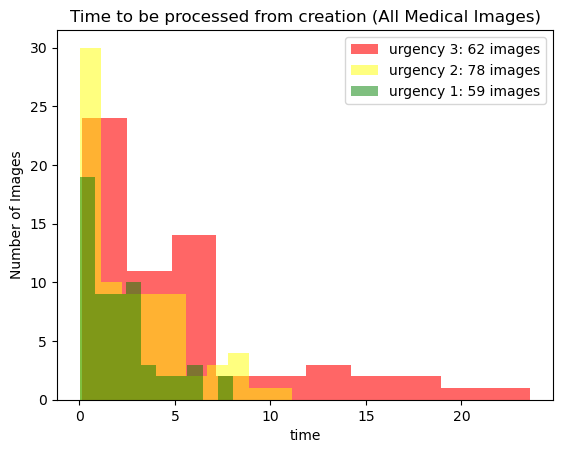

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1668222230966063
Urgency 2: 2.813197522035074
Urgency 3: 5.3704689220939175


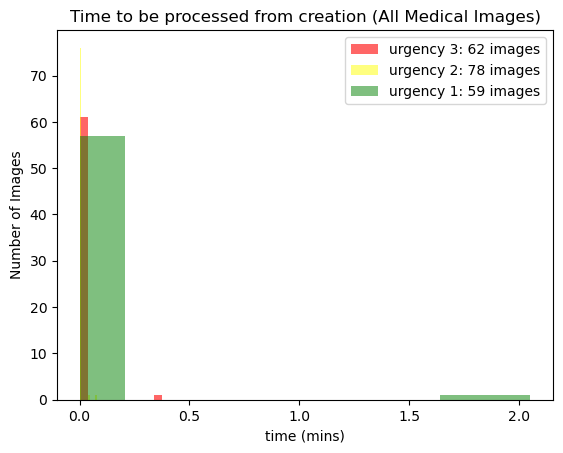

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.06266303587910821
Urgency 2: 0.001586788906314277
Urgency 3: 0.006081340875865287

_______________________________________________

Time plots for images arriving avg every 4.4 mins


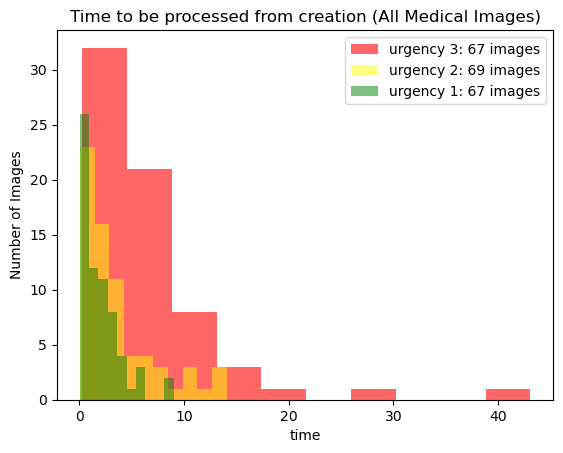

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.9942936841341397
Urgency 2: 3.6442917353187116
Urgency 3: 6.373441318466051


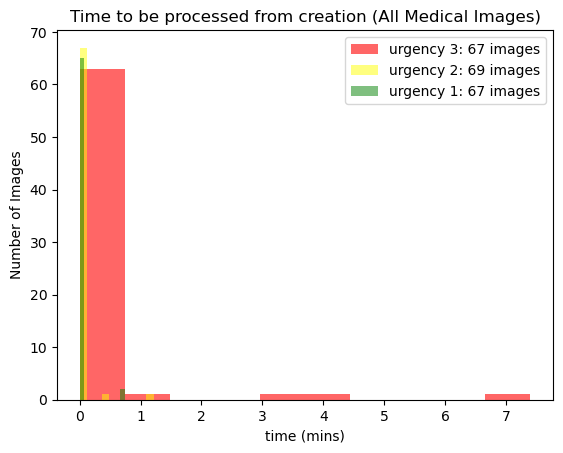

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.02161153872759981
Urgency 2: 0.023277355860526445
Urgency 3: 0.24843783268900024

_______________________________________________

Time plots for images arriving avg every 4.5 mins


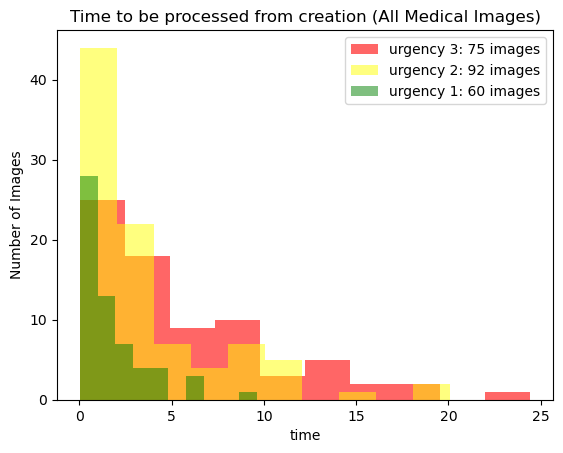

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.7342302822960605
Urgency 2: 3.522633671691226
Urgency 3: 5.729631243568892


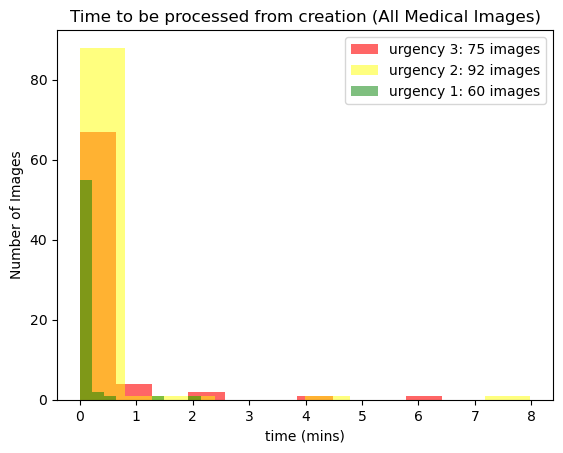

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0838292910661588
Urgency 2: 0.19189578260464418
Urgency 3: 0.25095237166712553

_______________________________________________

Time plots for images arriving avg every 4.6 mins


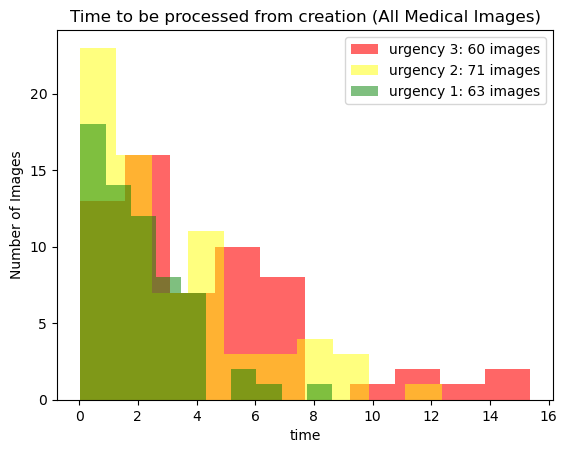

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.016457866669604
Urgency 2: 3.0675148998951434
Urgency 3: 4.249250744219225


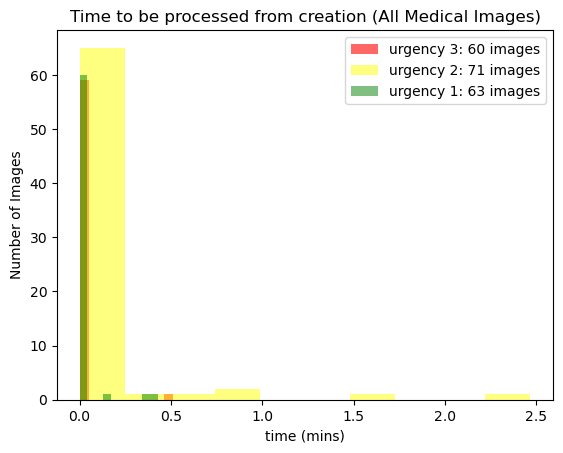

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.015012277198560955
Urgency 2: 0.09341717111353881
Urgency 3: 0.008506531375287334

_______________________________________________

Time plots for images arriving avg every 4.7 mins


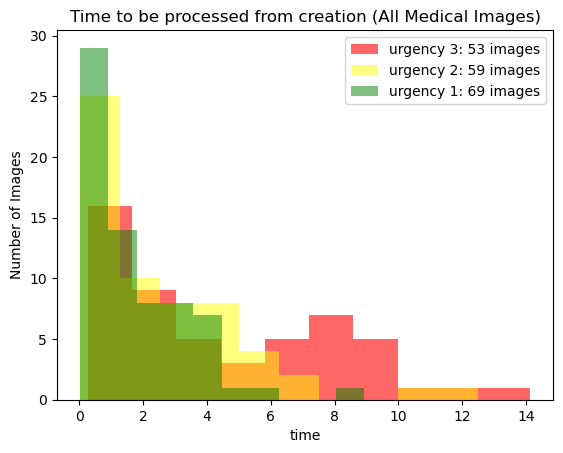

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.7993517572645394
Urgency 2: 2.6016240105868453
Urgency 3: 4.5438521499565105


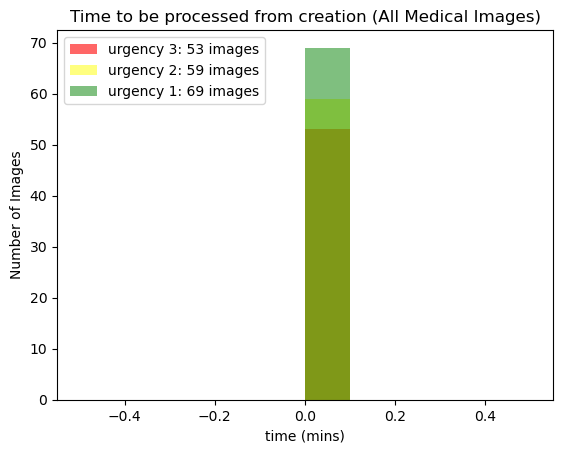

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.0
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 4.8 mins


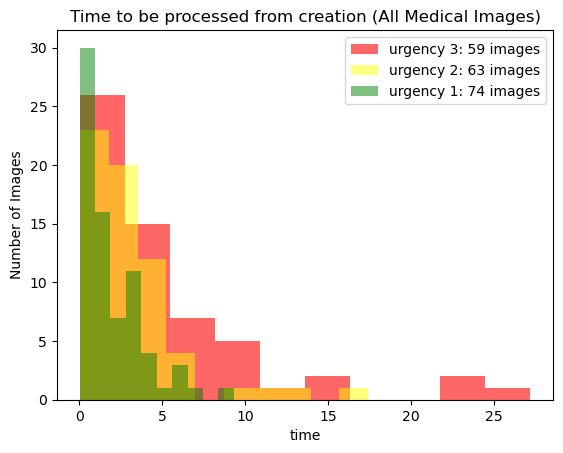

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.914193806606083
Urgency 2: 3.0993208640825705
Urgency 3: 5.178911056570295


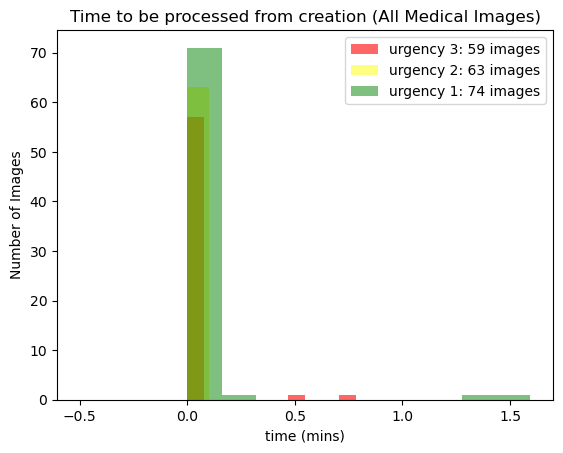

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.04382570009778151
Urgency 2: 0.0
Urgency 3: 0.021245810348013455

_______________________________________________

Time plots for images arriving avg every 4.9 mins


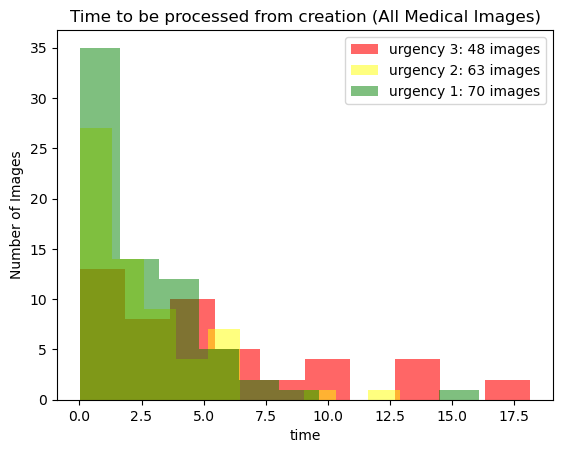

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4799151177070486
Urgency 2: 2.492531280687644
Urgency 3: 5.4718174381230185


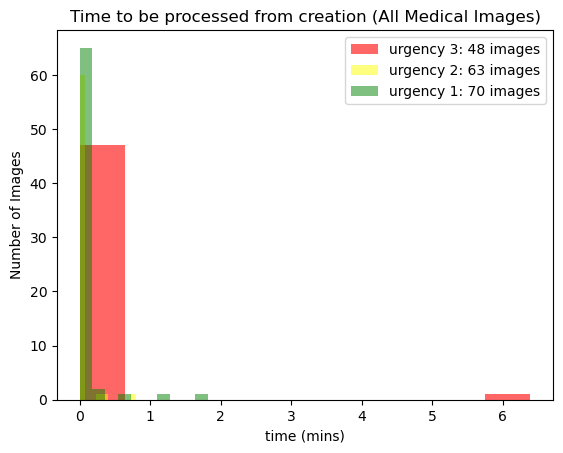

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.06216903850975741
Urgency 2: 0.021743011755742173
Urgency 3: 0.14136010140709962

_______________________________________________

Time plots for images arriving avg every 5.0 mins


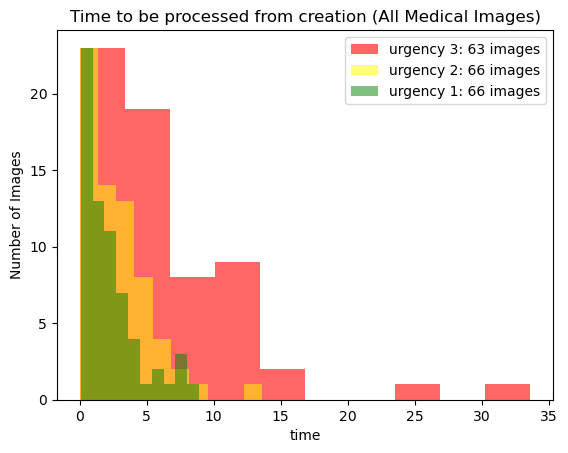

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.233938574155139
Urgency 2: 2.7966865325601047
Urgency 3: 6.0905619799784185


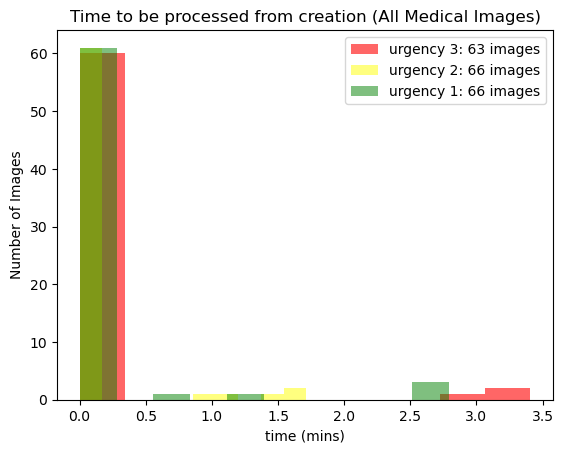

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.14834660847074307
Urgency 2: 0.1056367914801702
Urgency 3: 0.1528866726427419

_______________________________________________

Time plots for images arriving avg every 5.1 mins


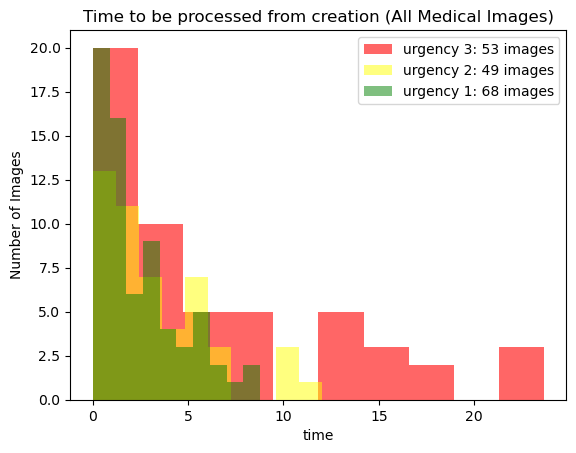

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.4457564913381216
Urgency 2: 3.3545444949695105
Urgency 3: 6.505965238254963


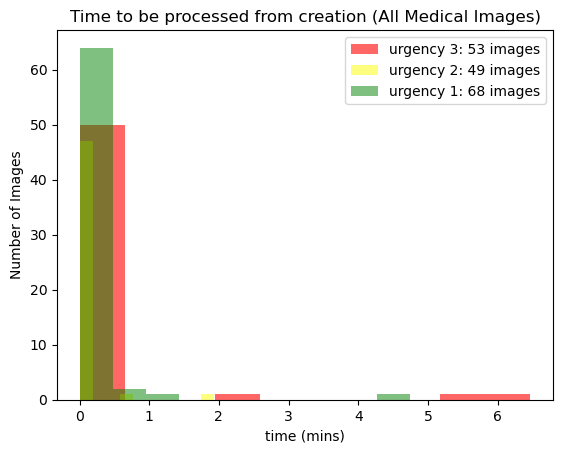

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.10996660639447473
Urgency 2: 0.05488113664849358
Urgency 3: 0.2705854739168846

_______________________________________________

Time plots for images arriving avg every 5.2 mins


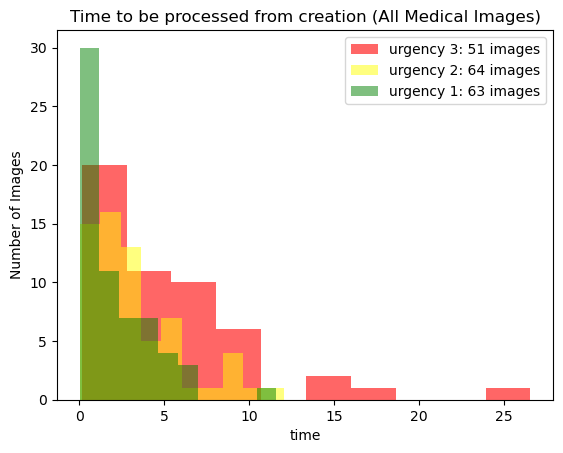

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.1054917194875835
Urgency 2: 3.258703774869074
Urgency 3: 5.022356714270811


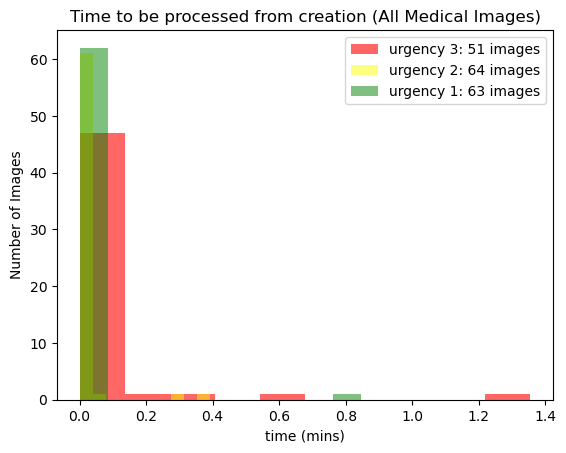

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.013444005549296374
Urgency 2: 0.011317750900245005
Urgency 3: 0.049620797737662856

_______________________________________________

Time plots for images arriving avg every 5.3 mins


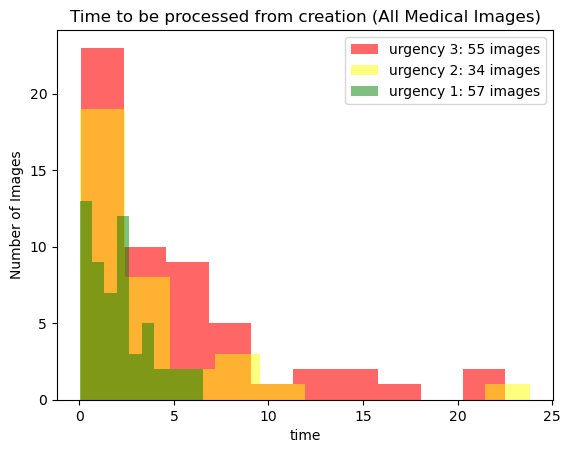

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.163012426147855
Urgency 2: 3.4906854700630805
Urgency 3: 4.867440217659621


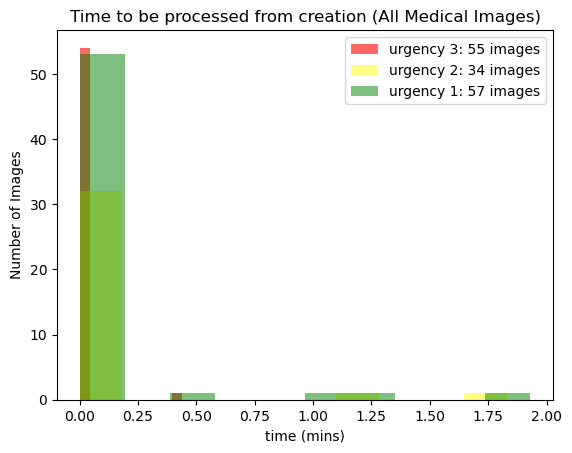

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0842950627263351
Urgency 2: 0.08886142919303766
Urgency 3: 0.00798152084940062

_______________________________________________

Time plots for images arriving avg every 5.4 mins


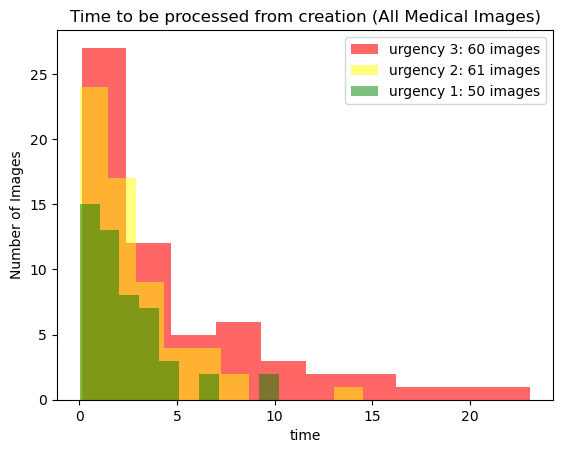

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.33273687008454
Urgency 2: 2.6642199154603565
Urgency 3: 4.943046094866198


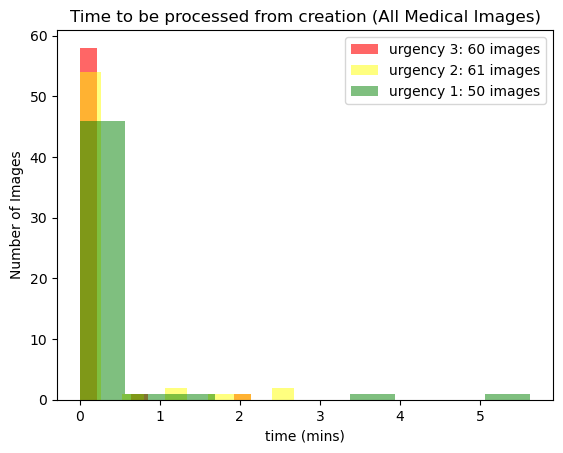

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2497332201563961
Urgency 2: 0.19590956841828652
Urgency 3: 0.051114213302357804

_______________________________________________

Time plots for images arriving avg every 5.5 mins


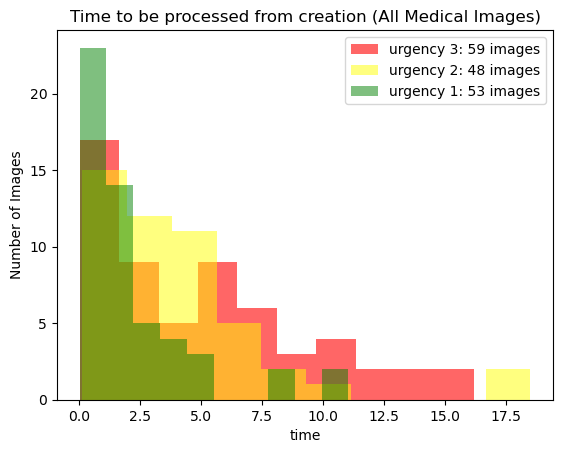

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.212461347305004
Urgency 2: 3.9638950649315556
Urgency 3: 5.024457128631037


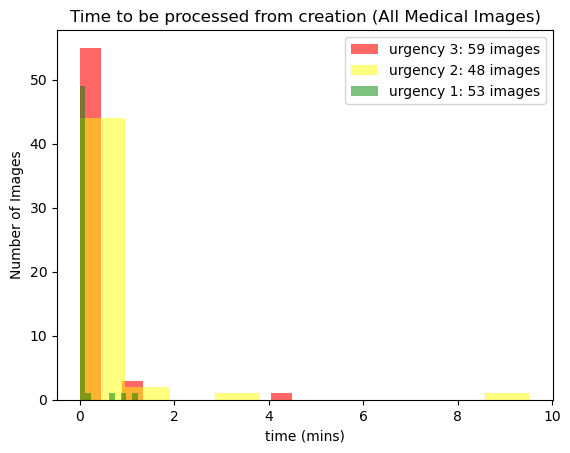

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0584325581298972
Urgency 2: 0.337334924165922
Urgency 3: 0.13351741953295065

_______________________________________________

Time plots for images arriving avg every 5.6 mins


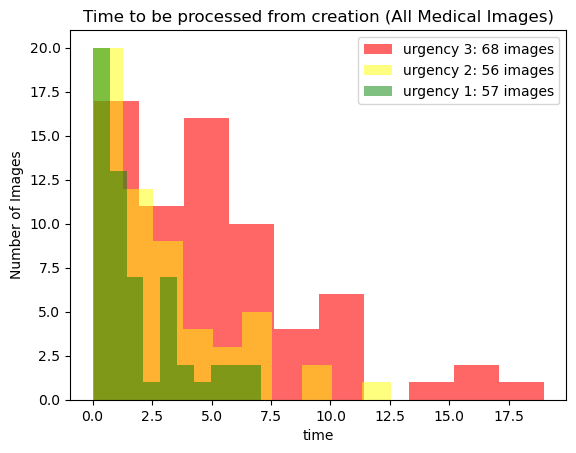

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.8450983426070782
Urgency 2: 2.940931989222201
Urgency 3: 5.108052218024986


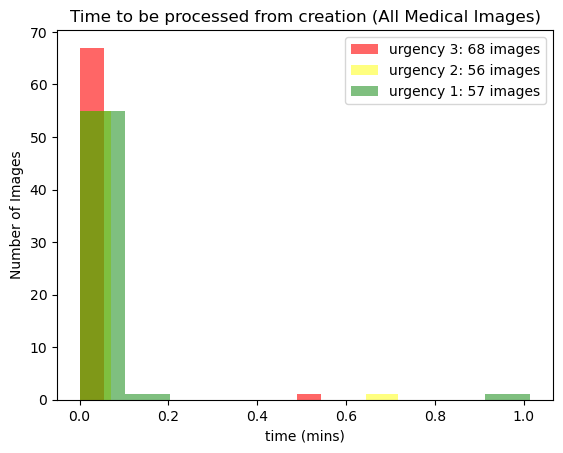

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.021476920918679435
Urgency 2: 0.012807414874806205
Urgency 3: 0.007982031115617742

_______________________________________________

Time plots for images arriving avg every 5.7 mins


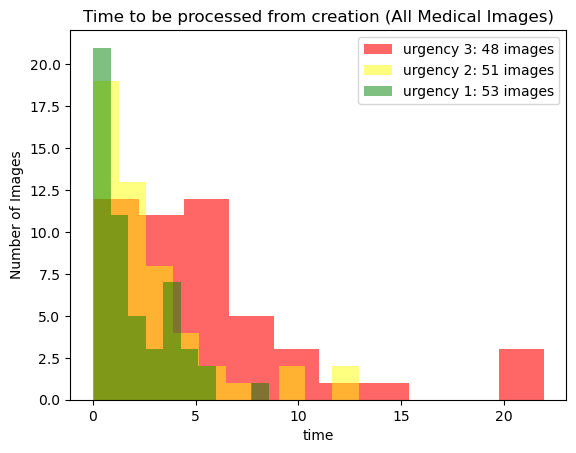

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.9680347618069554
Urgency 2: 2.820641798418098
Urgency 3: 5.497625451858582


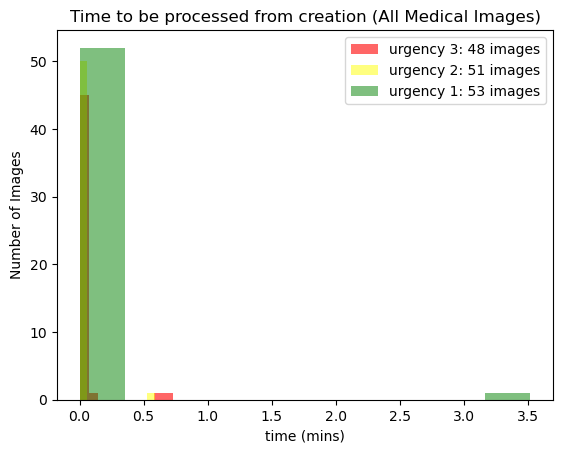

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0725694987154467
Urgency 2: 0.011505537522671883
Urgency 3: 0.030264871737334314

_______________________________________________

Time plots for images arriving avg every 5.8 mins


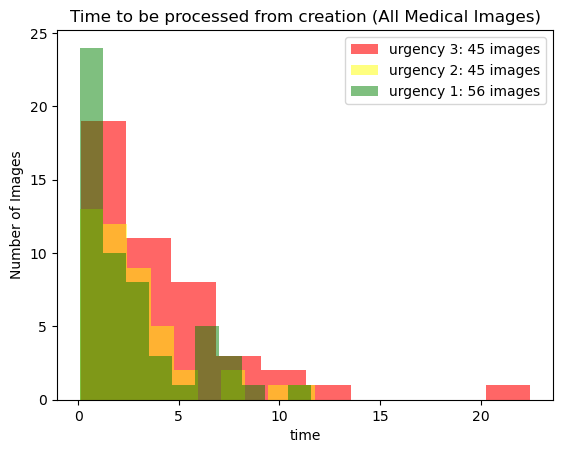

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.54890721113746
Urgency 2: 2.7984972861926973
Urgency 3: 4.002943762964094


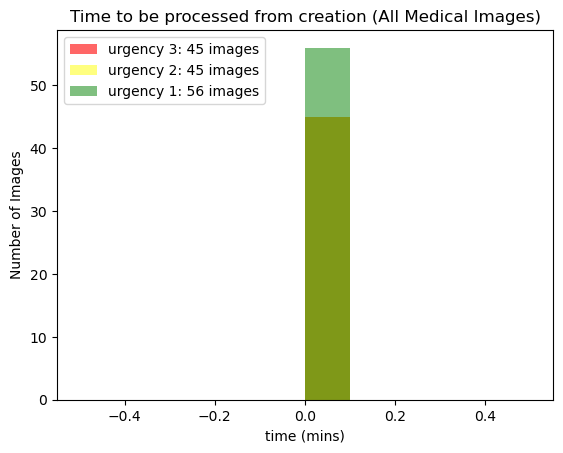

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.0
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 5.9 mins


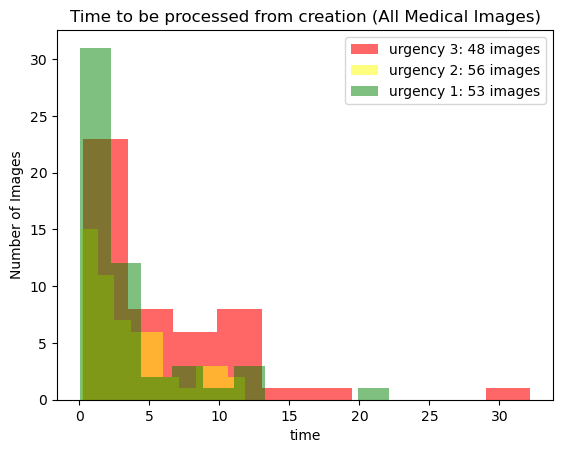

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.262457784848495
Urgency 2: 3.763430242838799
Urgency 3: 5.814598757050497


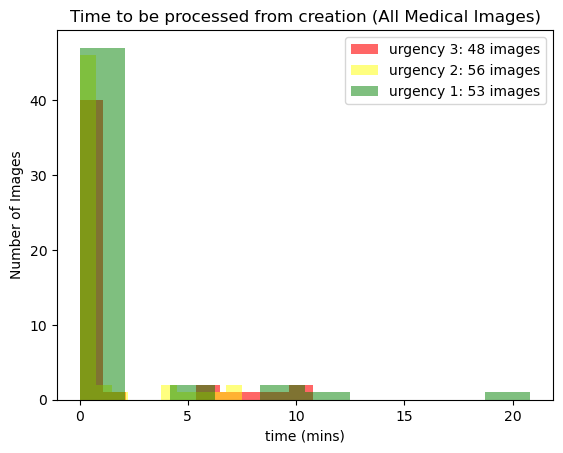

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.2818473702053357
Urgency 2: 0.783334886808062
Urgency 3: 1.218351594486567

_______________________________________________

Time plots for images arriving avg every 6.0 mins


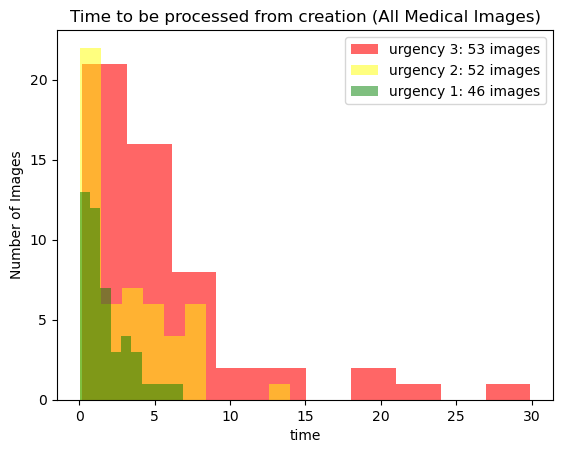

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.791961102655244
Urgency 2: 3.2089038791794517
Urgency 3: 5.748595214972089


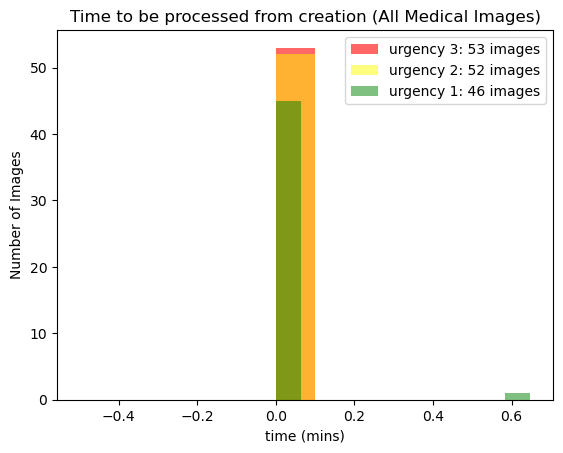

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.014091795772422545
Urgency 2: 0.0
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 6.1 mins


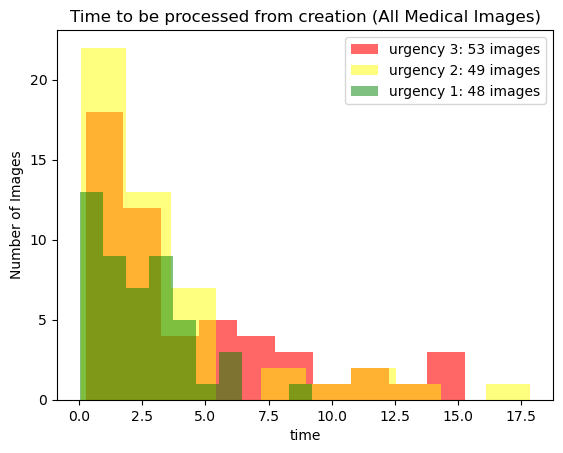

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.3978114749589743
Urgency 2: 3.3650766275811144
Urgency 3: 4.47075737379375


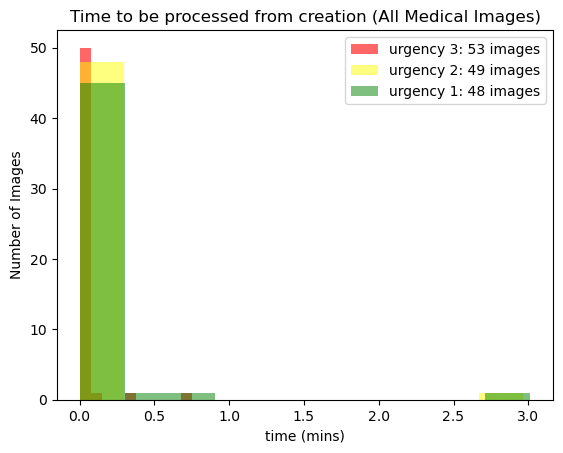

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0883266248091606
Urgency 2: 0.060515773371147004
Urgency 3: 0.023559509571224678

_______________________________________________

Time plots for images arriving avg every 6.2 mins


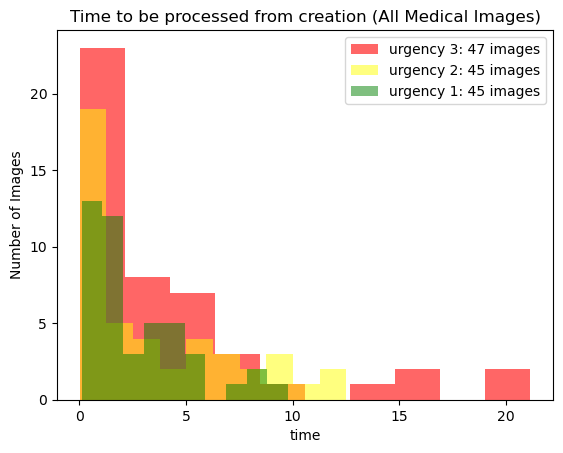

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.7055271522493185
Urgency 2: 3.575618549445283
Urgency 3: 4.225947046646677


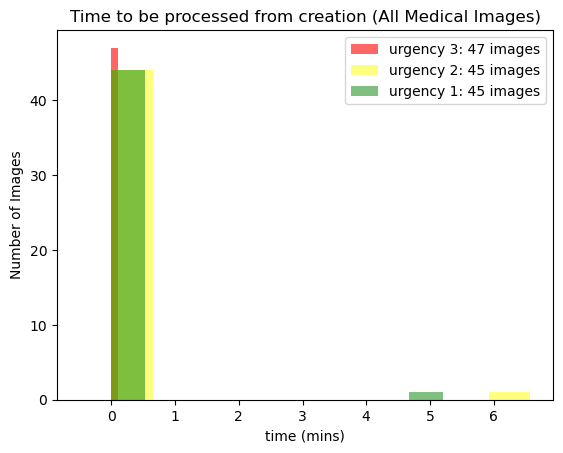

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.12691173860824972
Urgency 2: 0.14619129969812483
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 6.3 mins


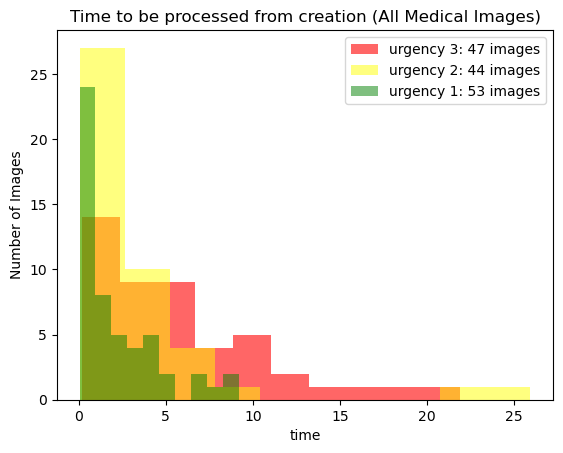

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.226898981306115
Urgency 2: 3.507264351141935
Urgency 3: 5.841672098560302


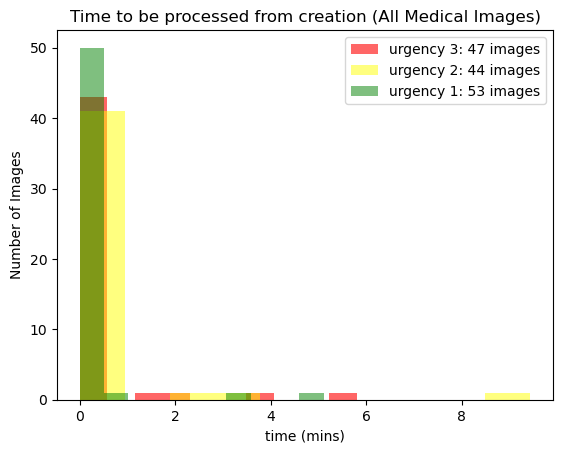

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.18540778945604866
Urgency 2: 0.3462506707112896
Urgency 3: 0.2889097325160267

_______________________________________________

Time plots for images arriving avg every 6.4 mins


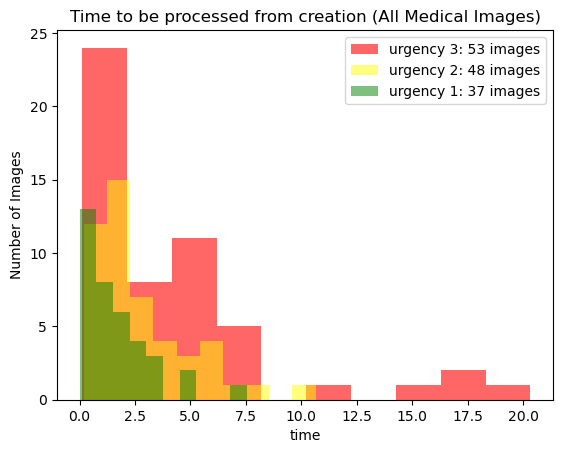

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.6553352730111648
Urgency 2: 2.808589787289453
Urgency 3: 4.122124733977476


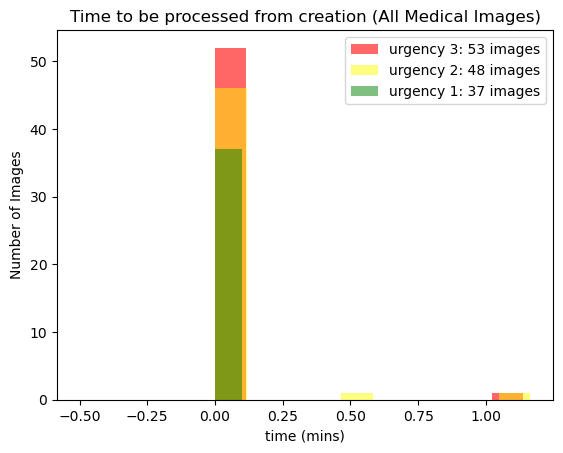

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.037429010010197196
Urgency 3: 0.021438457579474938

_______________________________________________

Time plots for images arriving avg every 6.5 mins


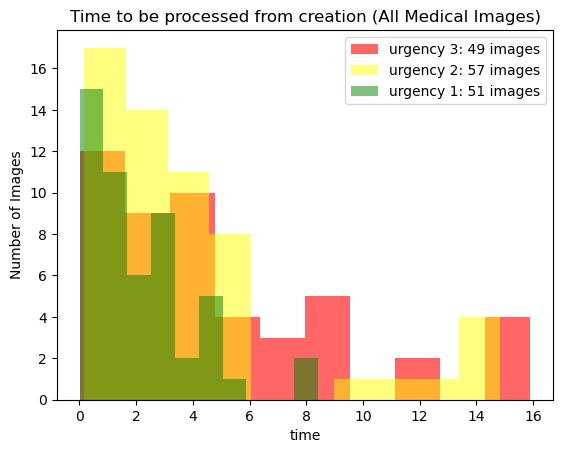

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.22756434530397
Urgency 2: 3.896070398687218
Urgency 3: 4.939238793789095


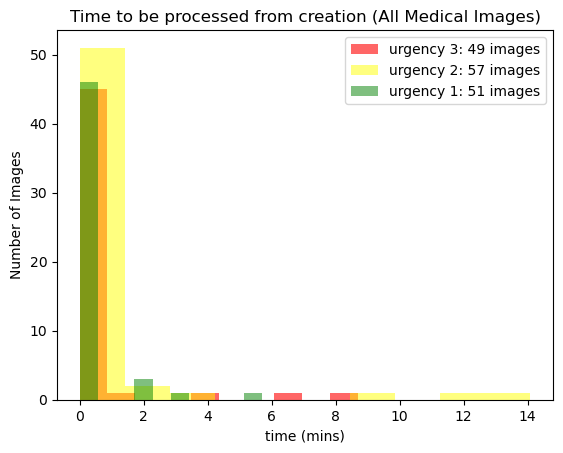

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2836145184914725
Urgency 2: 0.7481799894655512
Urgency 3: 0.4550116166575738

_______________________________________________

Time plots for images arriving avg every 6.6 mins


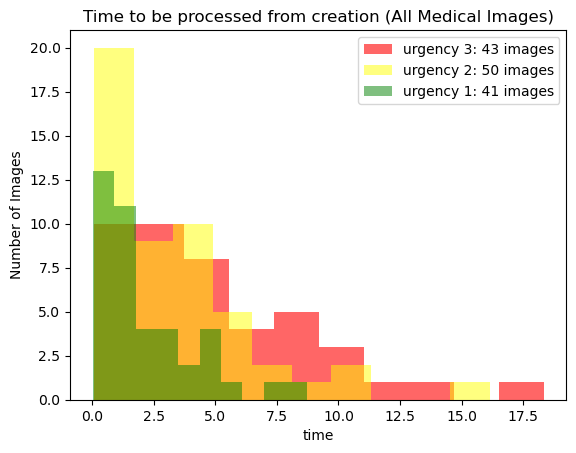

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.175467660977245
Urgency 2: 3.24108393391666
Urgency 3: 5.0674508507867815


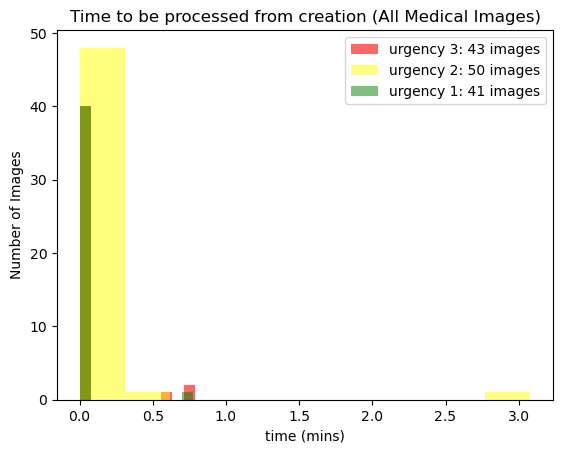

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.01888349709860527
Urgency 2: 0.07429142203350239
Urgency 3: 0.048990706141767024

_______________________________________________

Time plots for images arriving avg every 6.7 mins


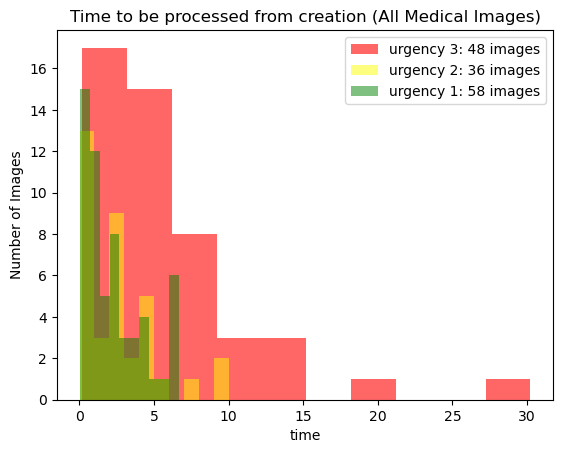

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.2385151579658653
Urgency 2: 2.6958486225950993
Urgency 3: 5.864286882284933


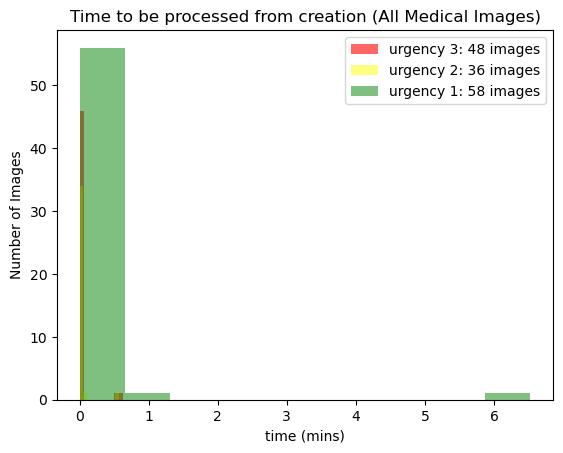

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.12622348067379266
Urgency 2: 0.01834783383159275
Urgency 3: 0.024534792045090608

_______________________________________________

Time plots for images arriving avg every 6.8 mins


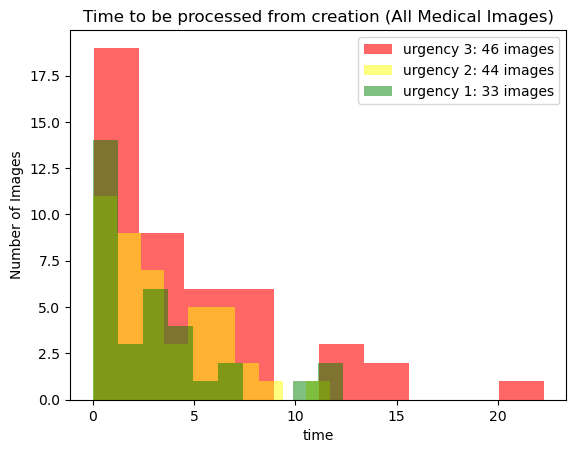

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 3.0330164391047134
Urgency 2: 3.4156323240751245
Urgency 3: 4.606594413939977


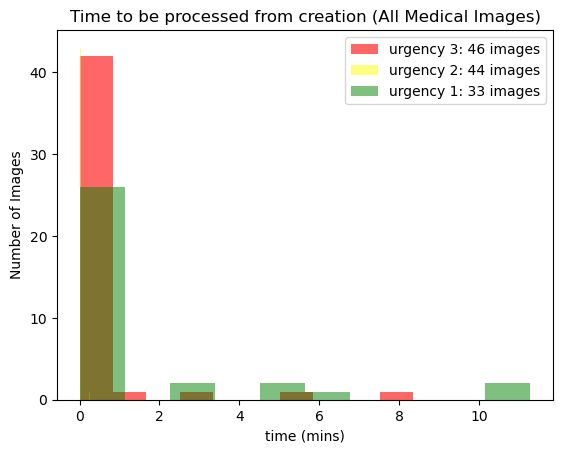

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.3707728489064939
Urgency 2: 0.005654971061775382
Urgency 3: 0.3761100747215791

_______________________________________________

Time plots for images arriving avg every 6.9 mins


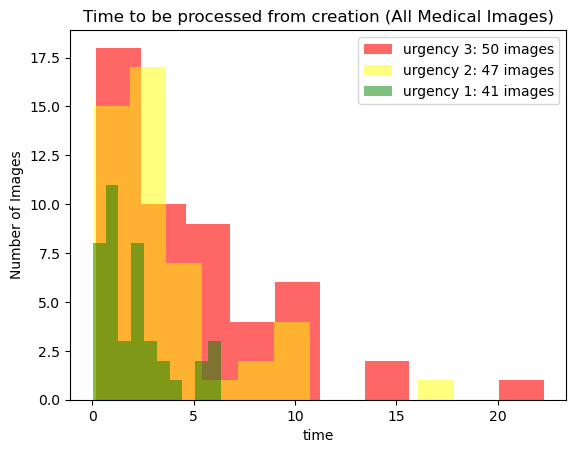

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0188319790121354
Urgency 2: 3.5977004845290996
Urgency 3: 4.926140074960326


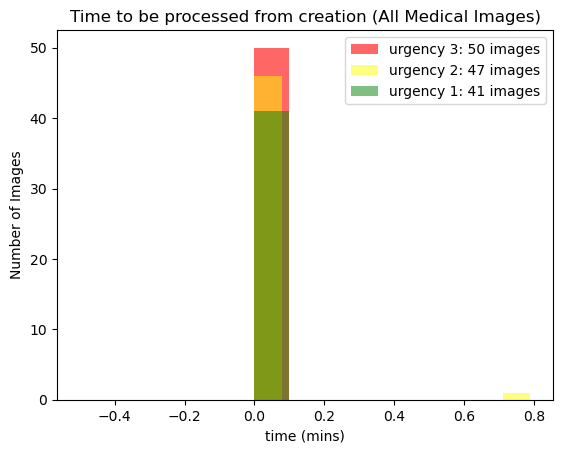

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.01678994487640055
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 7.0 mins


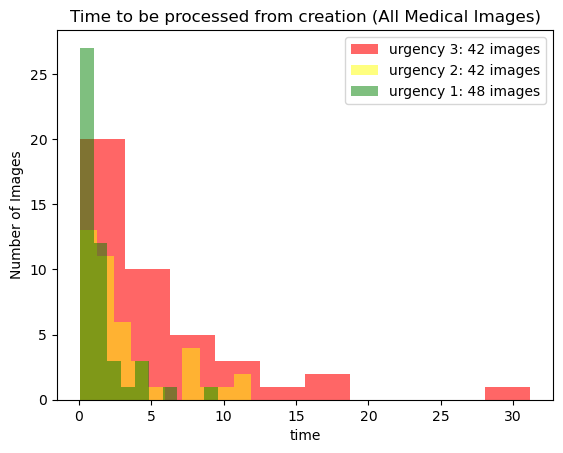

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.4843147800270315
Urgency 2: 3.1531943433437397
Urgency 3: 5.2403505061252655


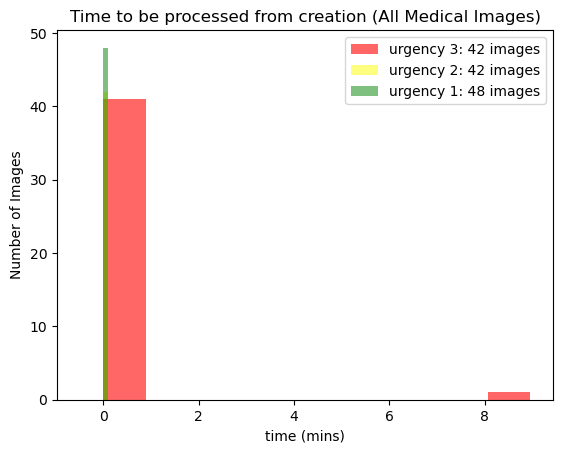

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.0
Urgency 3: 0.2133482538028813

_______________________________________________

Time plots for images arriving avg every 7.1 mins


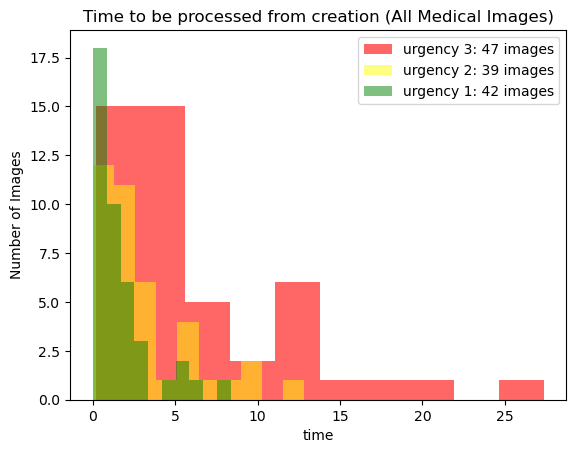

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.6632301285410644
Urgency 2: 3.178146810869835
Urgency 3: 6.059541567841771


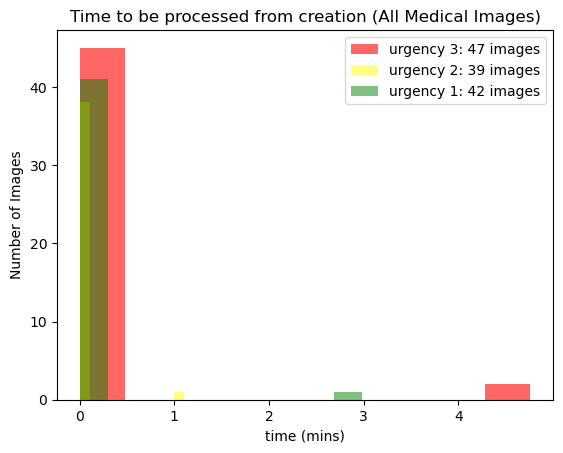

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.07102956917766112
Urgency 2: 0.028276422962987224
Urgency 3: 0.19721057409758927

_______________________________________________

Time plots for images arriving avg every 7.2 mins


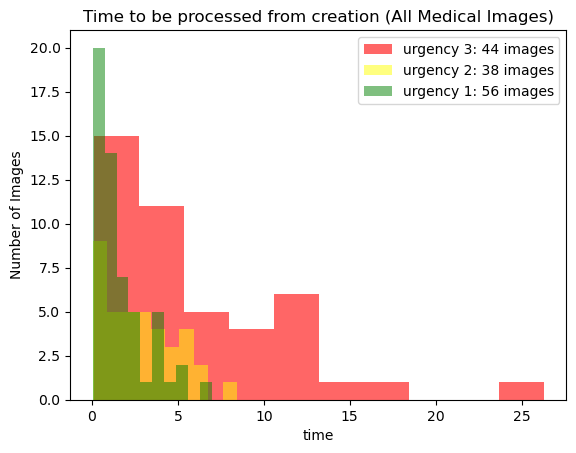

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.6410446603003914
Urgency 2: 2.8173438122406687
Urgency 3: 5.884102495348127


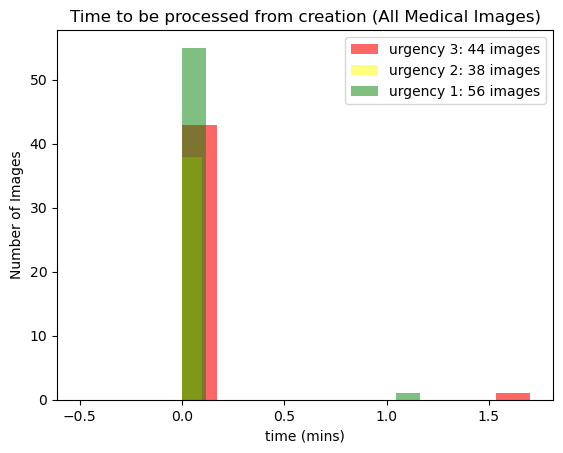

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.020742035073358065
Urgency 2: 0.0
Urgency 3: 0.03870216323224945

_______________________________________________

Time plots for images arriving avg every 7.3 mins


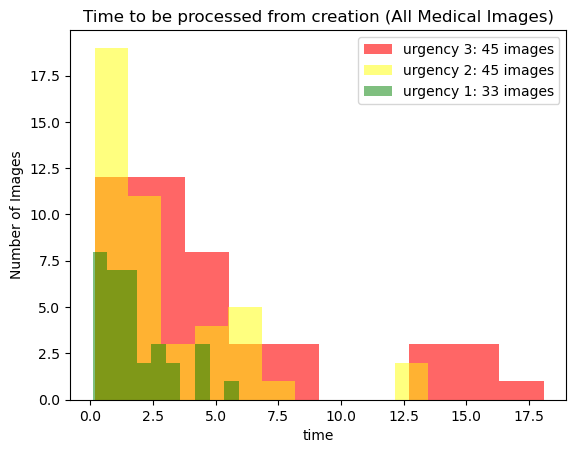

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.7422249524909255
Urgency 2: 2.9148474805945295
Urgency 3: 5.141803613840764


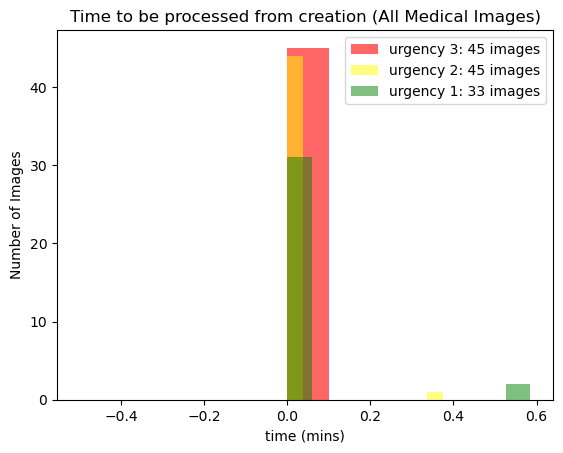

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.035413381303490095
Urgency 2: 0.00832766209315423
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 7.4 mins


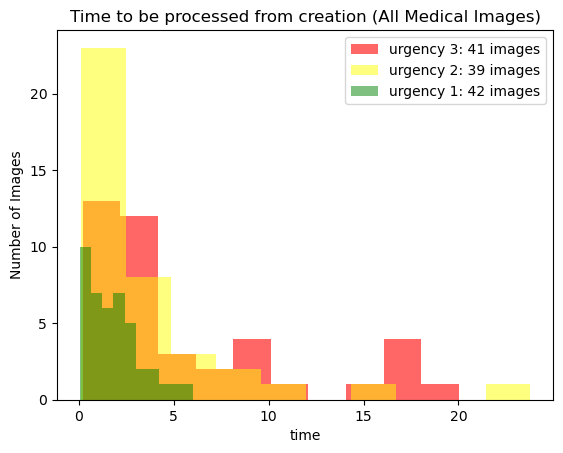

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.7924101531041423
Urgency 2: 3.34343315279554
Urgency 3: 5.721996181206775


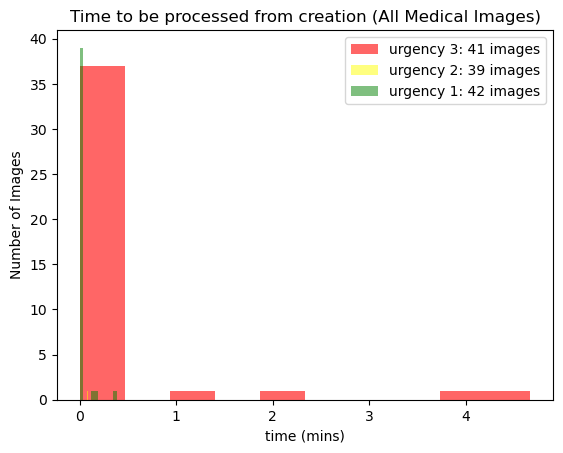

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.015671226554074803
Urgency 2: 0.002255988801036251
Urgency 3: 0.305887395954866

_______________________________________________

Time plots for images arriving avg every 7.5 mins


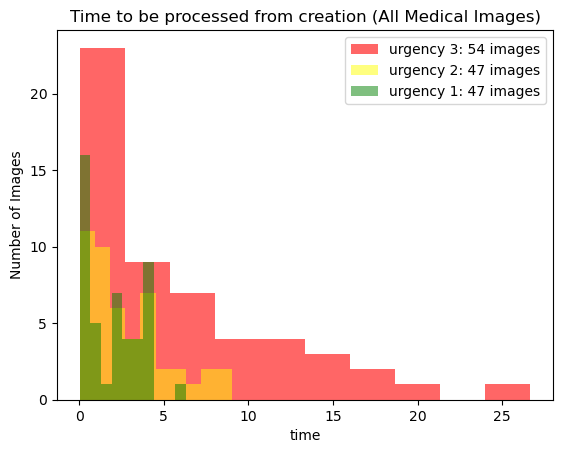

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0245209201296093
Urgency 2: 2.827375437251692
Urgency 3: 5.90076550393822


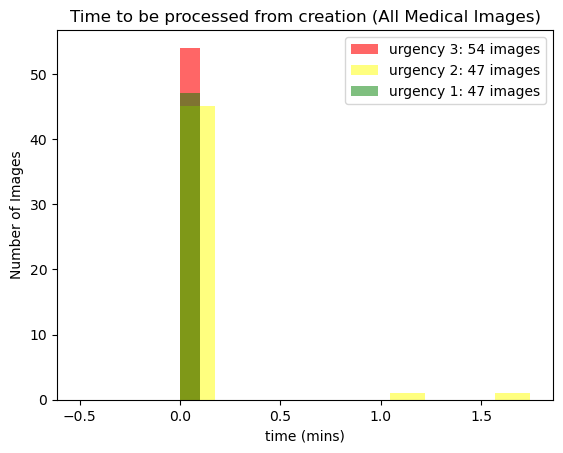

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.06004041904862846
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 7.6 mins


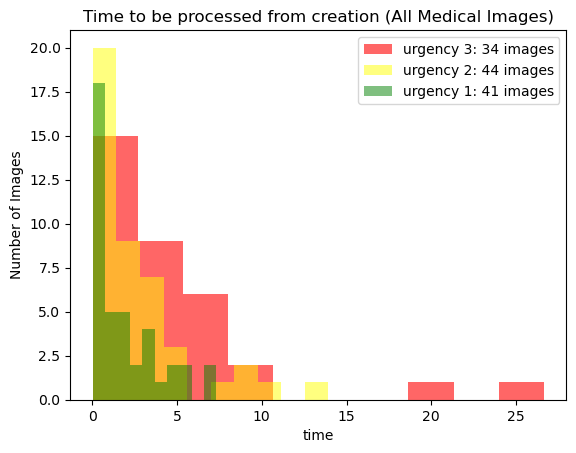

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.878653282863937
Urgency 2: 2.734168677832361
Urgency 3: 4.617985265789123


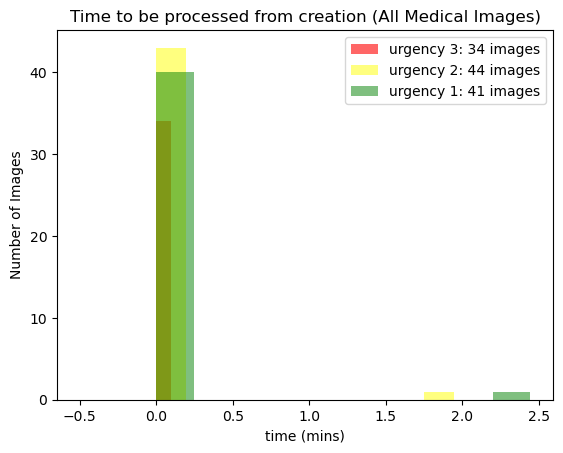

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.059622029454876
Urgency 2: 0.04424471993707935
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 7.7 mins


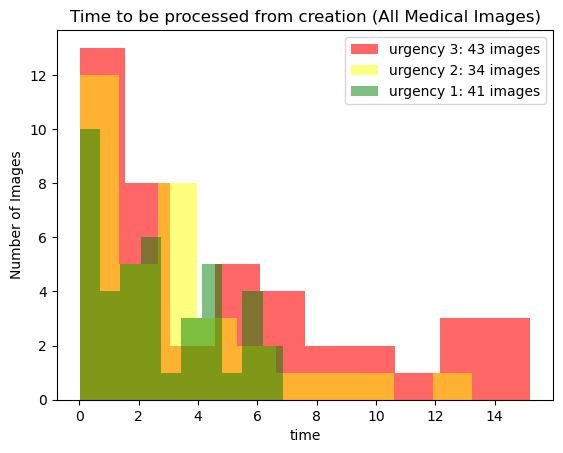

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.646694857941691
Urgency 2: 3.0133184502407353
Urgency 3: 5.049043511456345


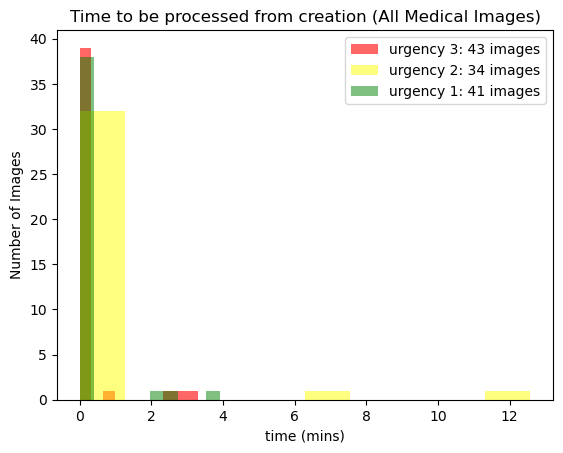

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.2070831535457373
Urgency 2: 0.5828248386396941
Urgency 3: 0.22840245796060146

_______________________________________________

Time plots for images arriving avg every 7.8 mins


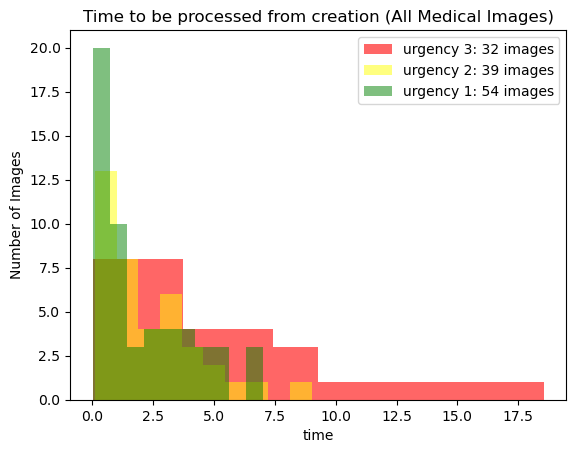

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 2.0379958114184253
Urgency 2: 2.2900029469155547
Urgency 3: 5.194379479878449


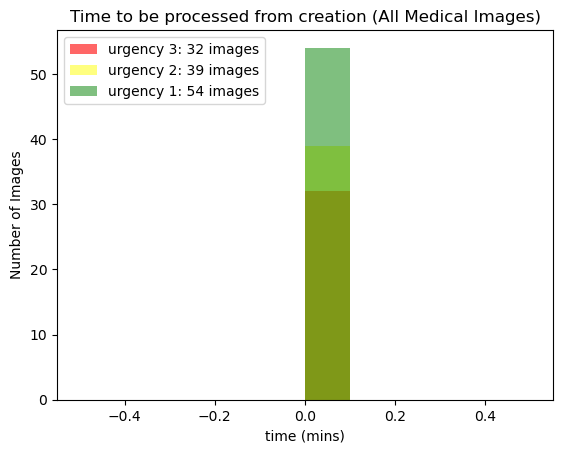

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.0
Urgency 2: 0.0
Urgency 3: 0.0

_______________________________________________

Time plots for images arriving avg every 7.9 mins


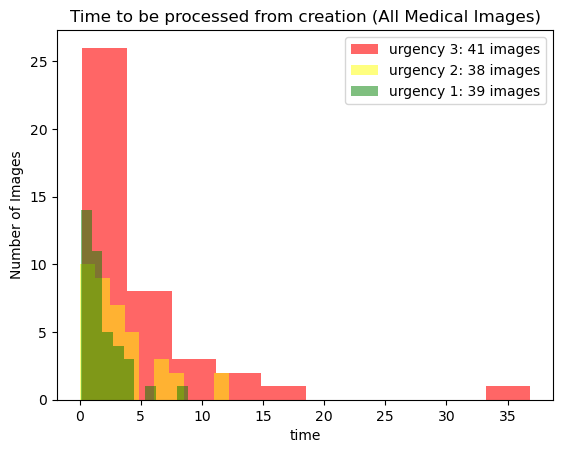

The average total time for urgency 1, 2, and 3 medical images are:
Urgency 1: 1.860312890262416
Urgency 2: 3.275542214134487
Urgency 3: 4.789485580698616


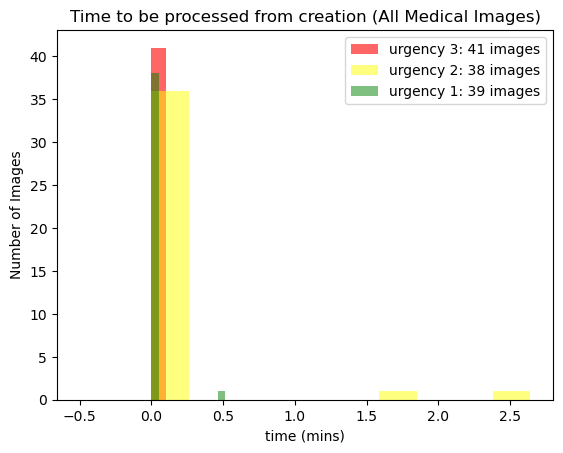

The average wait time for urgency 1, 2, and 3 medical images are:
Urgency 1: 0.01314333551138775
Urgency 2: 0.11877043203585688
Urgency 3: 0.0

_______________________________________________



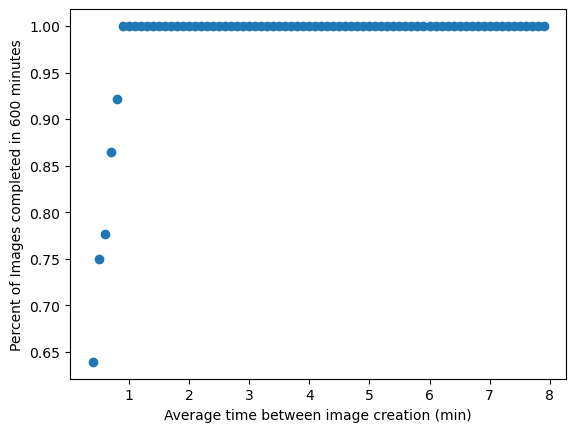

In [11]:
for arr_val, s in sims_dict.items():
    print(f"Time plots for images arriving avg every {round(arr_val,2)} mins")
    total_time_hist(s)
    wait_time_hist(s)
    print("")
    print("_______________________________________________")
    print("")
    
completion_plot(sims_dict)

In [ ]:
@app.callback(Output('call-wait-time-graph', 'figure'),
              [Input('agent_table', 'children'),
               Input('live-update-graph', 'hoverData')])
def wait_time_graph(rad_table, time_filter):
    '''
    '''
    agent_table_df = pd.read_json(agent_table_json, orient='split')
    #print('agent_table: ', agent_table_df_orig)
    
    current_hover = None
    if time_filter is not None:
        if time_filter['points'][0]['customdata'] != 'showall':
            current_hover = dt.datetime.strptime(time_filter['points'][0]['customdata'], "%Y-%m-%d %H:%M:%S")
    
    if current_hover is not None:
            agent_table_df = agent_table_df[agent_table_df['intvl_time_elapsed'] == cgd.timeElapsed(current_hover)].reset_index()

    traces=[]
    colorlist = []
    
    for x in agent_table_df['call_wait_time_elapsed'].tolist():
        if x > 60:
            colorlist.append('rgb(244,109,67)') #Red
        else:
            colorlist.append('rgb(128,205,193)') #Green
            
    traces.append(go.Scatter(
            x=agent_table_df['call_handle_start_time'],
            y=agent_table_df['call_wait_time_elapsed'],
            mode='markers', 
            marker={'color': colorlist, 'opacity': 0.8, 'line': {'width': 0.5, 'color': 'white'}},
            name=''))
    
    return {
        'data': traces,
        'layout': go.Layout(
            height=225,
            margin=margin,
            title="Avg. Call Wait Time: {:.2f} sec".format(round(sum(agent_table_df['call_wait_time_elapsed'])/float(len(agent_table_df))),2),
            xaxis={'zeroline': False},
            yaxis={'title': '', 'range':[0, max(agent_table_df['call_wait_time_elapsed'])*1.1], 'zeroline': False},
            hovermode='closest',
            font=dict(family='Raleway')
        )
    }